##### Copyright 2021 The TensorFlow Authors.

In [6]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Object Detection with TensorFlow Lite Model Maker

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/lite/tutorials/model_maker_object_detection"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/tutorials/model_maker_object_detection.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/tutorials/model_maker_object_detection.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/tensorflow/tensorflow/lite/g3doc/tutorials/model_maker_object_detection.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In this colab notebook, you'll learn how to use the [TensorFlow Lite Model Maker](https://www.tensorflow.org/lite/guide/model_maker) library to train a custom object detection model capable of detecting salads within images on a mobile device.

The Model Maker library uses *transfer learning* to simplify the process of training a TensorFlow Lite model using a custom dataset. Retraining a TensorFlow Lite model with your own custom dataset reduces the amount of training data required and will shorten the training time.

You'll use the publicly available *Salads* dataset, which was created from the [Open Images Dataset V4](https://storage.googleapis.com/openimages/web/index.html).

Each image in the dataset contains objects labeled as one of the following classes:
* Baked Good
* Cheese
* Salad
* Seafood
* Tomato

The dataset contains the bounding-boxes specifying where each object locates, together with the object's label.

Here is an example image from the dataset:

<br/>

<img src="https://cloud.google.com/vision/automl/object-detection/docs/images/quickstart-preparing_a_dataset.png" width="400" hspace="0">




## Prerequisites


### Install the required packages
Start by installing the required packages, including the Model Maker package from the [GitHub repo](https://github.com/tensorflow/examples/tree/master/tensorflow_examples/lite/model_maker) and the pycocotools library you'll use for evaluation.

In [7]:
!pip uninstall --yes tensorboard
!pip install -q tensorflow==2.7.0
!pip install -q --use-deprecated=legacy-resolver tflite-model-maker
!pip install -q pycocotools

Found existing installation: tensorboard 2.7.0
Uninstalling tensorboard-2.7.0:
  Successfully uninstalled tensorboard-2.7.0


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\capts\\Desktop\\code\\python\\vision\\venv\\Lib\\site-packages\\~-nsorflow\\lite\\experimental\\microfrontend\\python\\ops\\_audio_microfrontend_op.so'
Check the permissions.

You should consider upgrading via the 'c:\users\capts\desktop\code\python\vision\venv\scripts\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'c:\users\capts\desktop\code\python\vision\venv\scripts\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'c:\users\capts\desktop\code\python\vision\venv\scripts\python.exe -m pip install --upgrade pip' command.


Import the required packages.

In [8]:
import numpy as np
import os

from tflite_model_maker.config import QuantizationConfig
from tflite_model_maker.config import ExportFormat
from tflite_model_maker import model_spec
from tflite_model_maker import object_detector

import tensorflow as tf
assert tf.__version__.startswith('2')

tf.get_logger().setLevel('ERROR')
from absl import logging
logging.set_verbosity(logging.ERROR)

### Prepare the dataset

Here you'll use the same dataset as the AutoML [quickstart](https://cloud.google.com/vision/automl/object-detection/docs/edge-quickstart#preparing_a_dataset).

The *Salads* dataset is available at:
 `gs://cloud-ml-data/img/openimage/csv/salads_ml_use.csv`.

It contains 175 images for training, 25 images for validation, and 25 images for testing. The dataset has five classes: `Salad`, `Seafood`, `Tomato`, `Baked goods`, `Cheese`.

<br/>

The dataset is provided in CSV format:
```
TRAINING,gs://cloud-ml-data/img/openimage/3/2520/3916261642_0a504acd60_o.jpg,Salad,0.0,0.0954,,,0.977,0.957,,
VALIDATION,gs://cloud-ml-data/img/openimage/3/2520/3916261642_0a504acd60_o.jpg,Seafood,0.0154,0.1538,,,1.0,0.802,,
TEST,gs://cloud-ml-data/img/openimage/3/2520/3916261642_0a504acd60_o.jpg,Tomato,0.0,0.655,,,0.231,0.839,,
```

* Each row corresponds to an object localized inside a larger image, with each object specifically designated as test, train, or validation data. You'll learn more about what that means in a later stage in this notebook.
* The three lines included here indicate **three distinct objects located inside the same image** available at `gs://cloud-ml-data/img/openimage/3/2520/3916261642_0a504acd60_o.jpg`.
* Each row has a different label: `Salad`, `Seafood`, `Tomato`, etc.
* Bounding boxes are specified for each image using the top left and bottom right vertices.

Here is a visualzation of these three lines:

<br>

<img src="https://cloud.google.com/vision/automl/object-detection/docs/images/quickstart-preparing_a_dataset.png" width="400" hspace="100">

If you want to know more about how to prepare your own CSV file and the minimum requirements for creating a valid dataset, see the [Preparing your training data](https://cloud.google.com/vision/automl/object-detection/docs/prepare) guide for more details.

If you are new to Google Cloud, you may wonder what the `gs://` URL means. They are URLs of files stored on [Google Cloud Storage](https://cloud.google.com/storage) (GCS). If you make your files on GCS public or [authenticate your client](https://cloud.google.com/storage/docs/authentication#libauth), Model Maker can read those files similarly to your local files.

However, you don't need to keep your images on Google Cloud to use Model Maker. You can use a local path in your CSV file and Model Maker will just work.

## Quickstart

There are six steps to training an object detection model:

**Step 1. Choose an object detection model archiecture.**

This tutorial uses the EfficientDet-Lite0 model. EfficientDet-Lite[0-4] are a family of mobile/IoT-friendly object detection models derived from the [EfficientDet](https://arxiv.org/abs/1911.09070) architecture.

Here is the performance of each EfficientDet-Lite models compared to each others.

| Model architecture | Size(MB)* | Latency(ms)** | Average Precision*** |
|--------------------|-----------|---------------|----------------------|
| EfficientDet-Lite0 | 4.4       | 37            | 25.69%               |
| EfficientDet-Lite1 | 5.8       | 49            | 30.55%               |
| EfficientDet-Lite2 | 7.2       | 69            | 33.97%               |
| EfficientDet-Lite3 | 11.4      | 116           | 37.70%               |
| EfficientDet-Lite4 | 19.9      | 260           | 41.96%               |

<i> * Size of the integer quantized models. <br/>
** Latency measured on Pixel 4 using 4 threads on CPU. <br/>
*** Average Precision is the mAP (mean Average Precision) on the COCO 2017 validation dataset.
</i>


In [9]:
spec = model_spec.get('efficientdet_lite0')

**Step 2. Load the dataset.**

Model Maker will take input data in the CSV format. Use the `object_detector.DataLoader.from_csv` method to load the dataset and split them into the training, validation and test images.

* Training images: These images are used to train the object detection model to recognize salad ingredients.
* Validation images: These are images that the model didn't see during the training process. You'll use them to decide when you should stop the training, to avoid [overfitting](https://en.wikipedia.org/wiki/Overfitting).
* Test images: These images are used to evaluate the final model performance.

You can load the CSV file directly from Google Cloud Storage, but you don't need to keep your images on Google Cloud to use Model Maker. You can specify a local CSV file on your computer, and Model Maker will work just fine.

In [11]:
train_data, validation_data, test_data = object_detector.DataLoader.from_csv('gs://cloud-ml-data/img/openimage/csv/salads_ml_use.csv')

UnimplementedError: File system scheme 'gs' not implemented (file: 'gs://cloud-ml-data/img/openimage/csv/salads_ml_use.csv')

**Step 3. Train the TensorFlow model with the training data.**

* The EfficientDet-Lite0 model uses `epochs = 50` by default, which means it will go through the training dataset 50 times. You can look at the validation accuracy during training and stop early to avoid overfitting.
* Set `batch_size = 8` here so you will see that it takes 21 steps to go through the 175 images in the training dataset.
* Set `train_whole_model=True` to fine-tune the whole model instead of just training the head layer to improve accuracy. The trade-off is that it may take longer to train the model.

In [ ]:
model = object_detector.create(train_data, model_spec=spec, batch_size=8, train_whole_model=True, validation_data=validation_data)

Epoch 1/50



 1/21 [>.............................] - ETA: 13:12 - det_loss: 1.8422 - cls_loss: 1.1429 - box_loss: 0.0140 - reg_l2_loss: 0.0636 - loss: 1.9057 - learning_rate: 0.0080 - gradient_norm: 0.7470


 2/21 [=>............................] - ETA: 30s - det_loss: 1.8194 - cls_loss: 1.1399 - box_loss: 0.0136 - reg_l2_loss: 0.0636 - loss: 1.8829 - learning_rate: 0.0080 - gradient_norm: 0.7944  


 3/21 [===>..........................] - ETA: 16s - det_loss: 1.8134 - cls_loss: 1.1394 - box_loss: 0.0135 - reg_l2_loss: 0.0636 - loss: 1.8770 - learning_rate: 0.0081 - gradient_norm: 0.7923


 4/21 [====>.........................] - ETA: 12s - det_loss: 1.8295 - cls_loss: 1.1408 - box_loss: 0.0138 - reg_l2_loss: 0.0636 - loss: 1.8931 - learning_rate: 0.0081 - gradient_norm: 0.8089


 5/21 [======>.......................] - ETA: 11s - det_loss: 1.8411 - cls_loss: 1.1421 - box_loss: 0.0140 - reg_l2_loss: 0.0636 - loss: 1.9046 - learning_rate: 0.0082 - gradient_norm: 0.8539


 6/21 [=======>......................] - ETA: 9s - det_loss: 1.8391 - cls_loss: 1.1405 - box_loss: 0.0140 - reg_l2_loss: 0.0636 - loss: 1.9027 - learning_rate: 0.0082 - gradient_norm: 0.8533 


 7/21 [=========>....................] - ETA: 7s - det_loss: 1.8448 - cls_loss: 1.1394 - box_loss: 0.0141 - reg_l2_loss: 0.0636 - loss: 1.9084 - learning_rate: 0.0083 - gradient_norm: 0.8251


 8/21 [==========>...................] - ETA: 6s - det_loss: 1.8372 - cls_loss: 1.1381 - box_loss: 0.0140 - reg_l2_loss: 0.0636 - loss: 1.9007 - learning_rate: 0.0083 - gradient_norm: 0.8097


 9/21 [===========>..................] - ETA: 5s - det_loss: 1.8286 - cls_loss: 1.1369 - box_loss: 0.0138 - reg_l2_loss: 0.0636 - loss: 1.8922 - learning_rate: 0.0084 - gradient_norm: 0.8145


10/21 [=============>................] - ETA: 4s - det_loss: 1.8226 - cls_loss: 1.1363 - box_loss: 0.0137 - reg_l2_loss: 0.0636 - loss: 1.8862 - learning_rate: 0.0084 - gradient_norm: 0.8137


11/21 [==============>...............] - ETA: 3s - det_loss: 1.8146 - cls_loss: 1.1360 - box_loss: 0.0136 - reg_l2_loss: 0.0636 - loss: 1.8782 - learning_rate: 0.0085 - gradient_norm: 0.8159


12/21 [================>.............] - ETA: 3s - det_loss: 1.8079 - cls_loss: 1.1348 - box_loss: 0.0135 - reg_l2_loss: 0.0636 - loss: 1.8715 - learning_rate: 0.0085 - gradient_norm: 0.8186


13/21 [=================>............] - ETA: 2s - det_loss: 1.8039 - cls_loss: 1.1338 - box_loss: 0.0134 - reg_l2_loss: 0.0636 - loss: 1.8675 - learning_rate: 0.0086 - gradient_norm: 0.8087


14/21 [===================>..........] - ETA: 2s - det_loss: 1.8018 - cls_loss: 1.1325 - box_loss: 0.0134 - reg_l2_loss: 0.0636 - loss: 1.8653 - learning_rate: 0.0086 - gradient_norm: 0.7995


15/21 [====================>.........] - ETA: 1s - det_loss: 1.8012 - cls_loss: 1.1317 - box_loss: 0.0134 - reg_l2_loss: 0.0636 - loss: 1.8648 - learning_rate: 0.0087 - gradient_norm: 0.7963


16/21 [=====================>........] - ETA: 1s - det_loss: 1.7984 - cls_loss: 1.1301 - box_loss: 0.0134 - reg_l2_loss: 0.0636 - loss: 1.8620 - learning_rate: 0.0087 - gradient_norm: 0.8036


17/21 [=======================>......] - ETA: 1s - det_loss: 1.7909 - cls_loss: 1.1286 - box_loss: 0.0132 - reg_l2_loss: 0.0636 - loss: 1.8544 - learning_rate: 0.0088 - gradient_norm: 0.7946


18/21 [========================>.....] - ETA: 0s - det_loss: 1.7854 - cls_loss: 1.1272 - box_loss: 0.0132 - reg_l2_loss: 0.0636 - loss: 1.8490 - learning_rate: 0.0088 - gradient_norm: 0.7927


19/21 [==========================>...] - ETA: 0s - det_loss: 1.7836 - cls_loss: 1.1257 - box_loss: 0.0132 - reg_l2_loss: 0.0636 - loss: 1.8472 - learning_rate: 0.0089 - gradient_norm: 0.7932


20/21 [===========================>..] - ETA: 0s - det_loss: 1.7754 - cls_loss: 1.1233 - box_loss: 0.0130 - reg_l2_loss: 0.0636 - loss: 1.8390 - learning_rate: 0.0089 - gradient_norm: 0.7901


21/21 [==============================] - ETA: 0s - det_loss: 1.7686 - cls_loss: 1.1207 - box_loss: 0.0130 - reg_l2_loss: 0.0636 - loss: 1.8321 - learning_rate: 0.0090 - gradient_norm: 0.7870


21/21 [==============================] - 52s 594ms/step - det_loss: 1.7623 - cls_loss: 1.1183 - box_loss: 0.0129 - reg_l2_loss: 0.0636 - loss: 1.8259 - learning_rate: 0.0090 - gradient_norm: 0.7842 - val_det_loss: 1.6226 - val_cls_loss: 1.0564 - val_box_loss: 0.0113 - val_reg_l2_loss: 0.0636 - val_loss: 1.6862


Epoch 2/50

 1/21 [>.............................] - ETA: 3s - det_loss: 1.6242 - cls_loss: 1.0792 - box_loss: 0.0109 - reg_l2_loss: 0.0636 - loss: 1.6878 - learning_rate: 0.0100 - gradient_norm: 0.7759


 2/21 [=>............................] - ETA: 4s - det_loss: 1.6361 - cls_loss: 1.0698 - box_loss: 0.0113 - reg_l2_loss: 0.0636 - loss: 1.6997 - learning_rate: 0.0100 - gradient_norm: 0.9559


 3/21 [===>..........................] - ETA: 6s - det_loss: 1.6220 - cls_loss: 1.0637 - box_loss: 0.0112 - reg_l2_loss: 0.0636 - loss: 1.6856 - learning_rate: 0.0100 - gradient_norm: 1.0390


 4/21 [====>.........................] - ETA: 6s - det_loss: 1.6272 - cls_loss: 1.0677 - box_loss: 0.0112 - reg_l2_loss: 0.0636 - loss: 1.6908 - learning_rate: 0.0100 - gradient_norm: 0.9777


 5/21 [======>.......................] - ETA: 5s - det_loss: 1.6245 - cls_loss: 1.0656 - box_loss: 0.0112 - reg_l2_loss: 0.0636 - loss: 1.6880 - learning_rate: 0.0100 - gradient_norm: 0.9276


 6/21 [=======>......................] - ETA: 5s - det_loss: 1.6159 - cls_loss: 1.0609 - box_loss: 0.0111 - reg_l2_loss: 0.0636 - loss: 1.6795 - learning_rate: 0.0100 - gradient_norm: 0.9159


 7/21 [=========>....................] - ETA: 5s - det_loss: 1.6194 - cls_loss: 1.0608 - box_loss: 0.0112 - reg_l2_loss: 0.0636 - loss: 1.6830 - learning_rate: 0.0100 - gradient_norm: 0.8962


 8/21 [==========>...................] - ETA: 4s - det_loss: 1.6295 - cls_loss: 1.0594 - box_loss: 0.0114 - reg_l2_loss: 0.0636 - loss: 1.6930 - learning_rate: 0.0100 - gradient_norm: 0.9766


 9/21 [===========>..................] - ETA: 3s - det_loss: 1.6199 - cls_loss: 1.0530 - box_loss: 0.0113 - reg_l2_loss: 0.0636 - loss: 1.6834 - learning_rate: 0.0100 - gradient_norm: 0.9756


10/21 [=============>................] - ETA: 3s - det_loss: 1.6174 - cls_loss: 1.0512 - box_loss: 0.0113 - reg_l2_loss: 0.0636 - loss: 1.6810 - learning_rate: 0.0100 - gradient_norm: 0.9717


11/21 [==============>...............] - ETA: 2s - det_loss: 1.6076 - cls_loss: 1.0449 - box_loss: 0.0113 - reg_l2_loss: 0.0636 - loss: 1.6711 - learning_rate: 0.0100 - gradient_norm: 0.9969


12/21 [================>.............] - ETA: 2s - det_loss: 1.6015 - cls_loss: 1.0421 - box_loss: 0.0112 - reg_l2_loss: 0.0636 - loss: 1.6650 - learning_rate: 0.0100 - gradient_norm: 0.9955


13/21 [=================>............] - ETA: 2s - det_loss: 1.6003 - cls_loss: 1.0424 - box_loss: 0.0112 - reg_l2_loss: 0.0636 - loss: 1.6639 - learning_rate: 0.0100 - gradient_norm: 0.9942


14/21 [===================>..........] - ETA: 1s - det_loss: 1.6001 - cls_loss: 1.0394 - box_loss: 0.0112 - reg_l2_loss: 0.0636 - loss: 1.6636 - learning_rate: 0.0100 - gradient_norm: 0.9915


15/21 [====================>.........] - ETA: 1s - det_loss: 1.5940 - cls_loss: 1.0374 - box_loss: 0.0111 - reg_l2_loss: 0.0636 - loss: 1.6576 - learning_rate: 0.0100 - gradient_norm: 1.0241


16/21 [=====================>........] - ETA: 1s - det_loss: 1.5890 - cls_loss: 1.0337 - box_loss: 0.0111 - reg_l2_loss: 0.0636 - loss: 1.6526 - learning_rate: 0.0100 - gradient_norm: 1.0576


17/21 [=======================>......] - ETA: 0s - det_loss: 1.5871 - cls_loss: 1.0338 - box_loss: 0.0111 - reg_l2_loss: 0.0636 - loss: 1.6507 - learning_rate: 0.0100 - gradient_norm: 1.1146


18/21 [========================>.....] - ETA: 0s - det_loss: 1.5846 - cls_loss: 1.0297 - box_loss: 0.0111 - reg_l2_loss: 0.0636 - loss: 1.6481 - learning_rate: 0.0100 - gradient_norm: 1.1544


19/21 [==========================>...] - ETA: 0s - det_loss: 1.5791 - cls_loss: 1.0253 - box_loss: 0.0111 - reg_l2_loss: 0.0636 - loss: 1.6427 - learning_rate: 0.0100 - gradient_norm: 1.1586


20/21 [===========================>..] - ETA: 0s - det_loss: 1.5781 - cls_loss: 1.0238 - box_loss: 0.0111 - reg_l2_loss: 0.0636 - loss: 1.6416 - learning_rate: 0.0100 - gradient_norm: 1.1614


21/21 [==============================] - ETA: 0s - det_loss: 1.5694 - cls_loss: 1.0170 - box_loss: 0.0110 - reg_l2_loss: 0.0636 - loss: 1.6329 - learning_rate: 0.0100 - gradient_norm: 1.1710


21/21 [==============================] - 9s 428ms/step - det_loss: 1.5615 - cls_loss: 1.0107 - box_loss: 0.0110 - reg_l2_loss: 0.0636 - loss: 1.6251 - learning_rate: 0.0100 - gradient_norm: 1.1797 - val_det_loss: 1.6624 - val_cls_loss: 1.1431 - val_box_loss: 0.0104 - val_reg_l2_loss: 0.0636 - val_loss: 1.7260


Epoch 3/50

 1/21 [>.............................] - ETA: 3s - det_loss: 1.4556 - cls_loss: 0.9303 - box_loss: 0.0105 - reg_l2_loss: 0.0636 - loss: 1.5192 - learning_rate: 0.0100 - gradient_norm: 1.5076


 2/21 [=>............................] - ETA: 10s - det_loss: 1.4605 - cls_loss: 0.9394 - box_loss: 0.0104 - reg_l2_loss: 0.0636 - loss: 1.5241 - learning_rate: 0.0100 - gradient_norm: 1.6556


 3/21 [===>..........................] - ETA: 7s - det_loss: 1.4729 - cls_loss: 0.9465 - box_loss: 0.0105 - reg_l2_loss: 0.0636 - loss: 1.5365 - learning_rate: 0.0100 - gradient_norm: 1.5884 


 4/21 [====>.........................] - ETA: 7s - det_loss: 1.4484 - cls_loss: 0.9375 - box_loss: 0.0102 - reg_l2_loss: 0.0636 - loss: 1.5120 - learning_rate: 0.0100 - gradient_norm: 1.5813


 5/21 [======>.......................] - ETA: 7s - det_loss: 1.4481 - cls_loss: 0.9347 - box_loss: 0.0103 - reg_l2_loss: 0.0636 - loss: 1.5117 - learning_rate: 0.0100 - gradient_norm: 1.4890


 6/21 [=======>......................] - ETA: 6s - det_loss: 1.4396 - cls_loss: 0.9221 - box_loss: 0.0104 - reg_l2_loss: 0.0636 - loss: 1.5032 - learning_rate: 0.0100 - gradient_norm: 1.4772


 7/21 [=========>....................] - ETA: 6s - det_loss: 1.4205 - cls_loss: 0.9138 - box_loss: 0.0101 - reg_l2_loss: 0.0636 - loss: 1.4841 - learning_rate: 0.0100 - gradient_norm: 1.4983


 8/21 [==========>...................] - ETA: 5s - det_loss: 1.4171 - cls_loss: 0.9075 - box_loss: 0.0102 - reg_l2_loss: 0.0636 - loss: 1.4807 - learning_rate: 0.0100 - gradient_norm: 1.4977


 9/21 [===========>..................] - ETA: 4s - det_loss: 1.4123 - cls_loss: 0.9023 - box_loss: 0.0102 - reg_l2_loss: 0.0636 - loss: 1.4759 - learning_rate: 0.0100 - gradient_norm: 1.6024


10/21 [=============>................] - ETA: 4s - det_loss: 1.3960 - cls_loss: 0.8886 - box_loss: 0.0101 - reg_l2_loss: 0.0636 - loss: 1.4596 - learning_rate: 0.0099 - gradient_norm: 1.6572


11/21 [==============>...............] - ETA: 3s - det_loss: 1.3862 - cls_loss: 0.8826 - box_loss: 0.0101 - reg_l2_loss: 0.0636 - loss: 1.4497 - learning_rate: 0.0099 - gradient_norm: 1.7739


12/21 [================>.............] - ETA: 2s - det_loss: 1.3878 - cls_loss: 0.8851 - box_loss: 0.0101 - reg_l2_loss: 0.0636 - loss: 1.4513 - learning_rate: 0.0099 - gradient_norm: 1.7634


13/21 [=================>............] - ETA: 2s - det_loss: 1.3838 - cls_loss: 0.8843 - box_loss: 0.0100 - reg_l2_loss: 0.0636 - loss: 1.4473 - learning_rate: 0.0099 - gradient_norm: 1.7730


14/21 [===================>..........] - ETA: 2s - det_loss: 1.3756 - cls_loss: 0.8789 - box_loss: 0.0099 - reg_l2_loss: 0.0636 - loss: 1.4391 - learning_rate: 0.0099 - gradient_norm: 1.7927


15/21 [====================>.........] - ETA: 1s - det_loss: 1.3677 - cls_loss: 0.8725 - box_loss: 0.0099 - reg_l2_loss: 0.0636 - loss: 1.4312 - learning_rate: 0.0099 - gradient_norm: 1.8421


16/21 [=====================>........] - ETA: 1s - det_loss: 1.3741 - cls_loss: 0.8729 - box_loss: 0.0100 - reg_l2_loss: 0.0636 - loss: 1.4376 - learning_rate: 0.0099 - gradient_norm: 1.8813


17/21 [=======================>......] - ETA: 1s - det_loss: 1.3737 - cls_loss: 0.8709 - box_loss: 0.0101 - reg_l2_loss: 0.0636 - loss: 1.4373 - learning_rate: 0.0099 - gradient_norm: 1.8658


18/21 [========================>.....] - ETA: 0s - det_loss: 1.3662 - cls_loss: 0.8649 - box_loss: 0.0100 - reg_l2_loss: 0.0636 - loss: 1.4298 - learning_rate: 0.0099 - gradient_norm: 1.8426


19/21 [==========================>...] - ETA: 0s - det_loss: 1.3602 - cls_loss: 0.8590 - box_loss: 0.0100 - reg_l2_loss: 0.0636 - loss: 1.4238 - learning_rate: 0.0099 - gradient_norm: 1.8790


20/21 [===========================>..] - ETA: 0s - det_loss: 1.3489 - cls_loss: 0.8507 - box_loss: 0.0100 - reg_l2_loss: 0.0636 - loss: 1.4124 - learning_rate: 0.0099 - gradient_norm: 1.8505


21/21 [==============================] - ETA: 0s - det_loss: 1.3546 - cls_loss: 0.8515 - box_loss: 0.0101 - reg_l2_loss: 0.0636 - loss: 1.4181 - learning_rate: 0.0099 - gradient_norm: 1.8667


21/21 [==============================] - 9s 449ms/step - det_loss: 1.3597 - cls_loss: 0.8521 - box_loss: 0.0102 - reg_l2_loss: 0.0636 - loss: 1.4233 - learning_rate: 0.0099 - gradient_norm: 1.8815 - val_det_loss: 1.5798 - val_cls_loss: 1.0834 - val_box_loss: 0.0099 - val_reg_l2_loss: 0.0636 - val_loss: 1.6433


Epoch 4/50

 1/21 [>.............................] - ETA: 2s - det_loss: 1.1068 - cls_loss: 0.6751 - box_loss: 0.0086 - reg_l2_loss: 0.0636 - loss: 1.1704 - learning_rate: 0.0099 - gradient_norm: 1.3745


 2/21 [=>............................] - ETA: 3s - det_loss: 1.1649 - cls_loss: 0.6978 - box_loss: 0.0093 - reg_l2_loss: 0.0636 - loss: 1.2285 - learning_rate: 0.0099 - gradient_norm: 1.9103


 3/21 [===>..........................] - ETA: 4s - det_loss: 1.2027 - cls_loss: 0.7264 - box_loss: 0.0095 - reg_l2_loss: 0.0636 - loss: 1.2662 - learning_rate: 0.0099 - gradient_norm: 2.1970


 4/21 [====>.........................] - ETA: 5s - det_loss: 1.2252 - cls_loss: 0.7391 - box_loss: 0.0097 - reg_l2_loss: 0.0636 - loss: 1.2888 - learning_rate: 0.0099 - gradient_norm: 2.0726


 5/21 [======>.......................] - ETA: 4s - det_loss: 1.2539 - cls_loss: 0.7664 - box_loss: 0.0098 - reg_l2_loss: 0.0636 - loss: 1.3175 - learning_rate: 0.0099 - gradient_norm: 1.9838


 6/21 [=======>......................] - ETA: 5s - det_loss: 1.2629 - cls_loss: 0.7798 - box_loss: 0.0097 - reg_l2_loss: 0.0636 - loss: 1.3265 - learning_rate: 0.0099 - gradient_norm: 1.8824


 7/21 [=========>....................] - ETA: 5s - det_loss: 1.2474 - cls_loss: 0.7716 - box_loss: 0.0095 - reg_l2_loss: 0.0636 - loss: 1.3110 - learning_rate: 0.0099 - gradient_norm: 1.8605


 8/21 [==========>...................] - ETA: 4s - det_loss: 1.2238 - cls_loss: 0.7588 - box_loss: 0.0093 - reg_l2_loss: 0.0636 - loss: 1.2874 - learning_rate: 0.0099 - gradient_norm: 1.8130


 9/21 [===========>..................] - ETA: 3s - det_loss: 1.2353 - cls_loss: 0.7638 - box_loss: 0.0094 - reg_l2_loss: 0.0636 - loss: 1.2989 - learning_rate: 0.0099 - gradient_norm: 1.7988


10/21 [=============>................] - ETA: 3s - det_loss: 1.2392 - cls_loss: 0.7651 - box_loss: 0.0095 - reg_l2_loss: 0.0636 - loss: 1.3028 - learning_rate: 0.0099 - gradient_norm: 1.7556


11/21 [==============>...............] - ETA: 2s - det_loss: 1.2150 - cls_loss: 0.7486 - box_loss: 0.0093 - reg_l2_loss: 0.0636 - loss: 1.2786 - learning_rate: 0.0099 - gradient_norm: 1.7326


12/21 [================>.............] - ETA: 2s - det_loss: 1.2238 - cls_loss: 0.7577 - box_loss: 0.0093 - reg_l2_loss: 0.0636 - loss: 1.2874 - learning_rate: 0.0099 - gradient_norm: 1.7680


13/21 [=================>............] - ETA: 2s - det_loss: 1.2194 - cls_loss: 0.7582 - box_loss: 0.0092 - reg_l2_loss: 0.0636 - loss: 1.2829 - learning_rate: 0.0099 - gradient_norm: 1.7655


14/21 [===================>..........] - ETA: 1s - det_loss: 1.2208 - cls_loss: 0.7617 - box_loss: 0.0092 - reg_l2_loss: 0.0636 - loss: 1.2844 - learning_rate: 0.0099 - gradient_norm: 1.7464


15/21 [====================>.........] - ETA: 1s - det_loss: 1.2170 - cls_loss: 0.7549 - box_loss: 0.0092 - reg_l2_loss: 0.0636 - loss: 1.2806 - learning_rate: 0.0099 - gradient_norm: 1.7725


16/21 [=====================>........] - ETA: 1s - det_loss: 1.2095 - cls_loss: 0.7522 - box_loss: 0.0091 - reg_l2_loss: 0.0636 - loss: 1.2731 - learning_rate: 0.0099 - gradient_norm: 1.7886


17/21 [=======================>......] - ETA: 0s - det_loss: 1.2104 - cls_loss: 0.7536 - box_loss: 0.0091 - reg_l2_loss: 0.0636 - loss: 1.2740 - learning_rate: 0.0099 - gradient_norm: 1.8322


18/21 [========================>.....] - ETA: 0s - det_loss: 1.2072 - cls_loss: 0.7496 - box_loss: 0.0092 - reg_l2_loss: 0.0636 - loss: 1.2708 - learning_rate: 0.0099 - gradient_norm: 1.8625


19/21 [==========================>...] - ETA: 0s - det_loss: 1.2029 - cls_loss: 0.7474 - box_loss: 0.0091 - reg_l2_loss: 0.0636 - loss: 1.2665 - learning_rate: 0.0099 - gradient_norm: 1.8581


20/21 [===========================>..] - ETA: 0s - det_loss: 1.2001 - cls_loss: 0.7464 - box_loss: 0.0091 - reg_l2_loss: 0.0636 - loss: 1.2636 - learning_rate: 0.0099 - gradient_norm: 1.8454


21/21 [==============================] - ETA: 0s - det_loss: 1.2020 - cls_loss: 0.7480 - box_loss: 0.0091 - reg_l2_loss: 0.0636 - loss: 1.2656 - learning_rate: 0.0099 - gradient_norm: 1.8451


21/21 [==============================] - 9s 428ms/step - det_loss: 1.2037 - cls_loss: 0.7495 - box_loss: 0.0091 - reg_l2_loss: 0.0636 - loss: 1.2673 - learning_rate: 0.0099 - gradient_norm: 1.8449 - val_det_loss: 1.1755 - val_cls_loss: 0.7060 - val_box_loss: 0.0094 - val_reg_l2_loss: 0.0636 - val_loss: 1.2391


Epoch 5/50

 1/21 [>.............................] - ETA: 3s - det_loss: 1.2525 - cls_loss: 0.8074 - box_loss: 0.0089 - reg_l2_loss: 0.0636 - loss: 1.3161 - learning_rate: 0.0098 - gradient_norm: 2.2541


 2/21 [=>............................] - ETA: 3s - det_loss: 1.2529 - cls_loss: 0.8021 - box_loss: 0.0090 - reg_l2_loss: 0.0636 - loss: 1.3165 - learning_rate: 0.0098 - gradient_norm: 2.0508


 3/21 [===>..........................] - ETA: 7s - det_loss: 1.1749 - cls_loss: 0.7386 - box_loss: 0.0087 - reg_l2_loss: 0.0636 - loss: 1.2385 - learning_rate: 0.0098 - gradient_norm: 1.9600


 4/21 [====>.........................] - ETA: 5s - det_loss: 1.1690 - cls_loss: 0.7294 - box_loss: 0.0088 - reg_l2_loss: 0.0636 - loss: 1.2326 - learning_rate: 0.0098 - gradient_norm: 1.8576


 5/21 [======>.......................] - ETA: 5s - det_loss: 1.1737 - cls_loss: 0.7364 - box_loss: 0.0087 - reg_l2_loss: 0.0636 - loss: 1.2373 - learning_rate: 0.0098 - gradient_norm: 1.7507


 6/21 [=======>......................] - ETA: 5s - det_loss: 1.1887 - cls_loss: 0.7277 - box_loss: 0.0092 - reg_l2_loss: 0.0636 - loss: 1.2523 - learning_rate: 0.0098 - gradient_norm: 1.6804


 7/21 [=========>....................] - ETA: 5s - det_loss: 1.1847 - cls_loss: 0.7258 - box_loss: 0.0092 - reg_l2_loss: 0.0636 - loss: 1.2483 - learning_rate: 0.0098 - gradient_norm: 1.6431


 8/21 [==========>...................] - ETA: 4s - det_loss: 1.1700 - cls_loss: 0.7177 - box_loss: 0.0090 - reg_l2_loss: 0.0636 - loss: 1.2336 - learning_rate: 0.0098 - gradient_norm: 1.6944


 9/21 [===========>..................] - ETA: 3s - det_loss: 1.1578 - cls_loss: 0.7106 - box_loss: 0.0089 - reg_l2_loss: 0.0636 - loss: 1.2214 - learning_rate: 0.0098 - gradient_norm: 1.7295


10/21 [=============>................] - ETA: 3s - det_loss: 1.1588 - cls_loss: 0.7148 - box_loss: 0.0089 - reg_l2_loss: 0.0636 - loss: 1.2224 - learning_rate: 0.0098 - gradient_norm: 1.7221


11/21 [==============>...............] - ETA: 2s - det_loss: 1.1545 - cls_loss: 0.7086 - box_loss: 0.0089 - reg_l2_loss: 0.0636 - loss: 1.2181 - learning_rate: 0.0098 - gradient_norm: 1.6615


12/21 [================>.............] - ETA: 2s - det_loss: 1.1457 - cls_loss: 0.7093 - box_loss: 0.0087 - reg_l2_loss: 0.0636 - loss: 1.2093 - learning_rate: 0.0098 - gradient_norm: 1.6522


13/21 [=================>............] - ETA: 2s - det_loss: 1.1426 - cls_loss: 0.7036 - box_loss: 0.0088 - reg_l2_loss: 0.0636 - loss: 1.2062 - learning_rate: 0.0098 - gradient_norm: 1.6815


14/21 [===================>..........] - ETA: 1s - det_loss: 1.1409 - cls_loss: 0.7004 - box_loss: 0.0088 - reg_l2_loss: 0.0636 - loss: 1.2045 - learning_rate: 0.0098 - gradient_norm: 1.6725


15/21 [====================>.........] - ETA: 1s - det_loss: 1.1408 - cls_loss: 0.7011 - box_loss: 0.0088 - reg_l2_loss: 0.0636 - loss: 1.2044 - learning_rate: 0.0098 - gradient_norm: 1.6859


16/21 [=====================>........] - ETA: 1s - det_loss: 1.1539 - cls_loss: 0.7084 - box_loss: 0.0089 - reg_l2_loss: 0.0636 - loss: 1.2175 - learning_rate: 0.0098 - gradient_norm: 1.7739


17/21 [=======================>......] - ETA: 0s - det_loss: 1.1567 - cls_loss: 0.7129 - box_loss: 0.0089 - reg_l2_loss: 0.0636 - loss: 1.2203 - learning_rate: 0.0098 - gradient_norm: 1.7904


18/21 [========================>.....] - ETA: 0s - det_loss: 1.1563 - cls_loss: 0.7136 - box_loss: 0.0089 - reg_l2_loss: 0.0636 - loss: 1.2199 - learning_rate: 0.0098 - gradient_norm: 1.8235


19/21 [==========================>...] - ETA: 0s - det_loss: 1.1586 - cls_loss: 0.7145 - box_loss: 0.0089 - reg_l2_loss: 0.0636 - loss: 1.2222 - learning_rate: 0.0098 - gradient_norm: 1.8251


20/21 [===========================>..] - ETA: 0s - det_loss: 1.1559 - cls_loss: 0.7152 - box_loss: 0.0088 - reg_l2_loss: 0.0636 - loss: 1.2195 - learning_rate: 0.0098 - gradient_norm: 1.8112


21/21 [==============================] - ETA: 0s - det_loss: 1.1525 - cls_loss: 0.7110 - box_loss: 0.0088 - reg_l2_loss: 0.0636 - loss: 1.2161 - learning_rate: 0.0098 - gradient_norm: 1.7965


21/21 [==============================] - 8s 407ms/step - det_loss: 1.1494 - cls_loss: 0.7072 - box_loss: 0.0088 - reg_l2_loss: 0.0636 - loss: 1.2130 - learning_rate: 0.0098 - gradient_norm: 1.7831 - val_det_loss: 1.1401 - val_cls_loss: 0.6872 - val_box_loss: 0.0091 - val_reg_l2_loss: 0.0636 - val_loss: 1.2037


Epoch 6/50

 1/21 [>.............................] - ETA: 3s - det_loss: 0.9891 - cls_loss: 0.6143 - box_loss: 0.0075 - reg_l2_loss: 0.0636 - loss: 1.0527 - learning_rate: 0.0097 - gradient_norm: 1.4870


 2/21 [=>............................] - ETA: 6s - det_loss: 1.0422 - cls_loss: 0.6495 - box_loss: 0.0079 - reg_l2_loss: 0.0636 - loss: 1.1058 - learning_rate: 0.0097 - gradient_norm: 1.4805


 3/21 [===>..........................] - ETA: 6s - det_loss: 1.0294 - cls_loss: 0.6588 - box_loss: 0.0074 - reg_l2_loss: 0.0636 - loss: 1.0930 - learning_rate: 0.0097 - gradient_norm: 1.7000


 4/21 [====>.........................] - ETA: 6s - det_loss: 1.0727 - cls_loss: 0.6845 - box_loss: 0.0078 - reg_l2_loss: 0.0636 - loss: 1.1363 - learning_rate: 0.0097 - gradient_norm: 1.8337


 5/21 [======>.......................] - ETA: 5s - det_loss: 1.0668 - cls_loss: 0.6847 - box_loss: 0.0076 - reg_l2_loss: 0.0636 - loss: 1.1304 - learning_rate: 0.0097 - gradient_norm: 1.9457


 6/21 [=======>......................] - ETA: 5s - det_loss: 1.0629 - cls_loss: 0.6840 - box_loss: 0.0076 - reg_l2_loss: 0.0636 - loss: 1.1266 - learning_rate: 0.0097 - gradient_norm: 1.8188


 7/21 [=========>....................] - ETA: 5s - det_loss: 1.0742 - cls_loss: 0.6871 - box_loss: 0.0077 - reg_l2_loss: 0.0636 - loss: 1.1378 - learning_rate: 0.0097 - gradient_norm: 1.9083


 8/21 [==========>...................] - ETA: 4s - det_loss: 1.0580 - cls_loss: 0.6771 - box_loss: 0.0076 - reg_l2_loss: 0.0636 - loss: 1.1216 - learning_rate: 0.0097 - gradient_norm: 1.8904


 9/21 [===========>..................] - ETA: 3s - det_loss: 1.0580 - cls_loss: 0.6779 - box_loss: 0.0076 - reg_l2_loss: 0.0636 - loss: 1.1216 - learning_rate: 0.0097 - gradient_norm: 1.9107


10/21 [=============>................] - ETA: 3s - det_loss: 1.0409 - cls_loss: 0.6635 - box_loss: 0.0075 - reg_l2_loss: 0.0636 - loss: 1.1045 - learning_rate: 0.0097 - gradient_norm: 1.8991


11/21 [==============>...............] - ETA: 2s - det_loss: 1.0433 - cls_loss: 0.6649 - box_loss: 0.0076 - reg_l2_loss: 0.0636 - loss: 1.1069 - learning_rate: 0.0097 - gradient_norm: 1.8892


12/21 [================>.............] - ETA: 2s - det_loss: 1.0403 - cls_loss: 0.6608 - box_loss: 0.0076 - reg_l2_loss: 0.0636 - loss: 1.1039 - learning_rate: 0.0097 - gradient_norm: 1.8464


13/21 [=================>............] - ETA: 2s - det_loss: 1.0432 - cls_loss: 0.6623 - box_loss: 0.0076 - reg_l2_loss: 0.0636 - loss: 1.1068 - learning_rate: 0.0097 - gradient_norm: 1.8877


14/21 [===================>..........] - ETA: 1s - det_loss: 1.0427 - cls_loss: 0.6631 - box_loss: 0.0076 - reg_l2_loss: 0.0636 - loss: 1.1063 - learning_rate: 0.0097 - gradient_norm: 1.8821


15/21 [====================>.........] - ETA: 1s - det_loss: 1.0373 - cls_loss: 0.6574 - box_loss: 0.0076 - reg_l2_loss: 0.0636 - loss: 1.1009 - learning_rate: 0.0097 - gradient_norm: 1.8608


16/21 [=====================>........] - ETA: 1s - det_loss: 1.0392 - cls_loss: 0.6574 - box_loss: 0.0076 - reg_l2_loss: 0.0636 - loss: 1.1028 - learning_rate: 0.0097 - gradient_norm: 1.8471


17/21 [=======================>......] - ETA: 0s - det_loss: 1.0448 - cls_loss: 0.6628 - box_loss: 0.0076 - reg_l2_loss: 0.0636 - loss: 1.1084 - learning_rate: 0.0097 - gradient_norm: 1.8602


18/21 [========================>.....] - ETA: 0s - det_loss: 1.0419 - cls_loss: 0.6592 - box_loss: 0.0077 - reg_l2_loss: 0.0636 - loss: 1.1055 - learning_rate: 0.0097 - gradient_norm: 1.8530


19/21 [==========================>...] - ETA: 0s - det_loss: 1.0424 - cls_loss: 0.6611 - box_loss: 0.0076 - reg_l2_loss: 0.0636 - loss: 1.1060 - learning_rate: 0.0097 - gradient_norm: 1.8723


20/21 [===========================>..] - ETA: 0s - det_loss: 1.0387 - cls_loss: 0.6578 - box_loss: 0.0076 - reg_l2_loss: 0.0636 - loss: 1.1023 - learning_rate: 0.0097 - gradient_norm: 1.8606


21/21 [==============================] - ETA: 0s - det_loss: 1.0402 - cls_loss: 0.6581 - box_loss: 0.0076 - reg_l2_loss: 0.0636 - loss: 1.1039 - learning_rate: 0.0097 - gradient_norm: 1.8387


21/21 [==============================] - 9s 430ms/step - det_loss: 1.0417 - cls_loss: 0.6583 - box_loss: 0.0077 - reg_l2_loss: 0.0636 - loss: 1.1053 - learning_rate: 0.0097 - gradient_norm: 1.8188 - val_det_loss: 1.1230 - val_cls_loss: 0.6873 - val_box_loss: 0.0087 - val_reg_l2_loss: 0.0636 - val_loss: 1.1866


Epoch 7/50

 1/21 [>.............................] - ETA: 3s - det_loss: 1.0927 - cls_loss: 0.6115 - box_loss: 0.0096 - reg_l2_loss: 0.0636 - loss: 1.1563 - learning_rate: 0.0096 - gradient_norm: 1.4509


 2/21 [=>............................] - ETA: 3s - det_loss: 1.0041 - cls_loss: 0.6007 - box_loss: 0.0081 - reg_l2_loss: 0.0636 - loss: 1.0677 - learning_rate: 0.0096 - gradient_norm: 1.6121


 3/21 [===>..........................] - ETA: 4s - det_loss: 1.0152 - cls_loss: 0.6226 - box_loss: 0.0079 - reg_l2_loss: 0.0636 - loss: 1.0789 - learning_rate: 0.0096 - gradient_norm: 1.6252


 4/21 [====>.........................] - ETA: 4s - det_loss: 1.0306 - cls_loss: 0.6396 - box_loss: 0.0078 - reg_l2_loss: 0.0636 - loss: 1.0943 - learning_rate: 0.0096 - gradient_norm: 1.6221


 5/21 [======>.......................] - ETA: 4s - det_loss: 1.0285 - cls_loss: 0.6406 - box_loss: 0.0078 - reg_l2_loss: 0.0636 - loss: 1.0921 - learning_rate: 0.0096 - gradient_norm: 1.5936


 6/21 [=======>......................] - ETA: 4s - det_loss: 1.0180 - cls_loss: 0.6411 - box_loss: 0.0075 - reg_l2_loss: 0.0636 - loss: 1.0816 - learning_rate: 0.0096 - gradient_norm: 1.5679


 7/21 [=========>....................] - ETA: 4s - det_loss: 1.0168 - cls_loss: 0.6442 - box_loss: 0.0075 - reg_l2_loss: 0.0636 - loss: 1.0804 - learning_rate: 0.0096 - gradient_norm: 1.5401


 8/21 [==========>...................] - ETA: 3s - det_loss: 0.9960 - cls_loss: 0.6315 - box_loss: 0.0073 - reg_l2_loss: 0.0636 - loss: 1.0596 - learning_rate: 0.0096 - gradient_norm: 1.5386


 9/21 [===========>..................] - ETA: 3s - det_loss: 1.0072 - cls_loss: 0.6395 - box_loss: 0.0074 - reg_l2_loss: 0.0636 - loss: 1.0708 - learning_rate: 0.0096 - gradient_norm: 1.6089


10/21 [=============>................] - ETA: 2s - det_loss: 1.0070 - cls_loss: 0.6383 - box_loss: 0.0074 - reg_l2_loss: 0.0636 - loss: 1.0707 - learning_rate: 0.0096 - gradient_norm: 1.6187


11/21 [==============>...............] - ETA: 2s - det_loss: 1.0112 - cls_loss: 0.6397 - box_loss: 0.0074 - reg_l2_loss: 0.0636 - loss: 1.0748 - learning_rate: 0.0096 - gradient_norm: 1.6629


12/21 [================>.............] - ETA: 2s - det_loss: 1.0084 - cls_loss: 0.6358 - box_loss: 0.0075 - reg_l2_loss: 0.0636 - loss: 1.0720 - learning_rate: 0.0096 - gradient_norm: 1.6290


13/21 [=================>............] - ETA: 1s - det_loss: 1.0130 - cls_loss: 0.6401 - box_loss: 0.0075 - reg_l2_loss: 0.0636 - loss: 1.0766 - learning_rate: 0.0096 - gradient_norm: 1.6205


14/21 [===================>..........] - ETA: 1s - det_loss: 1.0100 - cls_loss: 0.6402 - box_loss: 0.0074 - reg_l2_loss: 0.0636 - loss: 1.0736 - learning_rate: 0.0096 - gradient_norm: 1.6031


15/21 [====================>.........] - ETA: 1s - det_loss: 1.0053 - cls_loss: 0.6370 - box_loss: 0.0074 - reg_l2_loss: 0.0636 - loss: 1.0689 - learning_rate: 0.0096 - gradient_norm: 1.5945


16/21 [=====================>........] - ETA: 1s - det_loss: 1.0012 - cls_loss: 0.6370 - box_loss: 0.0073 - reg_l2_loss: 0.0636 - loss: 1.0648 - learning_rate: 0.0096 - gradient_norm: 1.5953


17/21 [=======================>......] - ETA: 0s - det_loss: 1.0028 - cls_loss: 0.6389 - box_loss: 0.0073 - reg_l2_loss: 0.0636 - loss: 1.0665 - learning_rate: 0.0096 - gradient_norm: 1.6142


18/21 [========================>.....] - ETA: 0s - det_loss: 0.9898 - cls_loss: 0.6294 - box_loss: 0.0072 - reg_l2_loss: 0.0636 - loss: 1.0535 - learning_rate: 0.0096 - gradient_norm: 1.6474


19/21 [==========================>...] - ETA: 0s - det_loss: 0.9942 - cls_loss: 0.6342 - box_loss: 0.0072 - reg_l2_loss: 0.0636 - loss: 1.0578 - learning_rate: 0.0096 - gradient_norm: 1.6736


20/21 [===========================>..] - ETA: 0s - det_loss: 0.9938 - cls_loss: 0.6339 - box_loss: 0.0072 - reg_l2_loss: 0.0636 - loss: 1.0574 - learning_rate: 0.0096 - gradient_norm: 1.6854


21/21 [==============================] - ETA: 0s - det_loss: 0.9994 - cls_loss: 0.6333 - box_loss: 0.0073 - reg_l2_loss: 0.0636 - loss: 1.0630 - learning_rate: 0.0096 - gradient_norm: 1.6797


21/21 [==============================] - 9s 444ms/step - det_loss: 1.0045 - cls_loss: 0.6327 - box_loss: 0.0074 - reg_l2_loss: 0.0636 - loss: 1.0681 - learning_rate: 0.0096 - gradient_norm: 1.6745 - val_det_loss: 1.1078 - val_cls_loss: 0.6970 - val_box_loss: 0.0082 - val_reg_l2_loss: 0.0636 - val_loss: 1.1715


Epoch 8/50

 1/21 [>.............................] - ETA: 3s - det_loss: 0.8982 - cls_loss: 0.5294 - box_loss: 0.0074 - reg_l2_loss: 0.0636 - loss: 0.9619 - learning_rate: 0.0095 - gradient_norm: 1.8726


 2/21 [=>............................] - ETA: 3s - det_loss: 1.0098 - cls_loss: 0.6177 - box_loss: 0.0078 - reg_l2_loss: 0.0636 - loss: 1.0734 - learning_rate: 0.0095 - gradient_norm: 1.7855


 3/21 [===>..........................] - ETA: 4s - det_loss: 0.9768 - cls_loss: 0.6125 - box_loss: 0.0073 - reg_l2_loss: 0.0636 - loss: 1.0404 - learning_rate: 0.0095 - gradient_norm: 1.6634


 4/21 [====>.........................] - ETA: 4s - det_loss: 0.9862 - cls_loss: 0.6223 - box_loss: 0.0073 - reg_l2_loss: 0.0636 - loss: 1.0499 - learning_rate: 0.0095 - gradient_norm: 1.5219


 5/21 [======>.......................] - ETA: 3s - det_loss: 0.9815 - cls_loss: 0.6214 - box_loss: 0.0072 - reg_l2_loss: 0.0636 - loss: 1.0451 - learning_rate: 0.0095 - gradient_norm: 1.5226


 6/21 [=======>......................] - ETA: 4s - det_loss: 0.9757 - cls_loss: 0.6173 - box_loss: 0.0072 - reg_l2_loss: 0.0636 - loss: 1.0393 - learning_rate: 0.0095 - gradient_norm: 1.5710


 7/21 [=========>....................] - ETA: 4s - det_loss: 0.9714 - cls_loss: 0.6113 - box_loss: 0.0072 - reg_l2_loss: 0.0636 - loss: 1.0350 - learning_rate: 0.0095 - gradient_norm: 1.5421


 8/21 [==========>...................] - ETA: 4s - det_loss: 0.9946 - cls_loss: 0.6240 - box_loss: 0.0074 - reg_l2_loss: 0.0636 - loss: 1.0582 - learning_rate: 0.0095 - gradient_norm: 1.6003


 9/21 [===========>..................] - ETA: 3s - det_loss: 0.9899 - cls_loss: 0.6229 - box_loss: 0.0073 - reg_l2_loss: 0.0636 - loss: 1.0535 - learning_rate: 0.0095 - gradient_norm: 1.5853


10/21 [=============>................] - ETA: 3s - det_loss: 0.9872 - cls_loss: 0.6230 - box_loss: 0.0073 - reg_l2_loss: 0.0636 - loss: 1.0508 - learning_rate: 0.0095 - gradient_norm: 1.6224


11/21 [==============>...............] - ETA: 2s - det_loss: 0.9893 - cls_loss: 0.6263 - box_loss: 0.0073 - reg_l2_loss: 0.0636 - loss: 1.0529 - learning_rate: 0.0095 - gradient_norm: 1.6514


12/21 [================>.............] - ETA: 2s - det_loss: 0.9884 - cls_loss: 0.6269 - box_loss: 0.0072 - reg_l2_loss: 0.0636 - loss: 1.0520 - learning_rate: 0.0095 - gradient_norm: 1.6764


13/21 [=================>............] - ETA: 1s - det_loss: 0.9825 - cls_loss: 0.6251 - box_loss: 0.0071 - reg_l2_loss: 0.0636 - loss: 1.0461 - learning_rate: 0.0095 - gradient_norm: 1.6788


14/21 [===================>..........] - ETA: 1s - det_loss: 0.9883 - cls_loss: 0.6295 - box_loss: 0.0072 - reg_l2_loss: 0.0636 - loss: 1.0519 - learning_rate: 0.0095 - gradient_norm: 1.7671


15/21 [====================>.........] - ETA: 1s - det_loss: 0.9884 - cls_loss: 0.6292 - box_loss: 0.0072 - reg_l2_loss: 0.0636 - loss: 1.0520 - learning_rate: 0.0095 - gradient_norm: 1.7900


16/21 [=====================>........] - ETA: 1s - det_loss: 0.9749 - cls_loss: 0.6203 - box_loss: 0.0071 - reg_l2_loss: 0.0636 - loss: 1.0385 - learning_rate: 0.0095 - gradient_norm: 1.7839


17/21 [=======================>......] - ETA: 0s - det_loss: 0.9836 - cls_loss: 0.6255 - box_loss: 0.0072 - reg_l2_loss: 0.0636 - loss: 1.0473 - learning_rate: 0.0095 - gradient_norm: 1.8022


18/21 [========================>.....] - ETA: 0s - det_loss: 0.9866 - cls_loss: 0.6270 - box_loss: 0.0072 - reg_l2_loss: 0.0636 - loss: 1.0502 - learning_rate: 0.0094 - gradient_norm: 1.8355


19/21 [==========================>...] - ETA: 0s - det_loss: 0.9904 - cls_loss: 0.6293 - box_loss: 0.0072 - reg_l2_loss: 0.0636 - loss: 1.0541 - learning_rate: 0.0094 - gradient_norm: 1.8656


20/21 [===========================>..] - ETA: 0s - det_loss: 0.9873 - cls_loss: 0.6279 - box_loss: 0.0072 - reg_l2_loss: 0.0636 - loss: 1.0509 - learning_rate: 0.0094 - gradient_norm: 1.8599


21/21 [==============================] - ETA: 0s - det_loss: 0.9873 - cls_loss: 0.6280 - box_loss: 0.0072 - reg_l2_loss: 0.0636 - loss: 1.0509 - learning_rate: 0.0094 - gradient_norm: 1.8400


21/21 [==============================] - 9s 436ms/step - det_loss: 0.9873 - cls_loss: 0.6281 - box_loss: 0.0072 - reg_l2_loss: 0.0636 - loss: 1.0509 - learning_rate: 0.0094 - gradient_norm: 1.8219 - val_det_loss: 1.0272 - val_cls_loss: 0.6270 - val_box_loss: 0.0080 - val_reg_l2_loss: 0.0636 - val_loss: 1.0908


Epoch 9/50



 1/21 [>.............................] - ETA: 5s - det_loss: 0.7829 - cls_loss: 0.5022 - box_loss: 0.0056 - reg_l2_loss: 0.0636 - loss: 0.8465 - learning_rate: 0.0094 - gradient_norm: 1.7367


 2/21 [=>............................] - ETA: 10s - det_loss: 0.9805 - cls_loss: 0.5544 - box_loss: 0.0085 - reg_l2_loss: 0.0636 - loss: 1.0442 - learning_rate: 0.0094 - gradient_norm: 2.1043


 3/21 [===>..........................] - ETA: 8s - det_loss: 0.9772 - cls_loss: 0.5592 - box_loss: 0.0084 - reg_l2_loss: 0.0636 - loss: 1.0408 - learning_rate: 0.0093 - gradient_norm: 2.0027 


 4/21 [====>.........................] - ETA: 6s - det_loss: 0.9975 - cls_loss: 0.5910 - box_loss: 0.0081 - reg_l2_loss: 0.0636 - loss: 1.0611 - learning_rate: 0.0093 - gradient_norm: 2.0645


 5/21 [======>.......................] - ETA: 6s - det_loss: 0.9727 - cls_loss: 0.5898 - box_loss: 0.0077 - reg_l2_loss: 0.0636 - loss: 1.0363 - learning_rate: 0.0093 - gradient_norm: 2.0696


 6/21 [=======>......................] - ETA: 5s - det_loss: 0.9876 - cls_loss: 0.6027 - box_loss: 0.0077 - reg_l2_loss: 0.0636 - loss: 1.0512 - learning_rate: 0.0093 - gradient_norm: 1.9714


 7/21 [=========>....................] - ETA: 5s - det_loss: 0.9949 - cls_loss: 0.6132 - box_loss: 0.0076 - reg_l2_loss: 0.0636 - loss: 1.0585 - learning_rate: 0.0093 - gradient_norm: 1.8925


 8/21 [==========>...................] - ETA: 4s - det_loss: 0.9896 - cls_loss: 0.6124 - box_loss: 0.0075 - reg_l2_loss: 0.0636 - loss: 1.0533 - learning_rate: 0.0093 - gradient_norm: 1.9147


 9/21 [===========>..................] - ETA: 3s - det_loss: 0.9762 - cls_loss: 0.6065 - box_loss: 0.0074 - reg_l2_loss: 0.0636 - loss: 1.0399 - learning_rate: 0.0093 - gradient_norm: 1.9507


10/21 [=============>................] - ETA: 3s - det_loss: 0.9673 - cls_loss: 0.6008 - box_loss: 0.0073 - reg_l2_loss: 0.0636 - loss: 1.0309 - learning_rate: 0.0093 - gradient_norm: 1.9466


11/21 [==============>...............] - ETA: 2s - det_loss: 0.9684 - cls_loss: 0.6073 - box_loss: 0.0072 - reg_l2_loss: 0.0636 - loss: 1.0320 - learning_rate: 0.0093 - gradient_norm: 1.9386


12/21 [================>.............] - ETA: 2s - det_loss: 0.9647 - cls_loss: 0.6074 - box_loss: 0.0071 - reg_l2_loss: 0.0636 - loss: 1.0283 - learning_rate: 0.0093 - gradient_norm: 1.9846


13/21 [=================>............] - ETA: 2s - det_loss: 0.9582 - cls_loss: 0.6043 - box_loss: 0.0071 - reg_l2_loss: 0.0636 - loss: 1.0219 - learning_rate: 0.0093 - gradient_norm: 2.0612


14/21 [===================>..........] - ETA: 1s - det_loss: 0.9541 - cls_loss: 0.6043 - box_loss: 0.0070 - reg_l2_loss: 0.0636 - loss: 1.0177 - learning_rate: 0.0093 - gradient_norm: 2.0205


15/21 [====================>.........] - ETA: 1s - det_loss: 0.9575 - cls_loss: 0.6076 - box_loss: 0.0070 - reg_l2_loss: 0.0636 - loss: 1.0211 - learning_rate: 0.0093 - gradient_norm: 2.0260


16/21 [=====================>........] - ETA: 1s - det_loss: 0.9609 - cls_loss: 0.6123 - box_loss: 0.0070 - reg_l2_loss: 0.0636 - loss: 1.0245 - learning_rate: 0.0093 - gradient_norm: 2.0419


17/21 [=======================>......] - ETA: 0s - det_loss: 0.9587 - cls_loss: 0.6115 - box_loss: 0.0069 - reg_l2_loss: 0.0636 - loss: 1.0224 - learning_rate: 0.0093 - gradient_norm: 2.0076


18/21 [========================>.....] - ETA: 0s - det_loss: 0.9585 - cls_loss: 0.6140 - box_loss: 0.0069 - reg_l2_loss: 0.0636 - loss: 1.0221 - learning_rate: 0.0093 - gradient_norm: 2.0160


19/21 [==========================>...] - ETA: 0s - det_loss: 0.9539 - cls_loss: 0.6106 - box_loss: 0.0069 - reg_l2_loss: 0.0636 - loss: 1.0175 - learning_rate: 0.0093 - gradient_norm: 2.0073


20/21 [===========================>..] - ETA: 0s - det_loss: 0.9543 - cls_loss: 0.6114 - box_loss: 0.0069 - reg_l2_loss: 0.0636 - loss: 1.0180 - learning_rate: 0.0093 - gradient_norm: 2.0110


21/21 [==============================] - ETA: 0s - det_loss: 0.9551 - cls_loss: 0.6129 - box_loss: 0.0068 - reg_l2_loss: 0.0636 - loss: 1.0187 - learning_rate: 0.0093 - gradient_norm: 1.9862


21/21 [==============================] - 9s 445ms/step - det_loss: 0.9557 - cls_loss: 0.6142 - box_loss: 0.0068 - reg_l2_loss: 0.0636 - loss: 1.0194 - learning_rate: 0.0093 - gradient_norm: 1.9636 - val_det_loss: 0.9905 - val_cls_loss: 0.5984 - val_box_loss: 0.0078 - val_reg_l2_loss: 0.0636 - val_loss: 1.0541


Epoch 10/50

 1/21 [>.............................] - ETA: 3s - det_loss: 0.9732 - cls_loss: 0.6067 - box_loss: 0.0073 - reg_l2_loss: 0.0636 - loss: 1.0369 - learning_rate: 0.0092 - gradient_norm: 1.6355


 2/21 [=>............................] - ETA: 10s - det_loss: 0.9445 - cls_loss: 0.6014 - box_loss: 0.0069 - reg_l2_loss: 0.0636 - loss: 1.0082 - learning_rate: 0.0092 - gradient_norm: 1.9277


 3/21 [===>..........................] - ETA: 6s - det_loss: 0.9213 - cls_loss: 0.5757 - box_loss: 0.0069 - reg_l2_loss: 0.0636 - loss: 0.9849 - learning_rate: 0.0092 - gradient_norm: 1.7442 


 4/21 [====>.........................] - ETA: 5s - det_loss: 0.9372 - cls_loss: 0.5923 - box_loss: 0.0069 - reg_l2_loss: 0.0636 - loss: 1.0009 - learning_rate: 0.0092 - gradient_norm: 1.8285


 5/21 [======>.......................] - ETA: 5s - det_loss: 0.9256 - cls_loss: 0.5975 - box_loss: 0.0066 - reg_l2_loss: 0.0636 - loss: 0.9892 - learning_rate: 0.0092 - gradient_norm: 1.9150


 6/21 [=======>......................] - ETA: 5s - det_loss: 0.8983 - cls_loss: 0.5830 - box_loss: 0.0063 - reg_l2_loss: 0.0636 - loss: 0.9619 - learning_rate: 0.0092 - gradient_norm: 1.9033


 7/21 [=========>....................] - ETA: 4s - det_loss: 0.8980 - cls_loss: 0.5860 - box_loss: 0.0062 - reg_l2_loss: 0.0636 - loss: 0.9616 - learning_rate: 0.0092 - gradient_norm: 1.9477


 8/21 [==========>...................] - ETA: 4s - det_loss: 0.9260 - cls_loss: 0.6083 - box_loss: 0.0064 - reg_l2_loss: 0.0636 - loss: 0.9896 - learning_rate: 0.0092 - gradient_norm: 2.1086


 9/21 [===========>..................] - ETA: 4s - det_loss: 0.9215 - cls_loss: 0.6062 - box_loss: 0.0063 - reg_l2_loss: 0.0636 - loss: 0.9852 - learning_rate: 0.0092 - gradient_norm: 2.0921


10/21 [=============>................] - ETA: 3s - det_loss: 0.9263 - cls_loss: 0.6079 - box_loss: 0.0064 - reg_l2_loss: 0.0636 - loss: 0.9900 - learning_rate: 0.0092 - gradient_norm: 2.1012


11/21 [==============>...............] - ETA: 2s - det_loss: 0.9306 - cls_loss: 0.6054 - box_loss: 0.0065 - reg_l2_loss: 0.0636 - loss: 0.9942 - learning_rate: 0.0091 - gradient_norm: 2.0484


12/21 [================>.............] - ETA: 2s - det_loss: 0.9267 - cls_loss: 0.5987 - box_loss: 0.0066 - reg_l2_loss: 0.0636 - loss: 0.9903 - learning_rate: 0.0091 - gradient_norm: 2.0172


13/21 [=================>............] - ETA: 2s - det_loss: 0.9201 - cls_loss: 0.5932 - box_loss: 0.0065 - reg_l2_loss: 0.0636 - loss: 0.9838 - learning_rate: 0.0091 - gradient_norm: 1.9820


14/21 [===================>..........] - ETA: 1s - det_loss: 0.9234 - cls_loss: 0.5957 - box_loss: 0.0066 - reg_l2_loss: 0.0636 - loss: 0.9871 - learning_rate: 0.0091 - gradient_norm: 1.9532


15/21 [====================>.........] - ETA: 1s - det_loss: 0.9212 - cls_loss: 0.5962 - box_loss: 0.0065 - reg_l2_loss: 0.0636 - loss: 0.9848 - learning_rate: 0.0091 - gradient_norm: 1.9342


16/21 [=====================>........] - ETA: 1s - det_loss: 0.9231 - cls_loss: 0.5969 - box_loss: 0.0065 - reg_l2_loss: 0.0636 - loss: 0.9867 - learning_rate: 0.0091 - gradient_norm: 1.9175


17/21 [=======================>......] - ETA: 0s - det_loss: 0.9153 - cls_loss: 0.5930 - box_loss: 0.0064 - reg_l2_loss: 0.0636 - loss: 0.9790 - learning_rate: 0.0091 - gradient_norm: 1.9277


18/21 [========================>.....] - ETA: 0s - det_loss: 0.9141 - cls_loss: 0.5915 - box_loss: 0.0065 - reg_l2_loss: 0.0636 - loss: 0.9777 - learning_rate: 0.0091 - gradient_norm: 1.9130


19/21 [==========================>...] - ETA: 0s - det_loss: 0.9195 - cls_loss: 0.5923 - box_loss: 0.0065 - reg_l2_loss: 0.0636 - loss: 0.9832 - learning_rate: 0.0091 - gradient_norm: 1.8949


20/21 [===========================>..] - ETA: 0s - det_loss: 0.9247 - cls_loss: 0.5964 - box_loss: 0.0066 - reg_l2_loss: 0.0636 - loss: 0.9883 - learning_rate: 0.0091 - gradient_norm: 1.9332


21/21 [==============================] - ETA: 0s - det_loss: 0.9198 - cls_loss: 0.5937 - box_loss: 0.0065 - reg_l2_loss: 0.0636 - loss: 0.9834 - learning_rate: 0.0091 - gradient_norm: 1.9207


21/21 [==============================] - 9s 418ms/step - det_loss: 0.9154 - cls_loss: 0.5912 - box_loss: 0.0065 - reg_l2_loss: 0.0636 - loss: 0.9790 - learning_rate: 0.0091 - gradient_norm: 1.9094 - val_det_loss: 0.9727 - val_cls_loss: 0.5936 - val_box_loss: 0.0076 - val_reg_l2_loss: 0.0636 - val_loss: 1.0364


Epoch 11/50

 1/21 [>.............................] - ETA: 3s - det_loss: 0.9083 - cls_loss: 0.5605 - box_loss: 0.0070 - reg_l2_loss: 0.0636 - loss: 0.9719 - learning_rate: 0.0090 - gradient_norm: 1.6585


 2/21 [=>............................] - ETA: 7s - det_loss: 0.8778 - cls_loss: 0.5595 - box_loss: 0.0064 - reg_l2_loss: 0.0636 - loss: 0.9414 - learning_rate: 0.0090 - gradient_norm: 1.8280


 3/21 [===>..........................] - ETA: 7s - det_loss: 0.8771 - cls_loss: 0.5662 - box_loss: 0.0062 - reg_l2_loss: 0.0636 - loss: 0.9408 - learning_rate: 0.0090 - gradient_norm: 2.0574


 4/21 [====>.........................] - ETA: 7s - det_loss: 0.9015 - cls_loss: 0.5763 - box_loss: 0.0065 - reg_l2_loss: 0.0636 - loss: 0.9652 - learning_rate: 0.0090 - gradient_norm: 2.0364


 5/21 [======>.......................] - ETA: 6s - det_loss: 0.8742 - cls_loss: 0.5640 - box_loss: 0.0062 - reg_l2_loss: 0.0636 - loss: 0.9378 - learning_rate: 0.0090 - gradient_norm: 1.9622


 6/21 [=======>......................] - ETA: 6s - det_loss: 0.8409 - cls_loss: 0.5490 - box_loss: 0.0058 - reg_l2_loss: 0.0636 - loss: 0.9046 - learning_rate: 0.0090 - gradient_norm: 1.9240


 7/21 [=========>....................] - ETA: 5s - det_loss: 0.8467 - cls_loss: 0.5504 - box_loss: 0.0059 - reg_l2_loss: 0.0636 - loss: 0.9104 - learning_rate: 0.0090 - gradient_norm: 1.8979


 8/21 [==========>...................] - ETA: 5s - det_loss: 0.8445 - cls_loss: 0.5457 - box_loss: 0.0060 - reg_l2_loss: 0.0636 - loss: 0.9081 - learning_rate: 0.0090 - gradient_norm: 1.9709


 9/21 [===========>..................] - ETA: 4s - det_loss: 0.8622 - cls_loss: 0.5587 - box_loss: 0.0061 - reg_l2_loss: 0.0636 - loss: 0.9259 - learning_rate: 0.0090 - gradient_norm: 1.9764


10/21 [=============>................] - ETA: 4s - det_loss: 0.8581 - cls_loss: 0.5580 - box_loss: 0.0060 - reg_l2_loss: 0.0636 - loss: 0.9218 - learning_rate: 0.0090 - gradient_norm: 1.9803


11/21 [==============>...............] - ETA: 3s - det_loss: 0.8574 - cls_loss: 0.5579 - box_loss: 0.0060 - reg_l2_loss: 0.0636 - loss: 0.9210 - learning_rate: 0.0090 - gradient_norm: 1.9893


12/21 [================>.............] - ETA: 2s - det_loss: 0.8602 - cls_loss: 0.5602 - box_loss: 0.0060 - reg_l2_loss: 0.0636 - loss: 0.9239 - learning_rate: 0.0090 - gradient_norm: 1.9771


13/21 [=================>............] - ETA: 2s - det_loss: 0.8510 - cls_loss: 0.5553 - box_loss: 0.0059 - reg_l2_loss: 0.0636 - loss: 0.9147 - learning_rate: 0.0090 - gradient_norm: 1.9689


14/21 [===================>..........] - ETA: 2s - det_loss: 0.8627 - cls_loss: 0.5586 - box_loss: 0.0061 - reg_l2_loss: 0.0636 - loss: 0.9263 - learning_rate: 0.0089 - gradient_norm: 1.9284


15/21 [====================>.........] - ETA: 1s - det_loss: 0.8666 - cls_loss: 0.5619 - box_loss: 0.0061 - reg_l2_loss: 0.0636 - loss: 0.9303 - learning_rate: 0.0089 - gradient_norm: 1.9119


16/21 [=====================>........] - ETA: 1s - det_loss: 0.8759 - cls_loss: 0.5674 - box_loss: 0.0062 - reg_l2_loss: 0.0636 - loss: 0.9395 - learning_rate: 0.0089 - gradient_norm: 1.9036


17/21 [=======================>......] - ETA: 1s - det_loss: 0.8793 - cls_loss: 0.5695 - box_loss: 0.0062 - reg_l2_loss: 0.0636 - loss: 0.9429 - learning_rate: 0.0089 - gradient_norm: 1.9250


18/21 [========================>.....] - ETA: 0s - det_loss: 0.8802 - cls_loss: 0.5664 - box_loss: 0.0063 - reg_l2_loss: 0.0636 - loss: 0.9439 - learning_rate: 0.0089 - gradient_norm: 1.9502


19/21 [==========================>...] - ETA: 0s - det_loss: 0.8846 - cls_loss: 0.5703 - box_loss: 0.0063 - reg_l2_loss: 0.0636 - loss: 0.9482 - learning_rate: 0.0089 - gradient_norm: 1.9787


20/21 [===========================>..] - ETA: 0s - det_loss: 0.8837 - cls_loss: 0.5687 - box_loss: 0.0063 - reg_l2_loss: 0.0636 - loss: 0.9473 - learning_rate: 0.0089 - gradient_norm: 1.9570


21/21 [==============================] - ETA: 0s - det_loss: 0.8834 - cls_loss: 0.5679 - box_loss: 0.0063 - reg_l2_loss: 0.0636 - loss: 0.9470 - learning_rate: 0.0089 - gradient_norm: 1.9482


21/21 [==============================] - 9s 463ms/step - det_loss: 0.8831 - cls_loss: 0.5672 - box_loss: 0.0063 - reg_l2_loss: 0.0636 - loss: 0.9467 - learning_rate: 0.0089 - gradient_norm: 1.9402 - val_det_loss: 0.9308 - val_cls_loss: 0.5854 - val_box_loss: 0.0069 - val_reg_l2_loss: 0.0637 - val_loss: 0.9945


Epoch 12/50

 1/21 [>.............................] - ETA: 3s - det_loss: 0.7548 - cls_loss: 0.5000 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.8184 - learning_rate: 0.0088 - gradient_norm: 2.1677


 2/21 [=>............................] - ETA: 5s - det_loss: 0.7998 - cls_loss: 0.5169 - box_loss: 0.0057 - reg_l2_loss: 0.0637 - loss: 0.8634 - learning_rate: 0.0088 - gradient_norm: 1.8664


 3/21 [===>..........................] - ETA: 5s - det_loss: 0.8465 - cls_loss: 0.5362 - box_loss: 0.0062 - reg_l2_loss: 0.0637 - loss: 0.9102 - learning_rate: 0.0088 - gradient_norm: 1.8412


 4/21 [====>.........................] - ETA: 6s - det_loss: 0.8653 - cls_loss: 0.5542 - box_loss: 0.0062 - reg_l2_loss: 0.0637 - loss: 0.9289 - learning_rate: 0.0088 - gradient_norm: 1.8962


 5/21 [======>.......................] - ETA: 7s - det_loss: 0.8482 - cls_loss: 0.5453 - box_loss: 0.0061 - reg_l2_loss: 0.0637 - loss: 0.9118 - learning_rate: 0.0088 - gradient_norm: 1.8778


 6/21 [=======>......................] - ETA: 6s - det_loss: 0.8630 - cls_loss: 0.5550 - box_loss: 0.0062 - reg_l2_loss: 0.0637 - loss: 0.9266 - learning_rate: 0.0088 - gradient_norm: 1.8666


 7/21 [=========>....................] - ETA: 5s - det_loss: 0.8687 - cls_loss: 0.5599 - box_loss: 0.0062 - reg_l2_loss: 0.0637 - loss: 0.9324 - learning_rate: 0.0088 - gradient_norm: 1.8462


 8/21 [==========>...................] - ETA: 5s - det_loss: 0.8620 - cls_loss: 0.5545 - box_loss: 0.0062 - reg_l2_loss: 0.0637 - loss: 0.9257 - learning_rate: 0.0088 - gradient_norm: 1.8236


 9/21 [===========>..................] - ETA: 4s - det_loss: 0.8480 - cls_loss: 0.5444 - box_loss: 0.0061 - reg_l2_loss: 0.0637 - loss: 0.9117 - learning_rate: 0.0088 - gradient_norm: 1.8197


10/21 [=============>................] - ETA: 3s - det_loss: 0.8491 - cls_loss: 0.5434 - box_loss: 0.0061 - reg_l2_loss: 0.0637 - loss: 0.9128 - learning_rate: 0.0088 - gradient_norm: 1.8201


11/21 [==============>...............] - ETA: 3s - det_loss: 0.8449 - cls_loss: 0.5413 - box_loss: 0.0061 - reg_l2_loss: 0.0637 - loss: 0.9086 - learning_rate: 0.0088 - gradient_norm: 1.8195


12/21 [================>.............] - ETA: 2s - det_loss: 0.8415 - cls_loss: 0.5384 - box_loss: 0.0061 - reg_l2_loss: 0.0637 - loss: 0.9051 - learning_rate: 0.0088 - gradient_norm: 1.7969


13/21 [=================>............] - ETA: 2s - det_loss: 0.8414 - cls_loss: 0.5405 - box_loss: 0.0060 - reg_l2_loss: 0.0637 - loss: 0.9050 - learning_rate: 0.0087 - gradient_norm: 1.8254


14/21 [===================>..........] - ETA: 1s - det_loss: 0.8567 - cls_loss: 0.5535 - box_loss: 0.0061 - reg_l2_loss: 0.0637 - loss: 0.9203 - learning_rate: 0.0087 - gradient_norm: 1.8466


15/21 [====================>.........] - ETA: 1s - det_loss: 0.8557 - cls_loss: 0.5512 - box_loss: 0.0061 - reg_l2_loss: 0.0637 - loss: 0.9194 - learning_rate: 0.0087 - gradient_norm: 1.8356


16/21 [=====================>........] - ETA: 1s - det_loss: 0.8585 - cls_loss: 0.5507 - box_loss: 0.0062 - reg_l2_loss: 0.0637 - loss: 0.9222 - learning_rate: 0.0087 - gradient_norm: 1.8384


17/21 [=======================>......] - ETA: 1s - det_loss: 0.8630 - cls_loss: 0.5534 - box_loss: 0.0062 - reg_l2_loss: 0.0637 - loss: 0.9266 - learning_rate: 0.0087 - gradient_norm: 1.8638


18/21 [========================>.....] - ETA: 0s - det_loss: 0.8639 - cls_loss: 0.5565 - box_loss: 0.0061 - reg_l2_loss: 0.0637 - loss: 0.9275 - learning_rate: 0.0087 - gradient_norm: 1.8793


19/21 [==========================>...] - ETA: 0s - det_loss: 0.8676 - cls_loss: 0.5575 - box_loss: 0.0062 - reg_l2_loss: 0.0637 - loss: 0.9313 - learning_rate: 0.0087 - gradient_norm: 1.8835


20/21 [===========================>..] - ETA: 0s - det_loss: 0.8680 - cls_loss: 0.5588 - box_loss: 0.0062 - reg_l2_loss: 0.0637 - loss: 0.9316 - learning_rate: 0.0087 - gradient_norm: 1.8842


21/21 [==============================] - ETA: 0s - det_loss: 0.8633 - cls_loss: 0.5568 - box_loss: 0.0061 - reg_l2_loss: 0.0637 - loss: 0.9270 - learning_rate: 0.0087 - gradient_norm: 1.8888


21/21 [==============================] - 9s 450ms/step - det_loss: 0.8591 - cls_loss: 0.5550 - box_loss: 0.0061 - reg_l2_loss: 0.0637 - loss: 0.9227 - learning_rate: 0.0087 - gradient_norm: 1.8930 - val_det_loss: 0.9465 - val_cls_loss: 0.5955 - val_box_loss: 0.0070 - val_reg_l2_loss: 0.0637 - val_loss: 1.0101


Epoch 13/50

 1/21 [>.............................] - ETA: 3s - det_loss: 0.7678 - cls_loss: 0.4780 - box_loss: 0.0058 - reg_l2_loss: 0.0637 - loss: 0.8315 - learning_rate: 0.0086 - gradient_norm: 1.3013


 2/21 [=>............................] - ETA: 6s - det_loss: 0.8084 - cls_loss: 0.5093 - box_loss: 0.0060 - reg_l2_loss: 0.0637 - loss: 0.8721 - learning_rate: 0.0086 - gradient_norm: 1.7225


 3/21 [===>..........................] - ETA: 6s - det_loss: 0.8326 - cls_loss: 0.5322 - box_loss: 0.0060 - reg_l2_loss: 0.0637 - loss: 0.8963 - learning_rate: 0.0086 - gradient_norm: 1.6747


 4/21 [====>.........................] - ETA: 5s - det_loss: 0.8048 - cls_loss: 0.5153 - box_loss: 0.0058 - reg_l2_loss: 0.0637 - loss: 0.8685 - learning_rate: 0.0086 - gradient_norm: 1.8904


 5/21 [======>.......................] - ETA: 5s - det_loss: 0.7969 - cls_loss: 0.5035 - box_loss: 0.0059 - reg_l2_loss: 0.0637 - loss: 0.8606 - learning_rate: 0.0086 - gradient_norm: 1.8479


 6/21 [=======>......................] - ETA: 5s - det_loss: 0.8375 - cls_loss: 0.5296 - box_loss: 0.0062 - reg_l2_loss: 0.0637 - loss: 0.9012 - learning_rate: 0.0086 - gradient_norm: 1.9051


 7/21 [=========>....................] - ETA: 5s - det_loss: 0.8650 - cls_loss: 0.5411 - box_loss: 0.0065 - reg_l2_loss: 0.0637 - loss: 0.9287 - learning_rate: 0.0086 - gradient_norm: 1.9589


 8/21 [==========>...................] - ETA: 4s - det_loss: 0.8533 - cls_loss: 0.5361 - box_loss: 0.0063 - reg_l2_loss: 0.0637 - loss: 0.9170 - learning_rate: 0.0086 - gradient_norm: 1.9592


 9/21 [===========>..................] - ETA: 3s - det_loss: 0.8434 - cls_loss: 0.5369 - box_loss: 0.0061 - reg_l2_loss: 0.0637 - loss: 0.9071 - learning_rate: 0.0085 - gradient_norm: 1.9408


10/21 [=============>................] - ETA: 3s - det_loss: 0.8350 - cls_loss: 0.5293 - box_loss: 0.0061 - reg_l2_loss: 0.0637 - loss: 0.8986 - learning_rate: 0.0085 - gradient_norm: 1.8895


11/21 [==============>...............] - ETA: 2s - det_loss: 0.8330 - cls_loss: 0.5334 - box_loss: 0.0060 - reg_l2_loss: 0.0637 - loss: 0.8966 - learning_rate: 0.0085 - gradient_norm: 1.9192


12/21 [================>.............] - ETA: 2s - det_loss: 0.8438 - cls_loss: 0.5478 - box_loss: 0.0059 - reg_l2_loss: 0.0637 - loss: 0.9074 - learning_rate: 0.0085 - gradient_norm: 2.0057


13/21 [=================>............] - ETA: 2s - det_loss: 0.8413 - cls_loss: 0.5473 - box_loss: 0.0059 - reg_l2_loss: 0.0637 - loss: 0.9050 - learning_rate: 0.0085 - gradient_norm: 1.9905


14/21 [===================>..........] - ETA: 1s - det_loss: 0.8456 - cls_loss: 0.5467 - box_loss: 0.0060 - reg_l2_loss: 0.0637 - loss: 0.9092 - learning_rate: 0.0085 - gradient_norm: 1.9919


15/21 [====================>.........] - ETA: 1s - det_loss: 0.8397 - cls_loss: 0.5419 - box_loss: 0.0060 - reg_l2_loss: 0.0637 - loss: 0.9034 - learning_rate: 0.0085 - gradient_norm: 2.0168


16/21 [=====================>........] - ETA: 1s - det_loss: 0.8428 - cls_loss: 0.5437 - box_loss: 0.0060 - reg_l2_loss: 0.0637 - loss: 0.9065 - learning_rate: 0.0085 - gradient_norm: 1.9878


17/21 [=======================>......] - ETA: 0s - det_loss: 0.8486 - cls_loss: 0.5447 - box_loss: 0.0061 - reg_l2_loss: 0.0637 - loss: 0.9123 - learning_rate: 0.0085 - gradient_norm: 2.0159


18/21 [========================>.....] - ETA: 0s - det_loss: 0.8476 - cls_loss: 0.5450 - box_loss: 0.0061 - reg_l2_loss: 0.0637 - loss: 0.9112 - learning_rate: 0.0085 - gradient_norm: 1.9855


19/21 [==========================>...] - ETA: 0s - det_loss: 0.8473 - cls_loss: 0.5456 - box_loss: 0.0060 - reg_l2_loss: 0.0637 - loss: 0.9109 - learning_rate: 0.0085 - gradient_norm: 1.9651


20/21 [===========================>..] - ETA: 0s - det_loss: 0.8472 - cls_loss: 0.5466 - box_loss: 0.0060 - reg_l2_loss: 0.0637 - loss: 0.9109 - learning_rate: 0.0085 - gradient_norm: 1.9966


21/21 [==============================] - ETA: 0s - det_loss: 0.8460 - cls_loss: 0.5467 - box_loss: 0.0060 - reg_l2_loss: 0.0637 - loss: 0.9096 - learning_rate: 0.0085 - gradient_norm: 1.9764


21/21 [==============================] - 9s 461ms/step - det_loss: 0.8448 - cls_loss: 0.5468 - box_loss: 0.0060 - reg_l2_loss: 0.0637 - loss: 0.9085 - learning_rate: 0.0085 - gradient_norm: 1.9581 - val_det_loss: 0.9102 - val_cls_loss: 0.5811 - val_box_loss: 0.0066 - val_reg_l2_loss: 0.0637 - val_loss: 0.9739


Epoch 14/50

 1/21 [>.............................] - ETA: 3s - det_loss: 0.8388 - cls_loss: 0.5439 - box_loss: 0.0059 - reg_l2_loss: 0.0637 - loss: 0.9025 - learning_rate: 0.0084 - gradient_norm: 1.9267


 2/21 [=>............................] - ETA: 4s - det_loss: 0.8458 - cls_loss: 0.5741 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.9094 - learning_rate: 0.0084 - gradient_norm: 2.2046


 3/21 [===>..........................] - ETA: 6s - det_loss: 0.8024 - cls_loss: 0.5314 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.8661 - learning_rate: 0.0084 - gradient_norm: 2.0224


 4/21 [====>.........................] - ETA: 5s - det_loss: 0.8473 - cls_loss: 0.5492 - box_loss: 0.0060 - reg_l2_loss: 0.0637 - loss: 0.9109 - learning_rate: 0.0083 - gradient_norm: 2.1011


 5/21 [======>.......................] - ETA: 6s - det_loss: 0.8397 - cls_loss: 0.5442 - box_loss: 0.0059 - reg_l2_loss: 0.0637 - loss: 0.9033 - learning_rate: 0.0083 - gradient_norm: 2.0537


 6/21 [=======>......................] - ETA: 5s - det_loss: 0.8323 - cls_loss: 0.5386 - box_loss: 0.0059 - reg_l2_loss: 0.0637 - loss: 0.8960 - learning_rate: 0.0083 - gradient_norm: 2.0920


 7/21 [=========>....................] - ETA: 6s - det_loss: 0.8253 - cls_loss: 0.5387 - box_loss: 0.0057 - reg_l2_loss: 0.0637 - loss: 0.8890 - learning_rate: 0.0083 - gradient_norm: 2.1418


 8/21 [==========>...................] - ETA: 5s - det_loss: 0.8395 - cls_loss: 0.5423 - box_loss: 0.0059 - reg_l2_loss: 0.0637 - loss: 0.9032 - learning_rate: 0.0083 - gradient_norm: 2.1455


 9/21 [===========>..................] - ETA: 4s - det_loss: 0.8394 - cls_loss: 0.5417 - box_loss: 0.0060 - reg_l2_loss: 0.0637 - loss: 0.9031 - learning_rate: 0.0083 - gradient_norm: 2.1272


10/21 [=============>................] - ETA: 3s - det_loss: 0.8305 - cls_loss: 0.5365 - box_loss: 0.0059 - reg_l2_loss: 0.0637 - loss: 0.8942 - learning_rate: 0.0083 - gradient_norm: 2.0667


11/21 [==============>...............] - ETA: 3s - det_loss: 0.8287 - cls_loss: 0.5353 - box_loss: 0.0059 - reg_l2_loss: 0.0637 - loss: 0.8923 - learning_rate: 0.0083 - gradient_norm: 2.0351


12/21 [================>.............] - ETA: 2s - det_loss: 0.8406 - cls_loss: 0.5457 - box_loss: 0.0059 - reg_l2_loss: 0.0637 - loss: 0.9042 - learning_rate: 0.0083 - gradient_norm: 2.1076


13/21 [=================>............] - ETA: 2s - det_loss: 0.8434 - cls_loss: 0.5494 - box_loss: 0.0059 - reg_l2_loss: 0.0637 - loss: 0.9071 - learning_rate: 0.0083 - gradient_norm: 2.0834


14/21 [===================>..........] - ETA: 1s - det_loss: 0.8732 - cls_loss: 0.5628 - box_loss: 0.0062 - reg_l2_loss: 0.0637 - loss: 0.9369 - learning_rate: 0.0083 - gradient_norm: 2.1535


15/21 [====================>.........] - ETA: 1s - det_loss: 0.8660 - cls_loss: 0.5590 - box_loss: 0.0061 - reg_l2_loss: 0.0637 - loss: 0.9297 - learning_rate: 0.0083 - gradient_norm: 2.1171


16/21 [=====================>........] - ETA: 1s - det_loss: 0.8637 - cls_loss: 0.5550 - box_loss: 0.0062 - reg_l2_loss: 0.0637 - loss: 0.9274 - learning_rate: 0.0083 - gradient_norm: 2.0929


17/21 [=======================>......] - ETA: 0s - det_loss: 0.8616 - cls_loss: 0.5525 - box_loss: 0.0062 - reg_l2_loss: 0.0637 - loss: 0.9253 - learning_rate: 0.0083 - gradient_norm: 2.0794


18/21 [========================>.....] - ETA: 0s - det_loss: 0.8650 - cls_loss: 0.5522 - box_loss: 0.0063 - reg_l2_loss: 0.0637 - loss: 0.9287 - learning_rate: 0.0083 - gradient_norm: 2.1090


19/21 [==========================>...] - ETA: 0s - det_loss: 0.8675 - cls_loss: 0.5548 - box_loss: 0.0063 - reg_l2_loss: 0.0637 - loss: 0.9312 - learning_rate: 0.0083 - gradient_norm: 2.0863


20/21 [===========================>..] - ETA: 0s - det_loss: 0.8618 - cls_loss: 0.5523 - box_loss: 0.0062 - reg_l2_loss: 0.0637 - loss: 0.9255 - learning_rate: 0.0083 - gradient_norm: 2.1074


21/21 [==============================] - ETA: 0s - det_loss: 0.8628 - cls_loss: 0.5527 - box_loss: 0.0062 - reg_l2_loss: 0.0637 - loss: 0.9265 - learning_rate: 0.0082 - gradient_norm: 2.0768


21/21 [==============================] - 9s 459ms/step - det_loss: 0.8637 - cls_loss: 0.5531 - box_loss: 0.0062 - reg_l2_loss: 0.0637 - loss: 0.9274 - learning_rate: 0.0082 - gradient_norm: 2.0490 - val_det_loss: 0.9046 - val_cls_loss: 0.5846 - val_box_loss: 0.0064 - val_reg_l2_loss: 0.0637 - val_loss: 0.9682


Epoch 15/50

 1/21 [>.............................] - ETA: 3s - det_loss: 0.8344 - cls_loss: 0.5573 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.8981 - learning_rate: 0.0081 - gradient_norm: 2.0444


 2/21 [=>............................] - ETA: 9s - det_loss: 0.7914 - cls_loss: 0.5209 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.8551 - learning_rate: 0.0081 - gradient_norm: 2.0353


 3/21 [===>..........................] - ETA: 7s - det_loss: 0.8856 - cls_loss: 0.5829 - box_loss: 0.0061 - reg_l2_loss: 0.0637 - loss: 0.9492 - learning_rate: 0.0081 - gradient_norm: 2.0601


 4/21 [====>.........................] - ETA: 6s - det_loss: 0.9034 - cls_loss: 0.5800 - box_loss: 0.0065 - reg_l2_loss: 0.0637 - loss: 0.9671 - learning_rate: 0.0081 - gradient_norm: 2.0750


 5/21 [======>.......................] - ETA: 6s - det_loss: 0.8815 - cls_loss: 0.5574 - box_loss: 0.0065 - reg_l2_loss: 0.0637 - loss: 0.9452 - learning_rate: 0.0081 - gradient_norm: 2.0350


 6/21 [=======>......................] - ETA: 5s - det_loss: 0.8725 - cls_loss: 0.5581 - box_loss: 0.0063 - reg_l2_loss: 0.0637 - loss: 0.9362 - learning_rate: 0.0081 - gradient_norm: 2.0296


 7/21 [=========>....................] - ETA: 4s - det_loss: 0.8655 - cls_loss: 0.5522 - box_loss: 0.0063 - reg_l2_loss: 0.0637 - loss: 0.9291 - learning_rate: 0.0081 - gradient_norm: 2.0050


 8/21 [==========>...................] - ETA: 4s - det_loss: 0.8665 - cls_loss: 0.5537 - box_loss: 0.0063 - reg_l2_loss: 0.0637 - loss: 0.9302 - learning_rate: 0.0081 - gradient_norm: 1.9409


 9/21 [===========>..................] - ETA: 3s - det_loss: 0.8529 - cls_loss: 0.5465 - box_loss: 0.0061 - reg_l2_loss: 0.0637 - loss: 0.9166 - learning_rate: 0.0081 - gradient_norm: 1.9468


10/21 [=============>................] - ETA: 3s - det_loss: 0.8431 - cls_loss: 0.5387 - box_loss: 0.0061 - reg_l2_loss: 0.0637 - loss: 0.9068 - learning_rate: 0.0081 - gradient_norm: 1.9111


11/21 [==============>...............] - ETA: 2s - det_loss: 0.8395 - cls_loss: 0.5358 - box_loss: 0.0061 - reg_l2_loss: 0.0637 - loss: 0.9031 - learning_rate: 0.0081 - gradient_norm: 1.9111


12/21 [================>.............] - ETA: 2s - det_loss: 0.8503 - cls_loss: 0.5427 - box_loss: 0.0062 - reg_l2_loss: 0.0637 - loss: 0.9140 - learning_rate: 0.0081 - gradient_norm: 1.8891


13/21 [=================>............] - ETA: 2s - det_loss: 0.8424 - cls_loss: 0.5396 - box_loss: 0.0061 - reg_l2_loss: 0.0637 - loss: 0.9060 - learning_rate: 0.0080 - gradient_norm: 1.8682


14/21 [===================>..........] - ETA: 1s - det_loss: 0.8423 - cls_loss: 0.5399 - box_loss: 0.0060 - reg_l2_loss: 0.0637 - loss: 0.9059 - learning_rate: 0.0080 - gradient_norm: 1.8767


15/21 [====================>.........] - ETA: 1s - det_loss: 0.8273 - cls_loss: 0.5325 - box_loss: 0.0059 - reg_l2_loss: 0.0637 - loss: 0.8910 - learning_rate: 0.0080 - gradient_norm: 1.8444


16/21 [=====================>........] - ETA: 1s - det_loss: 0.8378 - cls_loss: 0.5389 - box_loss: 0.0060 - reg_l2_loss: 0.0637 - loss: 0.9015 - learning_rate: 0.0080 - gradient_norm: 1.9050


17/21 [=======================>......] - ETA: 0s - det_loss: 0.8349 - cls_loss: 0.5374 - box_loss: 0.0060 - reg_l2_loss: 0.0637 - loss: 0.8986 - learning_rate: 0.0080 - gradient_norm: 1.9055


18/21 [========================>.....] - ETA: 0s - det_loss: 0.8312 - cls_loss: 0.5371 - box_loss: 0.0059 - reg_l2_loss: 0.0637 - loss: 0.8949 - learning_rate: 0.0080 - gradient_norm: 1.8970


19/21 [==========================>...] - ETA: 0s - det_loss: 0.8290 - cls_loss: 0.5380 - box_loss: 0.0058 - reg_l2_loss: 0.0637 - loss: 0.8927 - learning_rate: 0.0080 - gradient_norm: 1.9458


20/21 [===========================>..] - ETA: 0s - det_loss: 0.8256 - cls_loss: 0.5353 - box_loss: 0.0058 - reg_l2_loss: 0.0637 - loss: 0.8893 - learning_rate: 0.0080 - gradient_norm: 1.9272


21/21 [==============================] - ETA: 0s - det_loss: 0.8301 - cls_loss: 0.5403 - box_loss: 0.0058 - reg_l2_loss: 0.0637 - loss: 0.8938 - learning_rate: 0.0080 - gradient_norm: 1.9501


21/21 [==============================] - 9s 422ms/step - det_loss: 0.8342 - cls_loss: 0.5448 - box_loss: 0.0058 - reg_l2_loss: 0.0637 - loss: 0.8978 - learning_rate: 0.0080 - gradient_norm: 1.9709 - val_det_loss: 0.9097 - val_cls_loss: 0.5803 - val_box_loss: 0.0066 - val_reg_l2_loss: 0.0637 - val_loss: 0.9734


Epoch 16/50

 1/21 [>.............................] - ETA: 3s - det_loss: 0.8856 - cls_loss: 0.6064 - box_loss: 0.0056 - reg_l2_loss: 0.0637 - loss: 0.9492 - learning_rate: 0.0079 - gradient_norm: 2.4523


 2/21 [=>............................] - ETA: 3s - det_loss: 0.8551 - cls_loss: 0.5686 - box_loss: 0.0057 - reg_l2_loss: 0.0637 - loss: 0.9187 - learning_rate: 0.0079 - gradient_norm: 1.9923


 3/21 [===>..........................] - ETA: 6s - det_loss: 0.8249 - cls_loss: 0.5433 - box_loss: 0.0056 - reg_l2_loss: 0.0637 - loss: 0.8886 - learning_rate: 0.0078 - gradient_norm: 2.1959


 4/21 [====>.........................] - ETA: 6s - det_loss: 0.8061 - cls_loss: 0.5322 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.8697 - learning_rate: 0.0078 - gradient_norm: 2.2757


 5/21 [======>.......................] - ETA: 7s - det_loss: 0.8008 - cls_loss: 0.5342 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.8645 - learning_rate: 0.0078 - gradient_norm: 2.1543


 6/21 [=======>......................] - ETA: 6s - det_loss: 0.7982 - cls_loss: 0.5353 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.8619 - learning_rate: 0.0078 - gradient_norm: 2.3201


 7/21 [=========>....................] - ETA: 5s - det_loss: 0.8097 - cls_loss: 0.5391 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.8734 - learning_rate: 0.0078 - gradient_norm: 2.2487


 8/21 [==========>...................] - ETA: 4s - det_loss: 0.8182 - cls_loss: 0.5382 - box_loss: 0.0056 - reg_l2_loss: 0.0637 - loss: 0.8819 - learning_rate: 0.0078 - gradient_norm: 2.1983


 9/21 [===========>..................] - ETA: 3s - det_loss: 0.8193 - cls_loss: 0.5419 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.8830 - learning_rate: 0.0078 - gradient_norm: 2.1547


10/21 [=============>................] - ETA: 3s - det_loss: 0.8084 - cls_loss: 0.5357 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.8721 - learning_rate: 0.0078 - gradient_norm: 2.1737


11/21 [==============>...............] - ETA: 2s - det_loss: 0.8164 - cls_loss: 0.5401 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.8800 - learning_rate: 0.0078 - gradient_norm: 2.1949


12/21 [================>.............] - ETA: 2s - det_loss: 0.8158 - cls_loss: 0.5415 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.8795 - learning_rate: 0.0078 - gradient_norm: 2.1604


13/21 [=================>............] - ETA: 2s - det_loss: 0.8109 - cls_loss: 0.5384 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.8746 - learning_rate: 0.0078 - gradient_norm: 2.1735


14/21 [===================>..........] - ETA: 1s - det_loss: 0.8167 - cls_loss: 0.5425 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.8804 - learning_rate: 0.0078 - gradient_norm: 2.2586


15/21 [====================>.........] - ETA: 1s - det_loss: 0.8141 - cls_loss: 0.5405 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.8777 - learning_rate: 0.0078 - gradient_norm: 2.2729


16/21 [=====================>........] - ETA: 1s - det_loss: 0.8136 - cls_loss: 0.5363 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.8773 - learning_rate: 0.0078 - gradient_norm: 2.2389


17/21 [=======================>......] - ETA: 0s - det_loss: 0.8145 - cls_loss: 0.5354 - box_loss: 0.0056 - reg_l2_loss: 0.0637 - loss: 0.8782 - learning_rate: 0.0078 - gradient_norm: 2.2330


18/21 [========================>.....] - ETA: 0s - det_loss: 0.8158 - cls_loss: 0.5350 - box_loss: 0.0056 - reg_l2_loss: 0.0637 - loss: 0.8795 - learning_rate: 0.0078 - gradient_norm: 2.2157


19/21 [==========================>...] - ETA: 0s - det_loss: 0.8113 - cls_loss: 0.5315 - box_loss: 0.0056 - reg_l2_loss: 0.0637 - loss: 0.8749 - learning_rate: 0.0077 - gradient_norm: 2.1887


20/21 [===========================>..] - ETA: 0s - det_loss: 0.8047 - cls_loss: 0.5267 - box_loss: 0.0056 - reg_l2_loss: 0.0637 - loss: 0.8684 - learning_rate: 0.0077 - gradient_norm: 2.1674


21/21 [==============================] - ETA: 0s - det_loss: 0.7982 - cls_loss: 0.5231 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.8619 - learning_rate: 0.0077 - gradient_norm: 2.1670


21/21 [==============================] - 8s 415ms/step - det_loss: 0.7923 - cls_loss: 0.5199 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.8559 - learning_rate: 0.0077 - gradient_norm: 2.1667 - val_det_loss: 0.9081 - val_cls_loss: 0.5875 - val_box_loss: 0.0064 - val_reg_l2_loss: 0.0637 - val_loss: 0.9718


Epoch 17/50

 1/21 [>.............................] - ETA: 3s - det_loss: 0.7736 - cls_loss: 0.4866 - box_loss: 0.0057 - reg_l2_loss: 0.0637 - loss: 0.8373 - learning_rate: 0.0076 - gradient_norm: 1.8678


 2/21 [=>............................] - ETA: 7s - det_loss: 0.8104 - cls_loss: 0.5362 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.8741 - learning_rate: 0.0076 - gradient_norm: 2.2301


 3/21 [===>..........................] - ETA: 7s - det_loss: 0.7910 - cls_loss: 0.5202 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.8546 - learning_rate: 0.0076 - gradient_norm: 2.1093


 4/21 [====>.........................] - ETA: 6s - det_loss: 0.7720 - cls_loss: 0.5032 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.8357 - learning_rate: 0.0076 - gradient_norm: 1.9851


 5/21 [======>.......................] - ETA: 5s - det_loss: 0.8007 - cls_loss: 0.5252 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.8644 - learning_rate: 0.0076 - gradient_norm: 2.0813


 6/21 [=======>......................] - ETA: 5s - det_loss: 0.7764 - cls_loss: 0.5065 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.8401 - learning_rate: 0.0076 - gradient_norm: 2.0855


 7/21 [=========>....................] - ETA: 5s - det_loss: 0.7868 - cls_loss: 0.5155 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.8505 - learning_rate: 0.0076 - gradient_norm: 2.1522


 8/21 [==========>...................] - ETA: 4s - det_loss: 0.7749 - cls_loss: 0.5084 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.8386 - learning_rate: 0.0075 - gradient_norm: 2.2169


 9/21 [===========>..................] - ETA: 4s - det_loss: 0.7767 - cls_loss: 0.5098 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.8404 - learning_rate: 0.0075 - gradient_norm: 2.2108


10/21 [=============>................] - ETA: 3s - det_loss: 0.7736 - cls_loss: 0.5069 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.8373 - learning_rate: 0.0075 - gradient_norm: 2.1660


11/21 [==============>...............] - ETA: 3s - det_loss: 0.7790 - cls_loss: 0.5145 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.8427 - learning_rate: 0.0075 - gradient_norm: 2.2266


12/21 [================>.............] - ETA: 2s - det_loss: 0.7845 - cls_loss: 0.5202 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.8482 - learning_rate: 0.0075 - gradient_norm: 2.2502


13/21 [=================>............] - ETA: 2s - det_loss: 0.7896 - cls_loss: 0.5251 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.8533 - learning_rate: 0.0075 - gradient_norm: 2.2266


14/21 [===================>..........] - ETA: 1s - det_loss: 0.8030 - cls_loss: 0.5303 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.8667 - learning_rate: 0.0075 - gradient_norm: 2.3152


15/21 [====================>.........] - ETA: 1s - det_loss: 0.8068 - cls_loss: 0.5283 - box_loss: 0.0056 - reg_l2_loss: 0.0637 - loss: 0.8704 - learning_rate: 0.0075 - gradient_norm: 2.2866


16/21 [=====================>........] - ETA: 1s - det_loss: 0.8129 - cls_loss: 0.5321 - box_loss: 0.0056 - reg_l2_loss: 0.0637 - loss: 0.8766 - learning_rate: 0.0075 - gradient_norm: 2.2931


17/21 [=======================>......] - ETA: 0s - det_loss: 0.8137 - cls_loss: 0.5301 - box_loss: 0.0057 - reg_l2_loss: 0.0637 - loss: 0.8773 - learning_rate: 0.0075 - gradient_norm: 2.3010


18/21 [========================>.....] - ETA: 0s - det_loss: 0.8103 - cls_loss: 0.5292 - box_loss: 0.0056 - reg_l2_loss: 0.0637 - loss: 0.8740 - learning_rate: 0.0075 - gradient_norm: 2.2833


19/21 [==========================>...] - ETA: 0s - det_loss: 0.8070 - cls_loss: 0.5287 - box_loss: 0.0056 - reg_l2_loss: 0.0637 - loss: 0.8706 - learning_rate: 0.0075 - gradient_norm: 2.2655


20/21 [===========================>..] - ETA: 0s - det_loss: 0.8053 - cls_loss: 0.5282 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.8690 - learning_rate: 0.0075 - gradient_norm: 2.2628


21/21 [==============================] - ETA: 0s - det_loss: 0.8020 - cls_loss: 0.5254 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.8657 - learning_rate: 0.0075 - gradient_norm: 2.2701


21/21 [==============================] - 9s 442ms/step - det_loss: 0.7989 - cls_loss: 0.5229 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.8626 - learning_rate: 0.0075 - gradient_norm: 2.2767 - val_det_loss: 0.9135 - val_cls_loss: 0.6089 - val_box_loss: 0.0061 - val_reg_l2_loss: 0.0637 - val_loss: 0.9772


Epoch 18/50

 1/21 [>.............................] - ETA: 3s - det_loss: 0.8031 - cls_loss: 0.5479 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.8668 - learning_rate: 0.0073 - gradient_norm: 2.0684


 2/21 [=>............................] - ETA: 12s - det_loss: 0.7719 - cls_loss: 0.5295 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.8356 - learning_rate: 0.0073 - gradient_norm: 2.0909


 3/21 [===>..........................] - ETA: 9s - det_loss: 0.8696 - cls_loss: 0.5500 - box_loss: 0.0064 - reg_l2_loss: 0.0637 - loss: 0.9333 - learning_rate: 0.0073 - gradient_norm: 2.2098 


 4/21 [====>.........................] - ETA: 7s - det_loss: 0.8245 - cls_loss: 0.5326 - box_loss: 0.0058 - reg_l2_loss: 0.0637 - loss: 0.8882 - learning_rate: 0.0073 - gradient_norm: 2.0107


 5/21 [======>.......................] - ETA: 6s - det_loss: 0.8302 - cls_loss: 0.5413 - box_loss: 0.0058 - reg_l2_loss: 0.0637 - loss: 0.8939 - learning_rate: 0.0073 - gradient_norm: 2.2641


 6/21 [=======>......................] - ETA: 6s - det_loss: 0.8068 - cls_loss: 0.5212 - box_loss: 0.0057 - reg_l2_loss: 0.0637 - loss: 0.8705 - learning_rate: 0.0073 - gradient_norm: 2.1431


 7/21 [=========>....................] - ETA: 5s - det_loss: 0.8139 - cls_loss: 0.5201 - box_loss: 0.0059 - reg_l2_loss: 0.0637 - loss: 0.8775 - learning_rate: 0.0073 - gradient_norm: 2.1898


 8/21 [==========>...................] - ETA: 5s - det_loss: 0.8231 - cls_loss: 0.5238 - box_loss: 0.0060 - reg_l2_loss: 0.0637 - loss: 0.8868 - learning_rate: 0.0073 - gradient_norm: 2.2649


 9/21 [===========>..................] - ETA: 4s - det_loss: 0.8108 - cls_loss: 0.5180 - box_loss: 0.0059 - reg_l2_loss: 0.0637 - loss: 0.8745 - learning_rate: 0.0073 - gradient_norm: 2.2162


10/21 [=============>................] - ETA: 3s - det_loss: 0.8014 - cls_loss: 0.5142 - box_loss: 0.0057 - reg_l2_loss: 0.0637 - loss: 0.8651 - learning_rate: 0.0073 - gradient_norm: 2.2353


11/21 [==============>...............] - ETA: 3s - det_loss: 0.7969 - cls_loss: 0.5122 - box_loss: 0.0057 - reg_l2_loss: 0.0637 - loss: 0.8606 - learning_rate: 0.0072 - gradient_norm: 2.2346


12/21 [================>.............] - ETA: 2s - det_loss: 0.7944 - cls_loss: 0.5115 - box_loss: 0.0057 - reg_l2_loss: 0.0637 - loss: 0.8581 - learning_rate: 0.0072 - gradient_norm: 2.2059


13/21 [=================>............] - ETA: 2s - det_loss: 0.7925 - cls_loss: 0.5107 - box_loss: 0.0056 - reg_l2_loss: 0.0637 - loss: 0.8562 - learning_rate: 0.0072 - gradient_norm: 2.2246


14/21 [===================>..........] - ETA: 1s - det_loss: 0.7929 - cls_loss: 0.5100 - box_loss: 0.0057 - reg_l2_loss: 0.0637 - loss: 0.8566 - learning_rate: 0.0072 - gradient_norm: 2.2467


15/21 [====================>.........] - ETA: 1s - det_loss: 0.7845 - cls_loss: 0.5088 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.8482 - learning_rate: 0.0072 - gradient_norm: 2.2356


16/21 [=====================>........] - ETA: 1s - det_loss: 0.7812 - cls_loss: 0.5040 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.8449 - learning_rate: 0.0072 - gradient_norm: 2.1956


17/21 [=======================>......] - ETA: 1s - det_loss: 0.7914 - cls_loss: 0.5077 - box_loss: 0.0057 - reg_l2_loss: 0.0637 - loss: 0.8551 - learning_rate: 0.0072 - gradient_norm: 2.2393


18/21 [========================>.....] - ETA: 0s - det_loss: 0.7928 - cls_loss: 0.5092 - box_loss: 0.0057 - reg_l2_loss: 0.0637 - loss: 0.8565 - learning_rate: 0.0072 - gradient_norm: 2.2925


19/21 [==========================>...] - ETA: 0s - det_loss: 0.7912 - cls_loss: 0.5085 - box_loss: 0.0057 - reg_l2_loss: 0.0637 - loss: 0.8549 - learning_rate: 0.0072 - gradient_norm: 2.2670


20/21 [===========================>..] - ETA: 0s - det_loss: 0.7867 - cls_loss: 0.5076 - box_loss: 0.0056 - reg_l2_loss: 0.0637 - loss: 0.8504 - learning_rate: 0.0072 - gradient_norm: 2.2328


21/21 [==============================] - ETA: 0s - det_loss: 0.7830 - cls_loss: 0.5066 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.8466 - learning_rate: 0.0072 - gradient_norm: 2.2064


21/21 [==============================] - 9s 453ms/step - det_loss: 0.7796 - cls_loss: 0.5058 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.8433 - learning_rate: 0.0072 - gradient_norm: 2.1824 - val_det_loss: 0.9539 - val_cls_loss: 0.6266 - val_box_loss: 0.0065 - val_reg_l2_loss: 0.0637 - val_loss: 1.0176


Epoch 19/50

 1/21 [>.............................] - ETA: 2s - det_loss: 0.7347 - cls_loss: 0.4637 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.7984 - learning_rate: 0.0070 - gradient_norm: 1.9819


 2/21 [=>............................] - ETA: 3s - det_loss: 0.7670 - cls_loss: 0.4915 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.8307 - learning_rate: 0.0070 - gradient_norm: 2.3367


 3/21 [===>..........................] - ETA: 7s - det_loss: 0.7354 - cls_loss: 0.4737 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.7991 - learning_rate: 0.0070 - gradient_norm: 2.2283


 4/21 [====>.........................] - ETA: 7s - det_loss: 0.7589 - cls_loss: 0.4971 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.8226 - learning_rate: 0.0070 - gradient_norm: 2.0801


 5/21 [======>.......................] - ETA: 7s - det_loss: 0.7681 - cls_loss: 0.4963 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.8318 - learning_rate: 0.0070 - gradient_norm: 2.1192


 6/21 [=======>......................] - ETA: 7s - det_loss: 0.7661 - cls_loss: 0.4947 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.8298 - learning_rate: 0.0070 - gradient_norm: 2.1751


 7/21 [=========>....................] - ETA: 6s - det_loss: 0.7717 - cls_loss: 0.4968 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.8354 - learning_rate: 0.0070 - gradient_norm: 2.1383


 8/21 [==========>...................] - ETA: 6s - det_loss: 0.7740 - cls_loss: 0.5014 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.8377 - learning_rate: 0.0070 - gradient_norm: 2.1483


 9/21 [===========>..................] - ETA: 5s - det_loss: 0.7550 - cls_loss: 0.4920 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.8187 - learning_rate: 0.0070 - gradient_norm: 2.1370


10/21 [=============>................] - ETA: 4s - det_loss: 0.7706 - cls_loss: 0.4991 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.8343 - learning_rate: 0.0070 - gradient_norm: 2.1533


11/21 [==============>...............] - ETA: 3s - det_loss: 0.7727 - cls_loss: 0.5002 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.8364 - learning_rate: 0.0070 - gradient_norm: 2.1572


12/21 [================>.............] - ETA: 3s - det_loss: 0.7781 - cls_loss: 0.5025 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.8418 - learning_rate: 0.0069 - gradient_norm: 2.2803


13/21 [=================>............] - ETA: 2s - det_loss: 0.7775 - cls_loss: 0.5035 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.8412 - learning_rate: 0.0069 - gradient_norm: 2.3368


14/21 [===================>..........] - ETA: 2s - det_loss: 0.7769 - cls_loss: 0.5038 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.8406 - learning_rate: 0.0069 - gradient_norm: 2.3536


15/21 [====================>.........] - ETA: 1s - det_loss: 0.7803 - cls_loss: 0.5082 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.8440 - learning_rate: 0.0069 - gradient_norm: 2.3777


16/21 [=====================>........] - ETA: 1s - det_loss: 0.7705 - cls_loss: 0.5025 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.8342 - learning_rate: 0.0069 - gradient_norm: 2.3892


17/21 [=======================>......] - ETA: 1s - det_loss: 0.7701 - cls_loss: 0.5028 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.8338 - learning_rate: 0.0069 - gradient_norm: 2.4097


18/21 [========================>.....] - ETA: 0s - det_loss: 0.7685 - cls_loss: 0.5013 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.8322 - learning_rate: 0.0069 - gradient_norm: 2.4026


19/21 [==========================>...] - ETA: 0s - det_loss: 0.7633 - cls_loss: 0.4988 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.8270 - learning_rate: 0.0069 - gradient_norm: 2.3884


20/21 [===========================>..] - ETA: 0s - det_loss: 0.7636 - cls_loss: 0.4993 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.8273 - learning_rate: 0.0069 - gradient_norm: 2.3820


21/21 [==============================] - ETA: 0s - det_loss: 0.7637 - cls_loss: 0.4992 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.8274 - learning_rate: 0.0069 - gradient_norm: 2.3709


21/21 [==============================] - 10s 500ms/step - det_loss: 0.7637 - cls_loss: 0.4991 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.8274 - learning_rate: 0.0069 - gradient_norm: 2.3608 - val_det_loss: 0.9021 - val_cls_loss: 0.5804 - val_box_loss: 0.0064 - val_reg_l2_loss: 0.0637 - val_loss: 0.9658


Epoch 20/50



 1/21 [>.............................] - ETA: 4s - det_loss: 0.6937 - cls_loss: 0.4197 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.7574 - learning_rate: 0.0067 - gradient_norm: 1.6182


 2/21 [=>............................] - ETA: 4s - det_loss: 0.6563 - cls_loss: 0.4123 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7200 - learning_rate: 0.0067 - gradient_norm: 1.9990


 3/21 [===>..........................] - ETA: 4s - det_loss: 0.6986 - cls_loss: 0.4508 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7623 - learning_rate: 0.0067 - gradient_norm: 2.0178


 4/21 [====>.........................] - ETA: 4s - det_loss: 0.7192 - cls_loss: 0.4831 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7829 - learning_rate: 0.0067 - gradient_norm: 1.9637


 5/21 [======>.......................] - ETA: 5s - det_loss: 0.7050 - cls_loss: 0.4793 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7686 - learning_rate: 0.0067 - gradient_norm: 2.0910


 6/21 [=======>......................] - ETA: 4s - det_loss: 0.6988 - cls_loss: 0.4754 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7625 - learning_rate: 0.0067 - gradient_norm: 2.2579


 7/21 [=========>....................] - ETA: 4s - det_loss: 0.7120 - cls_loss: 0.4746 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7757 - learning_rate: 0.0067 - gradient_norm: 2.3367


 8/21 [==========>...................] - ETA: 3s - det_loss: 0.7117 - cls_loss: 0.4762 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7754 - learning_rate: 0.0067 - gradient_norm: 2.3546


 9/21 [===========>..................] - ETA: 3s - det_loss: 0.7251 - cls_loss: 0.4836 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7888 - learning_rate: 0.0067 - gradient_norm: 2.4086


10/21 [=============>................] - ETA: 2s - det_loss: 0.7325 - cls_loss: 0.4871 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7962 - learning_rate: 0.0067 - gradient_norm: 2.3434


11/21 [==============>...............] - ETA: 2s - det_loss: 0.7454 - cls_loss: 0.4969 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.8091 - learning_rate: 0.0067 - gradient_norm: 2.3545


12/21 [================>.............] - ETA: 2s - det_loss: 0.7465 - cls_loss: 0.4947 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.8102 - learning_rate: 0.0066 - gradient_norm: 2.3585


13/21 [=================>............] - ETA: 1s - det_loss: 0.7522 - cls_loss: 0.4972 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.8159 - learning_rate: 0.0066 - gradient_norm: 2.3367


14/21 [===================>..........] - ETA: 1s - det_loss: 0.7623 - cls_loss: 0.5052 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.8260 - learning_rate: 0.0066 - gradient_norm: 2.3220


15/21 [====================>.........] - ETA: 1s - det_loss: 0.7638 - cls_loss: 0.5084 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.8275 - learning_rate: 0.0066 - gradient_norm: 2.4351


16/21 [=====================>........] - ETA: 1s - det_loss: 0.7635 - cls_loss: 0.5068 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.8272 - learning_rate: 0.0066 - gradient_norm: 2.4253


17/21 [=======================>......] - ETA: 0s - det_loss: 0.7686 - cls_loss: 0.5085 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.8323 - learning_rate: 0.0066 - gradient_norm: 2.4177


18/21 [========================>.....] - ETA: 0s - det_loss: 0.7668 - cls_loss: 0.5074 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.8304 - learning_rate: 0.0066 - gradient_norm: 2.3900


19/21 [==========================>...] - ETA: 0s - det_loss: 0.7689 - cls_loss: 0.5085 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.8326 - learning_rate: 0.0066 - gradient_norm: 2.3823


20/21 [===========================>..] - ETA: 0s - det_loss: 0.7668 - cls_loss: 0.5077 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.8305 - learning_rate: 0.0066 - gradient_norm: 2.4248


21/21 [==============================] - ETA: 0s - det_loss: 0.7686 - cls_loss: 0.5080 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.8323 - learning_rate: 0.0066 - gradient_norm: 2.3990


21/21 [==============================] - 8s 400ms/step - det_loss: 0.7702 - cls_loss: 0.5084 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.8339 - learning_rate: 0.0066 - gradient_norm: 2.3755 - val_det_loss: 0.9090 - val_cls_loss: 0.6030 - val_box_loss: 0.0061 - val_reg_l2_loss: 0.0637 - val_loss: 0.9727


Epoch 21/50

 1/21 [>.............................] - ETA: 3s - det_loss: 0.5855 - cls_loss: 0.4140 - box_loss: 0.0034 - reg_l2_loss: 0.0637 - loss: 0.6492 - learning_rate: 0.0064 - gradient_norm: 2.3783


 2/21 [=>............................] - ETA: 5s - det_loss: 0.6800 - cls_loss: 0.4615 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7437 - learning_rate: 0.0064 - gradient_norm: 2.6238


 3/21 [===>..........................] - ETA: 4s - det_loss: 0.6985 - cls_loss: 0.4709 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7622 - learning_rate: 0.0064 - gradient_norm: 2.4410


 4/21 [====>.........................] - ETA: 5s - det_loss: 0.7022 - cls_loss: 0.4548 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7659 - learning_rate: 0.0064 - gradient_norm: 2.3369


 5/21 [======>.......................] - ETA: 5s - det_loss: 0.7261 - cls_loss: 0.4619 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.7898 - learning_rate: 0.0064 - gradient_norm: 2.2764


 6/21 [=======>......................] - ETA: 5s - det_loss: 0.7274 - cls_loss: 0.4690 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.7911 - learning_rate: 0.0064 - gradient_norm: 2.2463


 7/21 [=========>....................] - ETA: 4s - det_loss: 0.7349 - cls_loss: 0.4705 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.7986 - learning_rate: 0.0064 - gradient_norm: 2.2329


 8/21 [==========>...................] - ETA: 5s - det_loss: 0.7425 - cls_loss: 0.4820 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.8062 - learning_rate: 0.0064 - gradient_norm: 2.3196


 9/21 [===========>..................] - ETA: 4s - det_loss: 0.7404 - cls_loss: 0.4811 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.8041 - learning_rate: 0.0064 - gradient_norm: 2.2511


10/21 [=============>................] - ETA: 3s - det_loss: 0.7344 - cls_loss: 0.4779 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7981 - learning_rate: 0.0064 - gradient_norm: 2.2146


11/21 [==============>...............] - ETA: 3s - det_loss: 0.7300 - cls_loss: 0.4751 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7937 - learning_rate: 0.0063 - gradient_norm: 2.1515


12/21 [================>.............] - ETA: 2s - det_loss: 0.7202 - cls_loss: 0.4691 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7839 - learning_rate: 0.0063 - gradient_norm: 2.1283


13/21 [=================>............] - ETA: 2s - det_loss: 0.7284 - cls_loss: 0.4740 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7921 - learning_rate: 0.0063 - gradient_norm: 2.1396


14/21 [===================>..........] - ETA: 1s - det_loss: 0.7321 - cls_loss: 0.4796 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7958 - learning_rate: 0.0063 - gradient_norm: 2.1494


15/21 [====================>.........] - ETA: 1s - det_loss: 0.7247 - cls_loss: 0.4736 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7884 - learning_rate: 0.0063 - gradient_norm: 2.1219


16/21 [=====================>........] - ETA: 1s - det_loss: 0.7292 - cls_loss: 0.4752 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7929 - learning_rate: 0.0063 - gradient_norm: 2.1444


17/21 [=======================>......] - ETA: 0s - det_loss: 0.7309 - cls_loss: 0.4757 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7946 - learning_rate: 0.0063 - gradient_norm: 2.1596


18/21 [========================>.....] - ETA: 0s - det_loss: 0.7343 - cls_loss: 0.4767 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.7980 - learning_rate: 0.0063 - gradient_norm: 2.1477


19/21 [==========================>...] - ETA: 0s - det_loss: 0.7353 - cls_loss: 0.4791 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7990 - learning_rate: 0.0063 - gradient_norm: 2.1225


20/21 [===========================>..] - ETA: 0s - det_loss: 0.7379 - cls_loss: 0.4830 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.8016 - learning_rate: 0.0063 - gradient_norm: 2.1218


21/21 [==============================] - ETA: 0s - det_loss: 0.7431 - cls_loss: 0.4867 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.8068 - learning_rate: 0.0063 - gradient_norm: 2.2552


21/21 [==============================] - 10s 474ms/step - det_loss: 0.7478 - cls_loss: 0.4901 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.8115 - learning_rate: 0.0063 - gradient_norm: 2.3764 - val_det_loss: 0.8813 - val_cls_loss: 0.5748 - val_box_loss: 0.0061 - val_reg_l2_loss: 0.0637 - val_loss: 0.9450


Epoch 22/50

 1/21 [>.............................] - ETA: 3s - det_loss: 0.7064 - cls_loss: 0.4413 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.7702 - learning_rate: 0.0061 - gradient_norm: 2.0124


 2/21 [=>............................] - ETA: 6s - det_loss: 0.7446 - cls_loss: 0.4585 - box_loss: 0.0057 - reg_l2_loss: 0.0637 - loss: 0.8083 - learning_rate: 0.0061 - gradient_norm: 2.0486


 3/21 [===>..........................] - ETA: 5s - det_loss: 0.7682 - cls_loss: 0.4857 - box_loss: 0.0056 - reg_l2_loss: 0.0637 - loss: 0.8319 - learning_rate: 0.0061 - gradient_norm: 2.0178


 4/21 [====>.........................] - ETA: 5s - det_loss: 0.8916 - cls_loss: 0.5671 - box_loss: 0.0065 - reg_l2_loss: 0.0637 - loss: 0.9553 - learning_rate: 0.0061 - gradient_norm: 2.8325


 5/21 [======>.......................] - ETA: 5s - det_loss: 0.8739 - cls_loss: 0.5569 - box_loss: 0.0063 - reg_l2_loss: 0.0637 - loss: 0.9376 - learning_rate: 0.0061 - gradient_norm: 2.7364


 6/21 [=======>......................] - ETA: 5s - det_loss: 0.8557 - cls_loss: 0.5504 - box_loss: 0.0061 - reg_l2_loss: 0.0637 - loss: 0.9194 - learning_rate: 0.0061 - gradient_norm: 2.5819


 7/21 [=========>....................] - ETA: 4s - det_loss: 0.8290 - cls_loss: 0.5372 - box_loss: 0.0058 - reg_l2_loss: 0.0637 - loss: 0.8927 - learning_rate: 0.0061 - gradient_norm: 2.4665


 8/21 [==========>...................] - ETA: 4s - det_loss: 0.8117 - cls_loss: 0.5284 - box_loss: 0.0057 - reg_l2_loss: 0.0637 - loss: 0.8754 - learning_rate: 0.0061 - gradient_norm: 2.3934


 9/21 [===========>..................] - ETA: 3s - det_loss: 0.7833 - cls_loss: 0.5103 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.8470 - learning_rate: 0.0061 - gradient_norm: 2.3540


10/21 [=============>................] - ETA: 3s - det_loss: 0.7771 - cls_loss: 0.5050 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.8408 - learning_rate: 0.0060 - gradient_norm: 2.3016


11/21 [==============>...............] - ETA: 2s - det_loss: 0.7806 - cls_loss: 0.5076 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.8443 - learning_rate: 0.0060 - gradient_norm: 2.3355


12/21 [================>.............] - ETA: 2s - det_loss: 0.7787 - cls_loss: 0.5070 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.8424 - learning_rate: 0.0060 - gradient_norm: 2.2957


13/21 [=================>............] - ETA: 1s - det_loss: 0.7718 - cls_loss: 0.5020 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.8355 - learning_rate: 0.0060 - gradient_norm: 2.2504


14/21 [===================>..........] - ETA: 1s - det_loss: 0.7738 - cls_loss: 0.5065 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.8375 - learning_rate: 0.0060 - gradient_norm: 2.3045


15/21 [====================>.........] - ETA: 1s - det_loss: 0.7686 - cls_loss: 0.5039 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.8323 - learning_rate: 0.0060 - gradient_norm: 2.2728


16/21 [=====================>........] - ETA: 1s - det_loss: 0.7619 - cls_loss: 0.5004 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.8256 - learning_rate: 0.0060 - gradient_norm: 2.2594


17/21 [=======================>......] - ETA: 0s - det_loss: 0.7642 - cls_loss: 0.5032 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.8279 - learning_rate: 0.0060 - gradient_norm: 2.2653


18/21 [========================>.....] - ETA: 0s - det_loss: 0.7629 - cls_loss: 0.5005 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.8266 - learning_rate: 0.0060 - gradient_norm: 2.2777


19/21 [==========================>...] - ETA: 0s - det_loss: 0.7565 - cls_loss: 0.4972 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.8202 - learning_rate: 0.0060 - gradient_norm: 2.2825


20/21 [===========================>..] - ETA: 0s - det_loss: 0.7565 - cls_loss: 0.4959 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.8202 - learning_rate: 0.0060 - gradient_norm: 2.2477


21/21 [==============================] - ETA: 0s - det_loss: 0.7503 - cls_loss: 0.4914 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.8140 - learning_rate: 0.0060 - gradient_norm: 2.2161


21/21 [==============================] - 8s 402ms/step - det_loss: 0.7447 - cls_loss: 0.4874 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.8084 - learning_rate: 0.0060 - gradient_norm: 2.1873 - val_det_loss: 0.8654 - val_cls_loss: 0.5635 - val_box_loss: 0.0060 - val_reg_l2_loss: 0.0637 - val_loss: 0.9291


Epoch 23/50

 1/21 [>.............................] - ETA: 3s - det_loss: 0.6066 - cls_loss: 0.4076 - box_loss: 0.0040 - reg_l2_loss: 0.0637 - loss: 0.6703 - learning_rate: 0.0058 - gradient_norm: 1.9312


 2/21 [=>............................] - ETA: 6s - det_loss: 0.7174 - cls_loss: 0.4468 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.7811 - learning_rate: 0.0058 - gradient_norm: 2.0432


 3/21 [===>..........................] - ETA: 6s - det_loss: 0.6733 - cls_loss: 0.4203 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7370 - learning_rate: 0.0058 - gradient_norm: 1.9509


 4/21 [====>.........................] - ETA: 7s - det_loss: 0.6967 - cls_loss: 0.4382 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.7604 - learning_rate: 0.0058 - gradient_norm: 1.9739


 5/21 [======>.......................] - ETA: 6s - det_loss: 0.7133 - cls_loss: 0.4462 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.7770 - learning_rate: 0.0058 - gradient_norm: 2.0510


 6/21 [=======>......................] - ETA: 6s - det_loss: 0.7001 - cls_loss: 0.4358 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.7639 - learning_rate: 0.0058 - gradient_norm: 1.9342


 7/21 [=========>....................] - ETA: 5s - det_loss: 0.7095 - cls_loss: 0.4466 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.7732 - learning_rate: 0.0058 - gradient_norm: 1.9461


 8/21 [==========>...................] - ETA: 5s - det_loss: 0.7060 - cls_loss: 0.4460 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.7697 - learning_rate: 0.0057 - gradient_norm: 1.9647


 9/21 [===========>..................] - ETA: 4s - det_loss: 0.7019 - cls_loss: 0.4486 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7656 - learning_rate: 0.0057 - gradient_norm: 1.9947


10/21 [=============>................] - ETA: 3s - det_loss: 0.7081 - cls_loss: 0.4545 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7718 - learning_rate: 0.0057 - gradient_norm: 2.0549


11/21 [==============>...............] - ETA: 3s - det_loss: 0.7103 - cls_loss: 0.4619 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7740 - learning_rate: 0.0057 - gradient_norm: 2.1242


12/21 [================>.............] - ETA: 2s - det_loss: 0.7149 - cls_loss: 0.4658 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7786 - learning_rate: 0.0057 - gradient_norm: 2.1778


13/21 [=================>............] - ETA: 2s - det_loss: 0.7231 - cls_loss: 0.4732 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7868 - learning_rate: 0.0057 - gradient_norm: 2.2497


14/21 [===================>..........] - ETA: 1s - det_loss: 0.7304 - cls_loss: 0.4731 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7941 - learning_rate: 0.0057 - gradient_norm: 2.2371


15/21 [====================>.........] - ETA: 1s - det_loss: 0.7300 - cls_loss: 0.4732 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7937 - learning_rate: 0.0057 - gradient_norm: 2.2208


16/21 [=====================>........] - ETA: 1s - det_loss: 0.7262 - cls_loss: 0.4698 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7899 - learning_rate: 0.0057 - gradient_norm: 2.2014


17/21 [=======================>......] - ETA: 1s - det_loss: 0.7263 - cls_loss: 0.4733 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7900 - learning_rate: 0.0057 - gradient_norm: 2.2569


18/21 [========================>.....] - ETA: 0s - det_loss: 0.7302 - cls_loss: 0.4735 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7939 - learning_rate: 0.0057 - gradient_norm: 2.2246


19/21 [==========================>...] - ETA: 0s - det_loss: 0.7278 - cls_loss: 0.4721 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7915 - learning_rate: 0.0057 - gradient_norm: 2.2282


20/21 [===========================>..] - ETA: 0s - det_loss: 0.7223 - cls_loss: 0.4694 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7860 - learning_rate: 0.0057 - gradient_norm: 2.1902


21/21 [==============================] - ETA: 0s - det_loss: 0.7255 - cls_loss: 0.4707 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7892 - learning_rate: 0.0056 - gradient_norm: 2.1984


21/21 [==============================] - 9s 442ms/step - det_loss: 0.7284 - cls_loss: 0.4719 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7922 - learning_rate: 0.0056 - gradient_norm: 2.2059 - val_det_loss: 0.8880 - val_cls_loss: 0.5950 - val_box_loss: 0.0059 - val_reg_l2_loss: 0.0637 - val_loss: 0.9517


Epoch 24/50



 1/21 [>.............................] - ETA: 5s - det_loss: 0.7892 - cls_loss: 0.5065 - box_loss: 0.0057 - reg_l2_loss: 0.0637 - loss: 0.8529 - learning_rate: 0.0055 - gradient_norm: 1.5974


 2/21 [=>............................] - ETA: 8s - det_loss: 0.8165 - cls_loss: 0.5398 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.8802 - learning_rate: 0.0055 - gradient_norm: 2.3786


 3/21 [===>..........................] - ETA: 5s - det_loss: 0.7873 - cls_loss: 0.5101 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.8510 - learning_rate: 0.0055 - gradient_norm: 2.2679


 4/21 [====>.........................] - ETA: 5s - det_loss: 0.7503 - cls_loss: 0.4996 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.8140 - learning_rate: 0.0055 - gradient_norm: 2.1552


 5/21 [======>.......................] - ETA: 4s - det_loss: 0.7998 - cls_loss: 0.5306 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.8635 - learning_rate: 0.0054 - gradient_norm: 2.5459


 6/21 [=======>......................] - ETA: 4s - det_loss: 0.7732 - cls_loss: 0.5182 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.8369 - learning_rate: 0.0054 - gradient_norm: 2.4194


 7/21 [=========>....................] - ETA: 4s - det_loss: 0.7638 - cls_loss: 0.5098 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.8275 - learning_rate: 0.0054 - gradient_norm: 2.3885


 8/21 [==========>...................] - ETA: 3s - det_loss: 0.7465 - cls_loss: 0.4964 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.8102 - learning_rate: 0.0054 - gradient_norm: 2.3247


 9/21 [===========>..................] - ETA: 3s - det_loss: 0.7348 - cls_loss: 0.4901 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7985 - learning_rate: 0.0054 - gradient_norm: 2.2511


10/21 [=============>................] - ETA: 2s - det_loss: 0.7293 - cls_loss: 0.4890 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7930 - learning_rate: 0.0054 - gradient_norm: 2.1886


11/21 [==============>...............] - ETA: 2s - det_loss: 0.7307 - cls_loss: 0.4898 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7945 - learning_rate: 0.0054 - gradient_norm: 2.2307


12/21 [================>.............] - ETA: 2s - det_loss: 0.7349 - cls_loss: 0.4972 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7986 - learning_rate: 0.0054 - gradient_norm: 2.2434


13/21 [=================>............] - ETA: 1s - det_loss: 0.7273 - cls_loss: 0.4931 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7910 - learning_rate: 0.0054 - gradient_norm: 2.2063


14/21 [===================>..........] - ETA: 1s - det_loss: 0.7322 - cls_loss: 0.4957 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7959 - learning_rate: 0.0054 - gradient_norm: 2.1987


15/21 [====================>.........] - ETA: 1s - det_loss: 0.7295 - cls_loss: 0.4937 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7933 - learning_rate: 0.0054 - gradient_norm: 2.1938


16/21 [=====================>........] - ETA: 1s - det_loss: 0.7229 - cls_loss: 0.4898 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7866 - learning_rate: 0.0054 - gradient_norm: 2.2272


17/21 [=======================>......] - ETA: 0s - det_loss: 0.7269 - cls_loss: 0.4896 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7906 - learning_rate: 0.0054 - gradient_norm: 2.2336


18/21 [========================>.....] - ETA: 0s - det_loss: 0.7270 - cls_loss: 0.4884 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7908 - learning_rate: 0.0054 - gradient_norm: 2.2255


19/21 [==========================>...] - ETA: 0s - det_loss: 0.7456 - cls_loss: 0.4938 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.8093 - learning_rate: 0.0053 - gradient_norm: 2.4907


20/21 [===========================>..] - ETA: 0s - det_loss: 0.7491 - cls_loss: 0.4941 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.8128 - learning_rate: 0.0053 - gradient_norm: 2.4982


21/21 [==============================] - ETA: 0s - det_loss: 0.7441 - cls_loss: 0.4902 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.8079 - learning_rate: 0.0053 - gradient_norm: 2.5002


21/21 [==============================] - 9s 416ms/step - det_loss: 0.7396 - cls_loss: 0.4866 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.8033 - learning_rate: 0.0053 - gradient_norm: 2.5020 - val_det_loss: 0.8547 - val_cls_loss: 0.5569 - val_box_loss: 0.0060 - val_reg_l2_loss: 0.0637 - val_loss: 0.9184


Epoch 25/50

 1/21 [>.............................] - ETA: 3s - det_loss: 0.6857 - cls_loss: 0.4525 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7494 - learning_rate: 0.0052 - gradient_norm: 1.8577


 2/21 [=>............................] - ETA: 4s - det_loss: 0.7120 - cls_loss: 0.4749 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7757 - learning_rate: 0.0052 - gradient_norm: 1.7459


 3/21 [===>..........................] - ETA: 8s - det_loss: 0.7166 - cls_loss: 0.4668 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7803 - learning_rate: 0.0051 - gradient_norm: 1.8824


 4/21 [====>.........................] - ETA: 7s - det_loss: 0.7283 - cls_loss: 0.4712 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7921 - learning_rate: 0.0051 - gradient_norm: 2.0292


 5/21 [======>.......................] - ETA: 6s - det_loss: 0.7090 - cls_loss: 0.4575 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7728 - learning_rate: 0.0051 - gradient_norm: 2.0795


 6/21 [=======>......................] - ETA: 6s - det_loss: 0.6791 - cls_loss: 0.4416 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7428 - learning_rate: 0.0051 - gradient_norm: 2.1143


 7/21 [=========>....................] - ETA: 5s - det_loss: 0.6694 - cls_loss: 0.4365 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7332 - learning_rate: 0.0051 - gradient_norm: 2.1125


 8/21 [==========>...................] - ETA: 5s - det_loss: 0.6812 - cls_loss: 0.4414 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7449 - learning_rate: 0.0051 - gradient_norm: 2.0692


 9/21 [===========>..................] - ETA: 4s - det_loss: 0.6855 - cls_loss: 0.4452 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7492 - learning_rate: 0.0051 - gradient_norm: 2.1361


10/21 [=============>................] - ETA: 3s - det_loss: 0.6882 - cls_loss: 0.4466 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7519 - learning_rate: 0.0051 - gradient_norm: 2.1468


11/21 [==============>...............] - ETA: 3s - det_loss: 0.6953 - cls_loss: 0.4503 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7590 - learning_rate: 0.0051 - gradient_norm: 2.1712


12/21 [================>.............] - ETA: 2s - det_loss: 0.7102 - cls_loss: 0.4610 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7739 - learning_rate: 0.0051 - gradient_norm: 2.2180


13/21 [=================>............] - ETA: 2s - det_loss: 0.7078 - cls_loss: 0.4629 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7716 - learning_rate: 0.0051 - gradient_norm: 2.2317


14/21 [===================>..........] - ETA: 1s - det_loss: 0.7045 - cls_loss: 0.4594 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7683 - learning_rate: 0.0051 - gradient_norm: 2.1991


15/21 [====================>.........] - ETA: 1s - det_loss: 0.7047 - cls_loss: 0.4546 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7684 - learning_rate: 0.0051 - gradient_norm: 2.1948


16/21 [=====================>........] - ETA: 1s - det_loss: 0.7077 - cls_loss: 0.4586 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7715 - learning_rate: 0.0050 - gradient_norm: 2.1836


17/21 [=======================>......] - ETA: 0s - det_loss: 0.7130 - cls_loss: 0.4622 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7767 - learning_rate: 0.0050 - gradient_norm: 2.1767


18/21 [========================>.....] - ETA: 0s - det_loss: 0.7130 - cls_loss: 0.4652 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7767 - learning_rate: 0.0050 - gradient_norm: 2.1923


19/21 [==========================>...] - ETA: 0s - det_loss: 0.7143 - cls_loss: 0.4663 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7780 - learning_rate: 0.0050 - gradient_norm: 2.1972


20/21 [===========================>..] - ETA: 0s - det_loss: 0.7132 - cls_loss: 0.4659 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7769 - learning_rate: 0.0050 - gradient_norm: 2.2117


21/21 [==============================] - ETA: 0s - det_loss: 0.7083 - cls_loss: 0.4635 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7721 - learning_rate: 0.0050 - gradient_norm: 2.1975


21/21 [==============================] - 10s 477ms/step - det_loss: 0.7039 - cls_loss: 0.4613 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7676 - learning_rate: 0.0050 - gradient_norm: 2.1846 - val_det_loss: 0.8550 - val_cls_loss: 0.5496 - val_box_loss: 0.0061 - val_reg_l2_loss: 0.0637 - val_loss: 0.9188


Epoch 26/50

 1/21 [>.............................] - ETA: 2s - det_loss: 0.7212 - cls_loss: 0.4361 - box_loss: 0.0057 - reg_l2_loss: 0.0637 - loss: 0.7849 - learning_rate: 0.0048 - gradient_norm: 1.9554


 2/21 [=>............................] - ETA: 10s - det_loss: 0.6807 - cls_loss: 0.4438 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7444 - learning_rate: 0.0048 - gradient_norm: 2.1516


 3/21 [===>..........................] - ETA: 8s - det_loss: 0.6945 - cls_loss: 0.4643 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7583 - learning_rate: 0.0048 - gradient_norm: 2.4922 


 4/21 [====>.........................] - ETA: 6s - det_loss: 0.7084 - cls_loss: 0.4679 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7721 - learning_rate: 0.0048 - gradient_norm: 2.3744


 5/21 [======>.......................] - ETA: 6s - det_loss: 0.7155 - cls_loss: 0.4754 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7792 - learning_rate: 0.0048 - gradient_norm: 2.2606


 6/21 [=======>......................] - ETA: 5s - det_loss: 0.7218 - cls_loss: 0.4826 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7855 - learning_rate: 0.0048 - gradient_norm: 2.3043


 7/21 [=========>....................] - ETA: 5s - det_loss: 0.7174 - cls_loss: 0.4763 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7811 - learning_rate: 0.0048 - gradient_norm: 2.3088


 8/21 [==========>...................] - ETA: 4s - det_loss: 0.7211 - cls_loss: 0.4734 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7848 - learning_rate: 0.0048 - gradient_norm: 2.3011


 9/21 [===========>..................] - ETA: 3s - det_loss: 0.7163 - cls_loss: 0.4725 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7800 - learning_rate: 0.0048 - gradient_norm: 2.2795


10/21 [=============>................] - ETA: 3s - det_loss: 0.6942 - cls_loss: 0.4603 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7579 - learning_rate: 0.0048 - gradient_norm: 2.1883


11/21 [==============>...............] - ETA: 2s - det_loss: 0.7002 - cls_loss: 0.4658 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7640 - learning_rate: 0.0048 - gradient_norm: 2.3308


12/21 [================>.............] - ETA: 2s - det_loss: 0.6951 - cls_loss: 0.4593 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7588 - learning_rate: 0.0048 - gradient_norm: 2.2908


13/21 [=================>............] - ETA: 2s - det_loss: 0.6966 - cls_loss: 0.4602 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7603 - learning_rate: 0.0047 - gradient_norm: 2.2837


14/21 [===================>..........] - ETA: 1s - det_loss: 0.6941 - cls_loss: 0.4616 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7579 - learning_rate: 0.0047 - gradient_norm: 2.3545


15/21 [====================>.........] - ETA: 1s - det_loss: 0.6956 - cls_loss: 0.4625 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7593 - learning_rate: 0.0047 - gradient_norm: 2.3361


16/21 [=====================>........] - ETA: 1s - det_loss: 0.7036 - cls_loss: 0.4670 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7673 - learning_rate: 0.0047 - gradient_norm: 2.4313


17/21 [=======================>......] - ETA: 0s - det_loss: 0.7015 - cls_loss: 0.4653 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7652 - learning_rate: 0.0047 - gradient_norm: 2.4150


18/21 [========================>.....] - ETA: 0s - det_loss: 0.6933 - cls_loss: 0.4603 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7570 - learning_rate: 0.0047 - gradient_norm: 2.4322


19/21 [==========================>...] - ETA: 0s - det_loss: 0.6939 - cls_loss: 0.4604 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7577 - learning_rate: 0.0047 - gradient_norm: 2.4094


20/21 [===========================>..] - ETA: 0s - det_loss: 0.7009 - cls_loss: 0.4622 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7647 - learning_rate: 0.0047 - gradient_norm: 2.4213


21/21 [==============================] - ETA: 0s - det_loss: 0.7062 - cls_loss: 0.4669 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7699 - learning_rate: 0.0047 - gradient_norm: 2.4721


21/21 [==============================] - 9s 426ms/step - det_loss: 0.7109 - cls_loss: 0.4713 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7747 - learning_rate: 0.0047 - gradient_norm: 2.5184 - val_det_loss: 0.8839 - val_cls_loss: 0.5861 - val_box_loss: 0.0060 - val_reg_l2_loss: 0.0637 - val_loss: 0.9476


Epoch 27/50



 1/21 [>.............................] - ETA: 4s - det_loss: 0.6457 - cls_loss: 0.4590 - box_loss: 0.0037 - reg_l2_loss: 0.0637 - loss: 0.7094 - learning_rate: 0.0045 - gradient_norm: 1.8238


 2/21 [=>............................] - ETA: 6s - det_loss: 0.6416 - cls_loss: 0.4360 - box_loss: 0.0041 - reg_l2_loss: 0.0637 - loss: 0.7053 - learning_rate: 0.0045 - gradient_norm: 2.1056


 3/21 [===>..........................] - ETA: 5s - det_loss: 0.6156 - cls_loss: 0.4181 - box_loss: 0.0040 - reg_l2_loss: 0.0637 - loss: 0.6793 - learning_rate: 0.0045 - gradient_norm: 2.0633


 4/21 [====>.........................] - ETA: 4s - det_loss: 0.6476 - cls_loss: 0.4354 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.7113 - learning_rate: 0.0045 - gradient_norm: 2.3086


 5/21 [======>.......................] - ETA: 4s - det_loss: 0.6556 - cls_loss: 0.4379 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7193 - learning_rate: 0.0045 - gradient_norm: 2.2238


 6/21 [=======>......................] - ETA: 4s - det_loss: 0.6689 - cls_loss: 0.4431 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7326 - learning_rate: 0.0045 - gradient_norm: 2.1980


 7/21 [=========>....................] - ETA: 4s - det_loss: 0.6807 - cls_loss: 0.4434 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7444 - learning_rate: 0.0045 - gradient_norm: 2.1837


 8/21 [==========>...................] - ETA: 4s - det_loss: 0.6780 - cls_loss: 0.4479 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7417 - learning_rate: 0.0045 - gradient_norm: 2.1732


 9/21 [===========>..................] - ETA: 3s - det_loss: 0.6672 - cls_loss: 0.4414 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7309 - learning_rate: 0.0045 - gradient_norm: 2.1435


10/21 [=============>................] - ETA: 3s - det_loss: 0.6804 - cls_loss: 0.4520 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7442 - learning_rate: 0.0045 - gradient_norm: 2.1731


11/21 [==============>...............] - ETA: 2s - det_loss: 0.6858 - cls_loss: 0.4540 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7495 - learning_rate: 0.0044 - gradient_norm: 2.1702


12/21 [================>.............] - ETA: 2s - det_loss: 0.6954 - cls_loss: 0.4608 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7591 - learning_rate: 0.0044 - gradient_norm: 2.2730


13/21 [=================>............] - ETA: 2s - det_loss: 0.6994 - cls_loss: 0.4628 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7631 - learning_rate: 0.0044 - gradient_norm: 2.3203


14/21 [===================>..........] - ETA: 1s - det_loss: 0.7063 - cls_loss: 0.4672 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7700 - learning_rate: 0.0044 - gradient_norm: 2.3998


15/21 [====================>.........] - ETA: 1s - det_loss: 0.7151 - cls_loss: 0.4674 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7788 - learning_rate: 0.0044 - gradient_norm: 2.5119


16/21 [=====================>........] - ETA: 1s - det_loss: 0.7213 - cls_loss: 0.4708 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7850 - learning_rate: 0.0044 - gradient_norm: 2.5434


17/21 [=======================>......] - ETA: 0s - det_loss: 0.7155 - cls_loss: 0.4675 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7792 - learning_rate: 0.0044 - gradient_norm: 2.5104


18/21 [========================>.....] - ETA: 0s - det_loss: 0.7171 - cls_loss: 0.4681 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7809 - learning_rate: 0.0044 - gradient_norm: 2.4913


19/21 [==========================>...] - ETA: 0s - det_loss: 0.7096 - cls_loss: 0.4637 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7734 - learning_rate: 0.0044 - gradient_norm: 2.4806


20/21 [===========================>..] - ETA: 0s - det_loss: 0.7195 - cls_loss: 0.4690 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7832 - learning_rate: 0.0044 - gradient_norm: 2.4791


21/21 [==============================] - ETA: 0s - det_loss: 0.7127 - cls_loss: 0.4646 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7764 - learning_rate: 0.0044 - gradient_norm: 2.4808


21/21 [==============================] - 11s 561ms/step - det_loss: 0.7064 - cls_loss: 0.4606 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7702 - learning_rate: 0.0044 - gradient_norm: 2.4822 - val_det_loss: 0.8413 - val_cls_loss: 0.5468 - val_box_loss: 0.0059 - val_reg_l2_loss: 0.0637 - val_loss: 0.9051


Epoch 28/50

 1/21 [>.............................] - ETA: 3s - det_loss: 0.7058 - cls_loss: 0.4314 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.7695 - learning_rate: 0.0042 - gradient_norm: 2.7436


 2/21 [=>............................] - ETA: 4s - det_loss: 0.7732 - cls_loss: 0.4762 - box_loss: 0.0059 - reg_l2_loss: 0.0637 - loss: 0.8369 - learning_rate: 0.0042 - gradient_norm: 2.7758


 3/21 [===>..........................] - ETA: 4s - det_loss: 0.7166 - cls_loss: 0.4598 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7803 - learning_rate: 0.0042 - gradient_norm: 2.6721


 4/21 [====>.........................] - ETA: 5s - det_loss: 0.7069 - cls_loss: 0.4534 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7706 - learning_rate: 0.0042 - gradient_norm: 2.7168


 5/21 [======>.......................] - ETA: 6s - det_loss: 0.7091 - cls_loss: 0.4576 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7728 - learning_rate: 0.0042 - gradient_norm: 2.5889


 6/21 [=======>......................] - ETA: 5s - det_loss: 0.7298 - cls_loss: 0.4650 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.7935 - learning_rate: 0.0042 - gradient_norm: 2.5513


 7/21 [=========>....................] - ETA: 5s - det_loss: 0.7418 - cls_loss: 0.4716 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.8056 - learning_rate: 0.0042 - gradient_norm: 2.6412


 8/21 [==========>...................] - ETA: 4s - det_loss: 0.7489 - cls_loss: 0.4755 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.8126 - learning_rate: 0.0041 - gradient_norm: 2.6647


 9/21 [===========>..................] - ETA: 4s - det_loss: 0.7512 - cls_loss: 0.4794 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.8149 - learning_rate: 0.0041 - gradient_norm: 2.6359


10/21 [=============>................] - ETA: 3s - det_loss: 0.7372 - cls_loss: 0.4705 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.8009 - learning_rate: 0.0041 - gradient_norm: 2.5475


11/21 [==============>...............] - ETA: 2s - det_loss: 0.7460 - cls_loss: 0.4750 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.8097 - learning_rate: 0.0041 - gradient_norm: 2.5702


12/21 [================>.............] - ETA: 2s - det_loss: 0.7416 - cls_loss: 0.4737 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.8053 - learning_rate: 0.0041 - gradient_norm: 2.5538


13/21 [=================>............] - ETA: 2s - det_loss: 0.7345 - cls_loss: 0.4688 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.7982 - learning_rate: 0.0041 - gradient_norm: 2.5005


14/21 [===================>..........] - ETA: 1s - det_loss: 0.7238 - cls_loss: 0.4632 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.7875 - learning_rate: 0.0041 - gradient_norm: 2.4580


15/21 [====================>.........] - ETA: 1s - det_loss: 0.7134 - cls_loss: 0.4573 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7771 - learning_rate: 0.0041 - gradient_norm: 2.4165


16/21 [=====================>........] - ETA: 1s - det_loss: 0.7171 - cls_loss: 0.4584 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.7808 - learning_rate: 0.0041 - gradient_norm: 2.4337


17/21 [=======================>......] - ETA: 0s - det_loss: 0.7141 - cls_loss: 0.4580 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7778 - learning_rate: 0.0041 - gradient_norm: 2.4296


18/21 [========================>.....] - ETA: 0s - det_loss: 0.7233 - cls_loss: 0.4656 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.7870 - learning_rate: 0.0041 - gradient_norm: 2.4221


19/21 [==========================>...] - ETA: 0s - det_loss: 0.7145 - cls_loss: 0.4599 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7782 - learning_rate: 0.0041 - gradient_norm: 2.3849


20/21 [===========================>..] - ETA: 0s - det_loss: 0.7150 - cls_loss: 0.4605 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7787 - learning_rate: 0.0041 - gradient_norm: 2.4178


21/21 [==============================] - ETA: 0s - det_loss: 0.7091 - cls_loss: 0.4576 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7728 - learning_rate: 0.0041 - gradient_norm: 2.3897


21/21 [==============================] - 9s 444ms/step - det_loss: 0.7037 - cls_loss: 0.4550 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7674 - learning_rate: 0.0040 - gradient_norm: 2.3641 - val_det_loss: 0.8477 - val_cls_loss: 0.5532 - val_box_loss: 0.0059 - val_reg_l2_loss: 0.0637 - val_loss: 0.9115


Epoch 29/50

 1/21 [>.............................] - ETA: 3s - det_loss: 0.6742 - cls_loss: 0.4673 - box_loss: 0.0041 - reg_l2_loss: 0.0637 - loss: 0.7379 - learning_rate: 0.0039 - gradient_norm: 2.3538


 2/21 [=>............................] - ETA: 4s - det_loss: 0.6706 - cls_loss: 0.4410 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7344 - learning_rate: 0.0039 - gradient_norm: 3.4043


 3/21 [===>..........................] - ETA: 6s - det_loss: 0.6987 - cls_loss: 0.4590 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7624 - learning_rate: 0.0039 - gradient_norm: 3.0899


 4/21 [====>.........................] - ETA: 6s - det_loss: 0.6665 - cls_loss: 0.4370 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7302 - learning_rate: 0.0039 - gradient_norm: 2.8290


 5/21 [======>.......................] - ETA: 6s - det_loss: 0.6473 - cls_loss: 0.4238 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7110 - learning_rate: 0.0039 - gradient_norm: 2.6416


 6/21 [=======>......................] - ETA: 5s - det_loss: 0.6544 - cls_loss: 0.4298 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7181 - learning_rate: 0.0039 - gradient_norm: 2.4695


 7/21 [=========>....................] - ETA: 5s - det_loss: 0.6725 - cls_loss: 0.4394 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7362 - learning_rate: 0.0038 - gradient_norm: 2.4781


 8/21 [==========>...................] - ETA: 5s - det_loss: 0.6738 - cls_loss: 0.4407 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7375 - learning_rate: 0.0038 - gradient_norm: 2.4276


 9/21 [===========>..................] - ETA: 4s - det_loss: 0.6777 - cls_loss: 0.4466 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7414 - learning_rate: 0.0038 - gradient_norm: 2.4966


10/21 [=============>................] - ETA: 3s - det_loss: 0.6763 - cls_loss: 0.4470 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7400 - learning_rate: 0.0038 - gradient_norm: 2.4810


11/21 [==============>...............] - ETA: 3s - det_loss: 0.6745 - cls_loss: 0.4480 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7382 - learning_rate: 0.0038 - gradient_norm: 2.4084


12/21 [================>.............] - ETA: 2s - det_loss: 0.6774 - cls_loss: 0.4480 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7411 - learning_rate: 0.0038 - gradient_norm: 2.3898


13/21 [=================>............] - ETA: 2s - det_loss: 0.6752 - cls_loss: 0.4449 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7389 - learning_rate: 0.0038 - gradient_norm: 2.3720


14/21 [===================>..........] - ETA: 1s - det_loss: 0.6737 - cls_loss: 0.4489 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7374 - learning_rate: 0.0038 - gradient_norm: 2.3700


15/21 [====================>.........] - ETA: 1s - det_loss: 0.6721 - cls_loss: 0.4482 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7359 - learning_rate: 0.0038 - gradient_norm: 2.3478


16/21 [=====================>........] - ETA: 1s - det_loss: 0.6713 - cls_loss: 0.4458 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7351 - learning_rate: 0.0038 - gradient_norm: 2.3015


17/21 [=======================>......] - ETA: 0s - det_loss: 0.6682 - cls_loss: 0.4445 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7319 - learning_rate: 0.0038 - gradient_norm: 2.3068


18/21 [========================>.....] - ETA: 0s - det_loss: 0.6723 - cls_loss: 0.4446 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7360 - learning_rate: 0.0038 - gradient_norm: 2.3663


19/21 [==========================>...] - ETA: 0s - det_loss: 0.6675 - cls_loss: 0.4404 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7312 - learning_rate: 0.0038 - gradient_norm: 2.3384


20/21 [===========================>..] - ETA: 0s - det_loss: 0.6620 - cls_loss: 0.4382 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7257 - learning_rate: 0.0037 - gradient_norm: 2.3182


21/21 [==============================] - ETA: 0s - det_loss: 0.6709 - cls_loss: 0.4442 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7347 - learning_rate: 0.0037 - gradient_norm: 2.3969


21/21 [==============================] - 9s 454ms/step - det_loss: 0.6791 - cls_loss: 0.4496 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7428 - learning_rate: 0.0037 - gradient_norm: 2.4684 - val_det_loss: 0.8485 - val_cls_loss: 0.5628 - val_box_loss: 0.0057 - val_reg_l2_loss: 0.0637 - val_loss: 0.9122


Epoch 30/50

 1/21 [>.............................] - ETA: 3s - det_loss: 0.6786 - cls_loss: 0.4668 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.7423 - learning_rate: 0.0036 - gradient_norm: 2.0316


 2/21 [=>............................] - ETA: 4s - det_loss: 0.6596 - cls_loss: 0.4363 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7233 - learning_rate: 0.0036 - gradient_norm: 1.8829


 3/21 [===>..........................] - ETA: 6s - det_loss: 0.6747 - cls_loss: 0.4420 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7384 - learning_rate: 0.0036 - gradient_norm: 2.0038


 4/21 [====>.........................] - ETA: 5s - det_loss: 0.6624 - cls_loss: 0.4506 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.7261 - learning_rate: 0.0036 - gradient_norm: 2.1033


 5/21 [======>.......................] - ETA: 6s - det_loss: 0.6256 - cls_loss: 0.4317 - box_loss: 0.0039 - reg_l2_loss: 0.0637 - loss: 0.6894 - learning_rate: 0.0035 - gradient_norm: 2.0640


 6/21 [=======>......................] - ETA: 5s - det_loss: 0.6485 - cls_loss: 0.4404 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.7122 - learning_rate: 0.0035 - gradient_norm: 2.1409


 7/21 [=========>....................] - ETA: 5s - det_loss: 0.6740 - cls_loss: 0.4562 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7377 - learning_rate: 0.0035 - gradient_norm: 2.3811


 8/21 [==========>...................] - ETA: 5s - det_loss: 0.6842 - cls_loss: 0.4583 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7479 - learning_rate: 0.0035 - gradient_norm: 2.3905


 9/21 [===========>..................] - ETA: 4s - det_loss: 0.6842 - cls_loss: 0.4593 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7479 - learning_rate: 0.0035 - gradient_norm: 2.3608


10/21 [=============>................] - ETA: 3s - det_loss: 0.6642 - cls_loss: 0.4484 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.7279 - learning_rate: 0.0035 - gradient_norm: 2.2533


11/21 [==============>...............] - ETA: 3s - det_loss: 0.6641 - cls_loss: 0.4466 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7278 - learning_rate: 0.0035 - gradient_norm: 2.2457


12/21 [================>.............] - ETA: 2s - det_loss: 0.6601 - cls_loss: 0.4431 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.7238 - learning_rate: 0.0035 - gradient_norm: 2.2519


13/21 [=================>............] - ETA: 2s - det_loss: 0.6673 - cls_loss: 0.4459 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7311 - learning_rate: 0.0035 - gradient_norm: 2.2870


14/21 [===================>..........] - ETA: 1s - det_loss: 0.6696 - cls_loss: 0.4455 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7334 - learning_rate: 0.0035 - gradient_norm: 2.2779


15/21 [====================>.........] - ETA: 1s - det_loss: 0.6735 - cls_loss: 0.4473 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7372 - learning_rate: 0.0035 - gradient_norm: 2.2925


16/21 [=====================>........] - ETA: 1s - det_loss: 0.6716 - cls_loss: 0.4474 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7354 - learning_rate: 0.0035 - gradient_norm: 2.2813


17/21 [=======================>......] - ETA: 0s - det_loss: 0.6680 - cls_loss: 0.4438 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7317 - learning_rate: 0.0035 - gradient_norm: 2.2475


18/21 [========================>.....] - ETA: 0s - det_loss: 0.6687 - cls_loss: 0.4429 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7324 - learning_rate: 0.0035 - gradient_norm: 2.2806


19/21 [==========================>...] - ETA: 0s - det_loss: 0.6696 - cls_loss: 0.4448 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7334 - learning_rate: 0.0034 - gradient_norm: 2.2778


20/21 [===========================>..] - ETA: 0s - det_loss: 0.6786 - cls_loss: 0.4490 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7423 - learning_rate: 0.0034 - gradient_norm: 2.2967


21/21 [==============================] - ETA: 0s - det_loss: 0.6836 - cls_loss: 0.4513 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7473 - learning_rate: 0.0034 - gradient_norm: 2.3507


21/21 [==============================] - 10s 467ms/step - det_loss: 0.6881 - cls_loss: 0.4535 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7518 - learning_rate: 0.0034 - gradient_norm: 2.3997 - val_det_loss: 0.8456 - val_cls_loss: 0.5561 - val_box_loss: 0.0058 - val_reg_l2_loss: 0.0637 - val_loss: 0.9093


Epoch 31/50

 1/21 [>.............................] - ETA: 3s - det_loss: 0.7740 - cls_loss: 0.5211 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.8378 - learning_rate: 0.0033 - gradient_norm: 3.0025


 2/21 [=>............................] - ETA: 3s - det_loss: 0.7086 - cls_loss: 0.4723 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7723 - learning_rate: 0.0033 - gradient_norm: 3.1055


 3/21 [===>..........................] - ETA: 3s - det_loss: 0.7030 - cls_loss: 0.4763 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7668 - learning_rate: 0.0033 - gradient_norm: 2.8109


 4/21 [====>.........................] - ETA: 5s - det_loss: 0.6539 - cls_loss: 0.4450 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.7177 - learning_rate: 0.0033 - gradient_norm: 2.5286


 5/21 [======>.......................] - ETA: 5s - det_loss: 0.6595 - cls_loss: 0.4494 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.7233 - learning_rate: 0.0032 - gradient_norm: 2.4809


 6/21 [=======>......................] - ETA: 5s - det_loss: 0.6463 - cls_loss: 0.4434 - box_loss: 0.0041 - reg_l2_loss: 0.0637 - loss: 0.7101 - learning_rate: 0.0032 - gradient_norm: 2.4264


 7/21 [=========>....................] - ETA: 5s - det_loss: 0.6554 - cls_loss: 0.4477 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.7192 - learning_rate: 0.0032 - gradient_norm: 2.5020


 8/21 [==========>...................] - ETA: 4s - det_loss: 0.6549 - cls_loss: 0.4475 - box_loss: 0.0041 - reg_l2_loss: 0.0637 - loss: 0.7186 - learning_rate: 0.0032 - gradient_norm: 2.4113


 9/21 [===========>..................] - ETA: 4s - det_loss: 0.6688 - cls_loss: 0.4523 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.7325 - learning_rate: 0.0032 - gradient_norm: 2.3933


10/21 [=============>................] - ETA: 3s - det_loss: 0.6734 - cls_loss: 0.4604 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.7371 - learning_rate: 0.0032 - gradient_norm: 2.4755


11/21 [==============>...............] - ETA: 3s - det_loss: 0.6732 - cls_loss: 0.4590 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.7369 - learning_rate: 0.0032 - gradient_norm: 2.4661


12/21 [================>.............] - ETA: 2s - det_loss: 0.6632 - cls_loss: 0.4527 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.7269 - learning_rate: 0.0032 - gradient_norm: 2.4200


13/21 [=================>............] - ETA: 2s - det_loss: 0.6622 - cls_loss: 0.4506 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.7259 - learning_rate: 0.0032 - gradient_norm: 2.4095


14/21 [===================>..........] - ETA: 1s - det_loss: 0.6640 - cls_loss: 0.4492 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.7277 - learning_rate: 0.0032 - gradient_norm: 2.4327


15/21 [====================>.........] - ETA: 1s - det_loss: 0.6594 - cls_loss: 0.4435 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.7231 - learning_rate: 0.0032 - gradient_norm: 2.4067


16/21 [=====================>........] - ETA: 1s - det_loss: 0.6479 - cls_loss: 0.4376 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.7117 - learning_rate: 0.0032 - gradient_norm: 2.3698


17/21 [=======================>......] - ETA: 0s - det_loss: 0.6557 - cls_loss: 0.4420 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.7195 - learning_rate: 0.0032 - gradient_norm: 2.3816


18/21 [========================>.....] - ETA: 0s - det_loss: 0.6600 - cls_loss: 0.4435 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.7237 - learning_rate: 0.0032 - gradient_norm: 2.3936


19/21 [==========================>...] - ETA: 0s - det_loss: 0.6581 - cls_loss: 0.4418 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.7218 - learning_rate: 0.0031 - gradient_norm: 2.3889


20/21 [===========================>..] - ETA: 0s - det_loss: 0.6581 - cls_loss: 0.4406 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.7218 - learning_rate: 0.0031 - gradient_norm: 2.4130


21/21 [==============================] - ETA: 0s - det_loss: 0.6617 - cls_loss: 0.4436 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7254 - learning_rate: 0.0031 - gradient_norm: 2.4181


21/21 [==============================] - 11s 559ms/step - det_loss: 0.6650 - cls_loss: 0.4463 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7287 - learning_rate: 0.0031 - gradient_norm: 2.4227 - val_det_loss: 0.8436 - val_cls_loss: 0.5548 - val_box_loss: 0.0058 - val_reg_l2_loss: 0.0637 - val_loss: 0.9073


Epoch 32/50

 1/21 [>.............................] - ETA: 3s - det_loss: 0.7458 - cls_loss: 0.5325 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.8095 - learning_rate: 0.0030 - gradient_norm: 2.6140


 2/21 [=>............................] - ETA: 5s - det_loss: 0.7605 - cls_loss: 0.5013 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.8242 - learning_rate: 0.0030 - gradient_norm: 2.7750


 3/21 [===>..........................] - ETA: 6s - det_loss: 0.6835 - cls_loss: 0.4482 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7472 - learning_rate: 0.0030 - gradient_norm: 2.4241


 4/21 [====>.........................] - ETA: 5s - det_loss: 0.7085 - cls_loss: 0.4683 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7722 - learning_rate: 0.0030 - gradient_norm: 2.4915


 5/21 [======>.......................] - ETA: 5s - det_loss: 0.6703 - cls_loss: 0.4452 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7340 - learning_rate: 0.0029 - gradient_norm: 2.3752


 6/21 [=======>......................] - ETA: 5s - det_loss: 0.6580 - cls_loss: 0.4369 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7217 - learning_rate: 0.0029 - gradient_norm: 2.4061


 7/21 [=========>....................] - ETA: 5s - det_loss: 0.6626 - cls_loss: 0.4401 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7263 - learning_rate: 0.0029 - gradient_norm: 2.4575


 8/21 [==========>...................] - ETA: 4s - det_loss: 0.6717 - cls_loss: 0.4462 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7355 - learning_rate: 0.0029 - gradient_norm: 2.4637


 9/21 [===========>..................] - ETA: 4s - det_loss: 0.6765 - cls_loss: 0.4481 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7403 - learning_rate: 0.0029 - gradient_norm: 2.4430


10/21 [=============>................] - ETA: 3s - det_loss: 0.6709 - cls_loss: 0.4407 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7347 - learning_rate: 0.0029 - gradient_norm: 2.4612


11/21 [==============>...............] - ETA: 3s - det_loss: 0.6761 - cls_loss: 0.4446 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7398 - learning_rate: 0.0029 - gradient_norm: 2.4971


12/21 [================>.............] - ETA: 2s - det_loss: 0.6744 - cls_loss: 0.4443 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7381 - learning_rate: 0.0029 - gradient_norm: 2.4518


13/21 [=================>............] - ETA: 2s - det_loss: 0.6752 - cls_loss: 0.4458 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7390 - learning_rate: 0.0029 - gradient_norm: 2.4143


14/21 [===================>..........] - ETA: 1s - det_loss: 0.6698 - cls_loss: 0.4414 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7335 - learning_rate: 0.0029 - gradient_norm: 2.4425


15/21 [====================>.........] - ETA: 1s - det_loss: 0.6787 - cls_loss: 0.4451 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7424 - learning_rate: 0.0029 - gradient_norm: 2.4707


16/21 [=====================>........] - ETA: 1s - det_loss: 0.6745 - cls_loss: 0.4435 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7382 - learning_rate: 0.0029 - gradient_norm: 2.4860


17/21 [=======================>......] - ETA: 0s - det_loss: 0.6780 - cls_loss: 0.4494 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7417 - learning_rate: 0.0029 - gradient_norm: 2.4692


18/21 [========================>.....] - ETA: 0s - det_loss: 0.6811 - cls_loss: 0.4504 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7448 - learning_rate: 0.0029 - gradient_norm: 2.5093


19/21 [==========================>...] - ETA: 0s - det_loss: 0.6858 - cls_loss: 0.4554 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7495 - learning_rate: 0.0029 - gradient_norm: 2.5118


20/21 [===========================>..] - ETA: 0s - det_loss: 0.6869 - cls_loss: 0.4561 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7507 - learning_rate: 0.0028 - gradient_norm: 2.4804


21/21 [==============================] - ETA: 0s - det_loss: 0.6830 - cls_loss: 0.4535 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7468 - learning_rate: 0.0028 - gradient_norm: 2.4691


21/21 [==============================] - 9s 464ms/step - det_loss: 0.6795 - cls_loss: 0.4511 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7432 - learning_rate: 0.0028 - gradient_norm: 2.4587 - val_det_loss: 0.8498 - val_cls_loss: 0.5553 - val_box_loss: 0.0059 - val_reg_l2_loss: 0.0637 - val_loss: 0.9135


Epoch 33/50

 1/21 [>.............................] - ETA: 3s - det_loss: 0.5670 - cls_loss: 0.3970 - box_loss: 0.0034 - reg_l2_loss: 0.0637 - loss: 0.6307 - learning_rate: 0.0027 - gradient_norm: 1.5766


 2/21 [=>............................] - ETA: 4s - det_loss: 0.6041 - cls_loss: 0.4025 - box_loss: 0.0040 - reg_l2_loss: 0.0637 - loss: 0.6679 - learning_rate: 0.0027 - gradient_norm: 1.7724


 3/21 [===>..........................] - ETA: 6s - det_loss: 0.6455 - cls_loss: 0.4404 - box_loss: 0.0041 - reg_l2_loss: 0.0637 - loss: 0.7092 - learning_rate: 0.0027 - gradient_norm: 1.9783


 4/21 [====>.........................] - ETA: 5s - det_loss: 0.6410 - cls_loss: 0.4317 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.7047 - learning_rate: 0.0027 - gradient_norm: 1.9531


 5/21 [======>.......................] - ETA: 5s - det_loss: 0.6387 - cls_loss: 0.4281 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.7025 - learning_rate: 0.0027 - gradient_norm: 1.9974


 6/21 [=======>......................] - ETA: 5s - det_loss: 0.6722 - cls_loss: 0.4572 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.7360 - learning_rate: 0.0027 - gradient_norm: 2.2496


 7/21 [=========>....................] - ETA: 5s - det_loss: 0.6766 - cls_loss: 0.4568 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7403 - learning_rate: 0.0026 - gradient_norm: 2.2217


 8/21 [==========>...................] - ETA: 4s - det_loss: 0.6599 - cls_loss: 0.4454 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.7236 - learning_rate: 0.0026 - gradient_norm: 2.2187


 9/21 [===========>..................] - ETA: 4s - det_loss: 0.6585 - cls_loss: 0.4452 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.7223 - learning_rate: 0.0026 - gradient_norm: 2.2360


10/21 [=============>................] - ETA: 3s - det_loss: 0.6465 - cls_loss: 0.4347 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.7102 - learning_rate: 0.0026 - gradient_norm: 2.2086


11/21 [==============>...............] - ETA: 2s - det_loss: 0.6423 - cls_loss: 0.4315 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.7061 - learning_rate: 0.0026 - gradient_norm: 2.2271


12/21 [================>.............] - ETA: 2s - det_loss: 0.6343 - cls_loss: 0.4270 - box_loss: 0.0041 - reg_l2_loss: 0.0637 - loss: 0.6981 - learning_rate: 0.0026 - gradient_norm: 2.2030


13/21 [=================>............] - ETA: 2s - det_loss: 0.6411 - cls_loss: 0.4323 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.7049 - learning_rate: 0.0026 - gradient_norm: 2.3659


14/21 [===================>..........] - ETA: 1s - det_loss: 0.6376 - cls_loss: 0.4288 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.7013 - learning_rate: 0.0026 - gradient_norm: 2.3390


15/21 [====================>.........] - ETA: 1s - det_loss: 0.6434 - cls_loss: 0.4346 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.7071 - learning_rate: 0.0026 - gradient_norm: 2.3912


16/21 [=====================>........] - ETA: 1s - det_loss: 0.6429 - cls_loss: 0.4327 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.7066 - learning_rate: 0.0026 - gradient_norm: 2.3530


17/21 [=======================>......] - ETA: 0s - det_loss: 0.6463 - cls_loss: 0.4340 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.7101 - learning_rate: 0.0026 - gradient_norm: 2.3728


18/21 [========================>.....] - ETA: 0s - det_loss: 0.6468 - cls_loss: 0.4344 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.7106 - learning_rate: 0.0026 - gradient_norm: 2.3564


19/21 [==========================>...] - ETA: 0s - det_loss: 0.6523 - cls_loss: 0.4373 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.7160 - learning_rate: 0.0026 - gradient_norm: 2.3524


20/21 [===========================>..] - ETA: 0s - det_loss: 0.6598 - cls_loss: 0.4432 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.7236 - learning_rate: 0.0026 - gradient_norm: 2.3857


21/21 [==============================] - ETA: 0s - det_loss: 0.6634 - cls_loss: 0.4458 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7271 - learning_rate: 0.0026 - gradient_norm: 2.4092


21/21 [==============================] - 11s 549ms/step - det_loss: 0.6667 - cls_loss: 0.4483 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7304 - learning_rate: 0.0025 - gradient_norm: 2.4305 - val_det_loss: 0.8519 - val_cls_loss: 0.5562 - val_box_loss: 0.0059 - val_reg_l2_loss: 0.0637 - val_loss: 0.9156


Epoch 34/50

 1/21 [>.............................] - ETA: 3s - det_loss: 0.5670 - cls_loss: 0.3897 - box_loss: 0.0035 - reg_l2_loss: 0.0637 - loss: 0.6307 - learning_rate: 0.0024 - gradient_norm: 2.5398


 2/21 [=>............................] - ETA: 5s - det_loss: 0.6204 - cls_loss: 0.4016 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6841 - learning_rate: 0.0024 - gradient_norm: 2.4295


 3/21 [===>..........................] - ETA: 4s - det_loss: 0.6044 - cls_loss: 0.3905 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6681 - learning_rate: 0.0024 - gradient_norm: 2.4027


 4/21 [====>.........................] - ETA: 4s - det_loss: 0.6877 - cls_loss: 0.4591 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7514 - learning_rate: 0.0024 - gradient_norm: 3.1649


 5/21 [======>.......................] - ETA: 5s - det_loss: 0.6885 - cls_loss: 0.4548 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7522 - learning_rate: 0.0024 - gradient_norm: 2.9572


 6/21 [=======>......................] - ETA: 4s - det_loss: 0.6715 - cls_loss: 0.4462 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7352 - learning_rate: 0.0024 - gradient_norm: 2.7824


 7/21 [=========>....................] - ETA: 5s - det_loss: 0.6636 - cls_loss: 0.4433 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7273 - learning_rate: 0.0024 - gradient_norm: 2.6921


 8/21 [==========>...................] - ETA: 4s - det_loss: 0.6802 - cls_loss: 0.4502 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7439 - learning_rate: 0.0024 - gradient_norm: 2.7066


 9/21 [===========>..................] - ETA: 3s - det_loss: 0.6800 - cls_loss: 0.4487 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7438 - learning_rate: 0.0024 - gradient_norm: 2.6437


10/21 [=============>................] - ETA: 3s - det_loss: 0.6708 - cls_loss: 0.4430 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7346 - learning_rate: 0.0023 - gradient_norm: 2.6326


11/21 [==============>...............] - ETA: 2s - det_loss: 0.6660 - cls_loss: 0.4394 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7298 - learning_rate: 0.0023 - gradient_norm: 2.6262


12/21 [================>.............] - ETA: 2s - det_loss: 0.6577 - cls_loss: 0.4329 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7214 - learning_rate: 0.0023 - gradient_norm: 2.5554


13/21 [=================>............] - ETA: 2s - det_loss: 0.6896 - cls_loss: 0.4441 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7534 - learning_rate: 0.0023 - gradient_norm: 2.6576


14/21 [===================>..........] - ETA: 1s - det_loss: 0.6901 - cls_loss: 0.4465 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7538 - learning_rate: 0.0023 - gradient_norm: 2.6643


15/21 [====================>.........] - ETA: 1s - det_loss: 0.6880 - cls_loss: 0.4454 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7517 - learning_rate: 0.0023 - gradient_norm: 2.6051


16/21 [=====================>........] - ETA: 1s - det_loss: 0.6837 - cls_loss: 0.4424 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7474 - learning_rate: 0.0023 - gradient_norm: 2.5580


17/21 [=======================>......] - ETA: 0s - det_loss: 0.6857 - cls_loss: 0.4439 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7494 - learning_rate: 0.0023 - gradient_norm: 2.5702


18/21 [========================>.....] - ETA: 0s - det_loss: 0.6867 - cls_loss: 0.4457 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7504 - learning_rate: 0.0023 - gradient_norm: 2.5795


19/21 [==========================>...] - ETA: 0s - det_loss: 0.6883 - cls_loss: 0.4479 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7520 - learning_rate: 0.0023 - gradient_norm: 2.5505


20/21 [===========================>..] - ETA: 0s - det_loss: 0.6838 - cls_loss: 0.4450 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7476 - learning_rate: 0.0023 - gradient_norm: 2.5167


21/21 [==============================] - ETA: 0s - det_loss: 0.6797 - cls_loss: 0.4444 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7434 - learning_rate: 0.0023 - gradient_norm: 2.5157


21/21 [==============================] - 9s 429ms/step - det_loss: 0.6759 - cls_loss: 0.4438 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7396 - learning_rate: 0.0023 - gradient_norm: 2.5149 - val_det_loss: 0.8356 - val_cls_loss: 0.5420 - val_box_loss: 0.0059 - val_reg_l2_loss: 0.0637 - val_loss: 0.8994


Epoch 35/50

 1/21 [>.............................] - ETA: 3s - det_loss: 0.6532 - cls_loss: 0.4501 - box_loss: 0.0041 - reg_l2_loss: 0.0637 - loss: 0.7169 - learning_rate: 0.0021 - gradient_norm: 2.6732


 2/21 [=>............................] - ETA: 3s - det_loss: 0.6474 - cls_loss: 0.4310 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.7112 - learning_rate: 0.0021 - gradient_norm: 2.2138


 3/21 [===>..........................] - ETA: 3s - det_loss: 0.6640 - cls_loss: 0.4181 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7277 - learning_rate: 0.0021 - gradient_norm: 2.2358


 4/21 [====>.........................] - ETA: 4s - det_loss: 0.6752 - cls_loss: 0.4342 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7389 - learning_rate: 0.0021 - gradient_norm: 2.2056


 5/21 [======>.......................] - ETA: 5s - det_loss: 0.6669 - cls_loss: 0.4349 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7307 - learning_rate: 0.0021 - gradient_norm: 2.2168


 6/21 [=======>......................] - ETA: 4s - det_loss: 0.6780 - cls_loss: 0.4479 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7417 - learning_rate: 0.0021 - gradient_norm: 2.2544


 7/21 [=========>....................] - ETA: 5s - det_loss: 0.6768 - cls_loss: 0.4477 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7405 - learning_rate: 0.0021 - gradient_norm: 2.2283


 8/21 [==========>...................] - ETA: 5s - det_loss: 0.6774 - cls_loss: 0.4462 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7411 - learning_rate: 0.0021 - gradient_norm: 2.2228


 9/21 [===========>..................] - ETA: 4s - det_loss: 0.6958 - cls_loss: 0.4583 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7596 - learning_rate: 0.0021 - gradient_norm: 2.3581


10/21 [=============>................] - ETA: 3s - det_loss: 0.6984 - cls_loss: 0.4546 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7621 - learning_rate: 0.0021 - gradient_norm: 2.3738


11/21 [==============>...............] - ETA: 3s - det_loss: 0.6884 - cls_loss: 0.4476 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7522 - learning_rate: 0.0021 - gradient_norm: 2.3154


12/21 [================>.............] - ETA: 2s - det_loss: 0.6824 - cls_loss: 0.4491 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7462 - learning_rate: 0.0021 - gradient_norm: 2.2955


13/21 [=================>............] - ETA: 2s - det_loss: 0.6818 - cls_loss: 0.4495 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7455 - learning_rate: 0.0021 - gradient_norm: 2.3373


14/21 [===================>..........] - ETA: 1s - det_loss: 0.6782 - cls_loss: 0.4464 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7419 - learning_rate: 0.0021 - gradient_norm: 2.3065


15/21 [====================>.........] - ETA: 1s - det_loss: 0.6799 - cls_loss: 0.4447 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7437 - learning_rate: 0.0021 - gradient_norm: 2.2998


16/21 [=====================>........] - ETA: 1s - det_loss: 0.6685 - cls_loss: 0.4387 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7322 - learning_rate: 0.0020 - gradient_norm: 2.3205


17/21 [=======================>......] - ETA: 0s - det_loss: 0.6666 - cls_loss: 0.4365 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7304 - learning_rate: 0.0020 - gradient_norm: 2.3171


18/21 [========================>.....] - ETA: 0s - det_loss: 0.6631 - cls_loss: 0.4355 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7268 - learning_rate: 0.0020 - gradient_norm: 2.3214


19/21 [==========================>...] - ETA: 0s - det_loss: 0.6673 - cls_loss: 0.4401 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7310 - learning_rate: 0.0020 - gradient_norm: 2.3340


20/21 [===========================>..] - ETA: 0s - det_loss: 0.6583 - cls_loss: 0.4348 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7221 - learning_rate: 0.0020 - gradient_norm: 2.3146


21/21 [==============================] - ETA: 0s - det_loss: 0.6573 - cls_loss: 0.4340 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7211 - learning_rate: 0.0020 - gradient_norm: 2.3229


21/21 [==============================] - 10s 476ms/step - det_loss: 0.6564 - cls_loss: 0.4333 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7201 - learning_rate: 0.0020 - gradient_norm: 2.3304 - val_det_loss: 0.8456 - val_cls_loss: 0.5519 - val_box_loss: 0.0059 - val_reg_l2_loss: 0.0637 - val_loss: 0.9093


Epoch 36/50

 1/21 [>.............................] - ETA: 2s - det_loss: 0.6555 - cls_loss: 0.4056 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7193 - learning_rate: 0.0019 - gradient_norm: 2.2008


 2/21 [=>............................] - ETA: 11s - det_loss: 0.6318 - cls_loss: 0.4097 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6956 - learning_rate: 0.0019 - gradient_norm: 2.1683


 3/21 [===>..........................] - ETA: 11s - det_loss: 0.6550 - cls_loss: 0.4445 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.7187 - learning_rate: 0.0019 - gradient_norm: 2.4866


 4/21 [====>.........................] - ETA: 8s - det_loss: 0.6915 - cls_loss: 0.4588 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7552 - learning_rate: 0.0019 - gradient_norm: 2.7699 


 5/21 [======>.......................] - ETA: 6s - det_loss: 0.6924 - cls_loss: 0.4583 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7561 - learning_rate: 0.0019 - gradient_norm: 2.7433


 6/21 [=======>......................] - ETA: 5s - det_loss: 0.6955 - cls_loss: 0.4636 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7592 - learning_rate: 0.0019 - gradient_norm: 2.7002


 7/21 [=========>....................] - ETA: 5s - det_loss: 0.6962 - cls_loss: 0.4636 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7600 - learning_rate: 0.0018 - gradient_norm: 2.5588


 8/21 [==========>...................] - ETA: 4s - det_loss: 0.6886 - cls_loss: 0.4537 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7523 - learning_rate: 0.0018 - gradient_norm: 2.4356


 9/21 [===========>..................] - ETA: 4s - det_loss: 0.6844 - cls_loss: 0.4500 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7482 - learning_rate: 0.0018 - gradient_norm: 2.4144


10/21 [=============>................] - ETA: 3s - det_loss: 0.6766 - cls_loss: 0.4469 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7404 - learning_rate: 0.0018 - gradient_norm: 2.4790


11/21 [==============>...............] - ETA: 3s - det_loss: 0.6797 - cls_loss: 0.4513 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7434 - learning_rate: 0.0018 - gradient_norm: 2.4740


12/21 [================>.............] - ETA: 2s - det_loss: 0.6760 - cls_loss: 0.4516 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7397 - learning_rate: 0.0018 - gradient_norm: 2.5140


13/21 [=================>............] - ETA: 2s - det_loss: 0.6679 - cls_loss: 0.4452 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7317 - learning_rate: 0.0018 - gradient_norm: 2.4709


14/21 [===================>..........] - ETA: 1s - det_loss: 0.6775 - cls_loss: 0.4501 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7412 - learning_rate: 0.0018 - gradient_norm: 2.4808


15/21 [====================>.........] - ETA: 1s - det_loss: 0.6770 - cls_loss: 0.4475 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7407 - learning_rate: 0.0018 - gradient_norm: 2.4711


16/21 [=====================>........] - ETA: 1s - det_loss: 0.6667 - cls_loss: 0.4421 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7304 - learning_rate: 0.0018 - gradient_norm: 2.4512


17/21 [=======================>......] - ETA: 0s - det_loss: 0.6699 - cls_loss: 0.4434 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7337 - learning_rate: 0.0018 - gradient_norm: 2.4584


18/21 [========================>.....] - ETA: 0s - det_loss: 0.6707 - cls_loss: 0.4428 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7344 - learning_rate: 0.0018 - gradient_norm: 2.5040


19/21 [==========================>...] - ETA: 0s - det_loss: 0.6647 - cls_loss: 0.4391 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7285 - learning_rate: 0.0018 - gradient_norm: 2.4882


20/21 [===========================>..] - ETA: 0s - det_loss: 0.6668 - cls_loss: 0.4408 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7306 - learning_rate: 0.0018 - gradient_norm: 2.4907


21/21 [==============================] - ETA: 0s - det_loss: 0.6653 - cls_loss: 0.4383 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7291 - learning_rate: 0.0018 - gradient_norm: 2.4634


21/21 [==============================] - 9s 450ms/step - det_loss: 0.6640 - cls_loss: 0.4361 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7277 - learning_rate: 0.0018 - gradient_norm: 2.4386 - val_det_loss: 0.8447 - val_cls_loss: 0.5521 - val_box_loss: 0.0059 - val_reg_l2_loss: 0.0637 - val_loss: 0.9084


Epoch 37/50

 1/21 [>.............................] - ETA: 3s - det_loss: 0.6983 - cls_loss: 0.4533 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7620 - learning_rate: 0.0016 - gradient_norm: 2.0162


 2/21 [=>............................] - ETA: 4s - det_loss: 0.6920 - cls_loss: 0.4468 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7558 - learning_rate: 0.0016 - gradient_norm: 2.2434


 3/21 [===>..........................] - ETA: 6s - det_loss: 0.6307 - cls_loss: 0.4166 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6944 - learning_rate: 0.0016 - gradient_norm: 2.1404


 4/21 [====>.........................] - ETA: 6s - det_loss: 0.6690 - cls_loss: 0.4386 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7328 - learning_rate: 0.0016 - gradient_norm: 2.1907


 5/21 [======>.......................] - ETA: 6s - det_loss: 0.6661 - cls_loss: 0.4383 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7298 - learning_rate: 0.0016 - gradient_norm: 2.4009


 6/21 [=======>......................] - ETA: 6s - det_loss: 0.6651 - cls_loss: 0.4327 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7288 - learning_rate: 0.0016 - gradient_norm: 2.3881


 7/21 [=========>....................] - ETA: 5s - det_loss: 0.6688 - cls_loss: 0.4345 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7325 - learning_rate: 0.0016 - gradient_norm: 2.4250


 8/21 [==========>...................] - ETA: 5s - det_loss: 0.6757 - cls_loss: 0.4376 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7394 - learning_rate: 0.0016 - gradient_norm: 2.4827


 9/21 [===========>..................] - ETA: 4s - det_loss: 0.6690 - cls_loss: 0.4344 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7327 - learning_rate: 0.0016 - gradient_norm: 2.4492


10/21 [=============>................] - ETA: 3s - det_loss: 0.6707 - cls_loss: 0.4302 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7344 - learning_rate: 0.0016 - gradient_norm: 2.4542


11/21 [==============>...............] - ETA: 3s - det_loss: 0.6661 - cls_loss: 0.4247 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7299 - learning_rate: 0.0016 - gradient_norm: 2.3710


12/21 [================>.............] - ETA: 2s - det_loss: 0.6691 - cls_loss: 0.4260 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7328 - learning_rate: 0.0016 - gradient_norm: 2.3414


13/21 [=================>............] - ETA: 2s - det_loss: 0.6691 - cls_loss: 0.4269 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7328 - learning_rate: 0.0016 - gradient_norm: 2.3089


14/21 [===================>..........] - ETA: 1s - det_loss: 0.6617 - cls_loss: 0.4229 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7254 - learning_rate: 0.0016 - gradient_norm: 2.3070


15/21 [====================>.........] - ETA: 1s - det_loss: 0.6647 - cls_loss: 0.4265 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7284 - learning_rate: 0.0016 - gradient_norm: 2.3376


16/21 [=====================>........] - ETA: 1s - det_loss: 0.6568 - cls_loss: 0.4225 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7206 - learning_rate: 0.0016 - gradient_norm: 2.3043


17/21 [=======================>......] - ETA: 0s - det_loss: 0.6614 - cls_loss: 0.4280 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7251 - learning_rate: 0.0015 - gradient_norm: 2.3618


18/21 [========================>.....] - ETA: 0s - det_loss: 0.6630 - cls_loss: 0.4293 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7267 - learning_rate: 0.0015 - gradient_norm: 2.4363


19/21 [==========================>...] - ETA: 0s - det_loss: 0.6687 - cls_loss: 0.4343 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7325 - learning_rate: 0.0015 - gradient_norm: 2.5809


20/21 [===========================>..] - ETA: 0s - det_loss: 0.6645 - cls_loss: 0.4318 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7282 - learning_rate: 0.0015 - gradient_norm: 2.5429


21/21 [==============================] - ETA: 0s - det_loss: 0.6639 - cls_loss: 0.4315 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7277 - learning_rate: 0.0015 - gradient_norm: 2.5269


21/21 [==============================] - 9s 461ms/step - det_loss: 0.6634 - cls_loss: 0.4312 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7272 - learning_rate: 0.0015 - gradient_norm: 2.5123 - val_det_loss: 0.8233 - val_cls_loss: 0.5399 - val_box_loss: 0.0057 - val_reg_l2_loss: 0.0637 - val_loss: 0.8870


Epoch 38/50

 1/21 [>.............................] - ETA: 3s - det_loss: 0.5596 - cls_loss: 0.3738 - box_loss: 0.0037 - reg_l2_loss: 0.0637 - loss: 0.6233 - learning_rate: 0.0014 - gradient_norm: 2.0107


 2/21 [=>............................] - ETA: 3s - det_loss: 0.5807 - cls_loss: 0.4007 - box_loss: 0.0036 - reg_l2_loss: 0.0637 - loss: 0.6445 - learning_rate: 0.0014 - gradient_norm: 1.8242


 3/21 [===>..........................] - ETA: 3s - det_loss: 0.6162 - cls_loss: 0.4172 - box_loss: 0.0040 - reg_l2_loss: 0.0637 - loss: 0.6799 - learning_rate: 0.0014 - gradient_norm: 1.8821


 4/21 [====>.........................] - ETA: 4s - det_loss: 0.6419 - cls_loss: 0.4293 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.7056 - learning_rate: 0.0014 - gradient_norm: 2.2490


 5/21 [======>.......................] - ETA: 4s - det_loss: 0.6313 - cls_loss: 0.4197 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6950 - learning_rate: 0.0014 - gradient_norm: 2.3484


 6/21 [=======>......................] - ETA: 4s - det_loss: 0.6326 - cls_loss: 0.4181 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6963 - learning_rate: 0.0014 - gradient_norm: 2.6762


 7/21 [=========>....................] - ETA: 4s - det_loss: 0.6345 - cls_loss: 0.4248 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6983 - learning_rate: 0.0014 - gradient_norm: 2.5969


 8/21 [==========>...................] - ETA: 4s - det_loss: 0.6355 - cls_loss: 0.4247 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6992 - learning_rate: 0.0014 - gradient_norm: 2.5593


 9/21 [===========>..................] - ETA: 3s - det_loss: 0.6612 - cls_loss: 0.4327 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7249 - learning_rate: 0.0014 - gradient_norm: 2.7576


10/21 [=============>................] - ETA: 3s - det_loss: 0.6546 - cls_loss: 0.4287 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7183 - learning_rate: 0.0014 - gradient_norm: 2.6719


11/21 [==============>...............] - ETA: 2s - det_loss: 0.6479 - cls_loss: 0.4245 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7117 - learning_rate: 0.0014 - gradient_norm: 2.6329


12/21 [================>.............] - ETA: 2s - det_loss: 0.6591 - cls_loss: 0.4258 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7228 - learning_rate: 0.0014 - gradient_norm: 2.6216


13/21 [=================>............] - ETA: 2s - det_loss: 0.6619 - cls_loss: 0.4280 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7256 - learning_rate: 0.0013 - gradient_norm: 2.5944


14/21 [===================>..........] - ETA: 1s - det_loss: 0.6587 - cls_loss: 0.4280 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7225 - learning_rate: 0.0013 - gradient_norm: 2.5806


15/21 [====================>.........] - ETA: 1s - det_loss: 0.6629 - cls_loss: 0.4308 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7266 - learning_rate: 0.0013 - gradient_norm: 2.6503


16/21 [=====================>........] - ETA: 1s - det_loss: 0.6612 - cls_loss: 0.4302 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7250 - learning_rate: 0.0013 - gradient_norm: 2.6000


17/21 [=======================>......] - ETA: 0s - det_loss: 0.6559 - cls_loss: 0.4275 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7197 - learning_rate: 0.0013 - gradient_norm: 2.5725


18/21 [========================>.....] - ETA: 0s - det_loss: 0.6550 - cls_loss: 0.4287 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7188 - learning_rate: 0.0013 - gradient_norm: 2.5543


19/21 [==========================>...] - ETA: 0s - det_loss: 0.6559 - cls_loss: 0.4298 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7196 - learning_rate: 0.0013 - gradient_norm: 2.5489


20/21 [===========================>..] - ETA: 0s - det_loss: 0.6517 - cls_loss: 0.4276 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7154 - learning_rate: 0.0013 - gradient_norm: 2.5154


21/21 [==============================] - ETA: 0s - det_loss: 0.6473 - cls_loss: 0.4242 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7110 - learning_rate: 0.0013 - gradient_norm: 2.4859


21/21 [==============================] - 9s 420ms/step - det_loss: 0.6433 - cls_loss: 0.4212 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7070 - learning_rate: 0.0013 - gradient_norm: 2.4591 - val_det_loss: 0.8340 - val_cls_loss: 0.5490 - val_box_loss: 0.0057 - val_reg_l2_loss: 0.0637 - val_loss: 0.8977


Epoch 39/50

 1/21 [>.............................] - ETA: 3s - det_loss: 0.6486 - cls_loss: 0.4269 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7123 - learning_rate: 0.0012 - gradient_norm: 2.5047


 2/21 [=>............................] - ETA: 3s - det_loss: 0.5899 - cls_loss: 0.3966 - box_loss: 0.0039 - reg_l2_loss: 0.0637 - loss: 0.6537 - learning_rate: 0.0012 - gradient_norm: 2.0629


 3/21 [===>..........................] - ETA: 5s - det_loss: 0.6280 - cls_loss: 0.4173 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6917 - learning_rate: 0.0012 - gradient_norm: 2.1982


 4/21 [====>.........................] - ETA: 7s - det_loss: 0.6233 - cls_loss: 0.4178 - box_loss: 0.0041 - reg_l2_loss: 0.0637 - loss: 0.6871 - learning_rate: 0.0012 - gradient_norm: 2.2292


 5/21 [======>.......................] - ETA: 6s - det_loss: 0.6355 - cls_loss: 0.4240 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6992 - learning_rate: 0.0012 - gradient_norm: 2.2994


 6/21 [=======>......................] - ETA: 5s - det_loss: 0.6590 - cls_loss: 0.4260 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7227 - learning_rate: 0.0012 - gradient_norm: 2.4968


 7/21 [=========>....................] - ETA: 5s - det_loss: 0.6579 - cls_loss: 0.4176 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7216 - learning_rate: 0.0012 - gradient_norm: 2.4882


 8/21 [==========>...................] - ETA: 4s - det_loss: 0.6547 - cls_loss: 0.4195 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7184 - learning_rate: 0.0012 - gradient_norm: 2.4910


 9/21 [===========>..................] - ETA: 4s - det_loss: 0.6759 - cls_loss: 0.4376 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7396 - learning_rate: 0.0012 - gradient_norm: 2.6074


10/21 [=============>................] - ETA: 3s - det_loss: 0.6675 - cls_loss: 0.4344 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7312 - learning_rate: 0.0011 - gradient_norm: 2.5992


11/21 [==============>...............] - ETA: 2s - det_loss: 0.6771 - cls_loss: 0.4416 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7408 - learning_rate: 0.0011 - gradient_norm: 2.6552


12/21 [================>.............] - ETA: 2s - det_loss: 0.6673 - cls_loss: 0.4372 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7310 - learning_rate: 0.0011 - gradient_norm: 2.5745


13/21 [=================>............] - ETA: 2s - det_loss: 0.6577 - cls_loss: 0.4289 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7214 - learning_rate: 0.0011 - gradient_norm: 2.5331


14/21 [===================>..........] - ETA: 1s - det_loss: 0.6573 - cls_loss: 0.4309 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7210 - learning_rate: 0.0011 - gradient_norm: 2.4923


15/21 [====================>.........] - ETA: 1s - det_loss: 0.6591 - cls_loss: 0.4348 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7229 - learning_rate: 0.0011 - gradient_norm: 2.4820


16/21 [=====================>........] - ETA: 1s - det_loss: 0.6525 - cls_loss: 0.4279 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7162 - learning_rate: 0.0011 - gradient_norm: 2.4340


17/21 [=======================>......] - ETA: 0s - det_loss: 0.6539 - cls_loss: 0.4282 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7176 - learning_rate: 0.0011 - gradient_norm: 2.4614


18/21 [========================>.....] - ETA: 0s - det_loss: 0.6486 - cls_loss: 0.4255 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7123 - learning_rate: 0.0011 - gradient_norm: 2.4764


19/21 [==========================>...] - ETA: 0s - det_loss: 0.6508 - cls_loss: 0.4265 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7145 - learning_rate: 0.0011 - gradient_norm: 2.4626


20/21 [===========================>..] - ETA: 0s - det_loss: 0.6497 - cls_loss: 0.4263 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7134 - learning_rate: 0.0011 - gradient_norm: 2.4609


21/21 [==============================] - ETA: 0s - det_loss: 0.6540 - cls_loss: 0.4311 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7177 - learning_rate: 0.0011 - gradient_norm: 2.4820


21/21 [==============================] - 12s 567ms/step - det_loss: 0.6579 - cls_loss: 0.4355 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7217 - learning_rate: 0.0011 - gradient_norm: 2.5012 - val_det_loss: 0.8240 - val_cls_loss: 0.5401 - val_box_loss: 0.0057 - val_reg_l2_loss: 0.0637 - val_loss: 0.8878


Epoch 40/50

 1/21 [>.............................] - ETA: 3s - det_loss: 0.5384 - cls_loss: 0.3452 - box_loss: 0.0039 - reg_l2_loss: 0.0637 - loss: 0.6021 - learning_rate: 9.9293e-04 - gradient_norm: 2.3912


 2/21 [=>............................] - ETA: 4s - det_loss: 0.6410 - cls_loss: 0.4048 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7047 - learning_rate: 9.8838e-04 - gradient_norm: 2.5435


 3/21 [===>..........................] - ETA: 4s - det_loss: 0.6260 - cls_loss: 0.4126 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6897 - learning_rate: 9.8383e-04 - gradient_norm: 2.4115


 4/21 [====>.........................] - ETA: 5s - det_loss: 0.6202 - cls_loss: 0.4017 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6840 - learning_rate: 9.7930e-04 - gradient_norm: 2.4322


 5/21 [======>.......................] - ETA: 4s - det_loss: 0.6384 - cls_loss: 0.4212 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.7021 - learning_rate: 9.7478e-04 - gradient_norm: 2.3646


 6/21 [=======>......................] - ETA: 5s - det_loss: 0.6327 - cls_loss: 0.4147 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6964 - learning_rate: 9.7028e-04 - gradient_norm: 2.2971


 7/21 [=========>....................] - ETA: 4s - det_loss: 0.6257 - cls_loss: 0.4091 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6895 - learning_rate: 9.6578e-04 - gradient_norm: 2.2489


 8/21 [==========>...................] - ETA: 4s - det_loss: 0.6111 - cls_loss: 0.4022 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6748 - learning_rate: 9.6130e-04 - gradient_norm: 2.2214


 9/21 [===========>..................] - ETA: 4s - det_loss: 0.6268 - cls_loss: 0.4151 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6906 - learning_rate: 9.5684e-04 - gradient_norm: 2.2605


10/21 [=============>................] - ETA: 3s - det_loss: 0.6368 - cls_loss: 0.4230 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.7005 - learning_rate: 9.5238e-04 - gradient_norm: 2.4228


11/21 [==============>...............] - ETA: 3s - det_loss: 0.6349 - cls_loss: 0.4209 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6986 - learning_rate: 9.4794e-04 - gradient_norm: 2.4152


12/21 [================>.............] - ETA: 2s - det_loss: 0.6359 - cls_loss: 0.4211 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6996 - learning_rate: 9.4351e-04 - gradient_norm: 2.4267


13/21 [=================>............] - ETA: 2s - det_loss: 0.6336 - cls_loss: 0.4203 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6973 - learning_rate: 9.3909e-04 - gradient_norm: 2.4052


14/21 [===================>..........] - ETA: 1s - det_loss: 0.6293 - cls_loss: 0.4164 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6930 - learning_rate: 9.3469e-04 - gradient_norm: 2.4121


15/21 [====================>.........] - ETA: 1s - det_loss: 0.6282 - cls_loss: 0.4157 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6919 - learning_rate: 9.3029e-04 - gradient_norm: 2.3870


16/21 [=====================>........] - ETA: 1s - det_loss: 0.6340 - cls_loss: 0.4178 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6977 - learning_rate: 9.2591e-04 - gradient_norm: 2.4192


17/21 [=======================>......] - ETA: 0s - det_loss: 0.6403 - cls_loss: 0.4221 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7040 - learning_rate: 9.2155e-04 - gradient_norm: 2.4086


18/21 [========================>.....] - ETA: 0s - det_loss: 0.6411 - cls_loss: 0.4220 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7049 - learning_rate: 9.1719e-04 - gradient_norm: 2.3773


19/21 [==========================>...] - ETA: 0s - det_loss: 0.6405 - cls_loss: 0.4232 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.7043 - learning_rate: 9.1285e-04 - gradient_norm: 2.3725


20/21 [===========================>..] - ETA: 0s - det_loss: 0.6367 - cls_loss: 0.4208 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.7004 - learning_rate: 9.0853e-04 - gradient_norm: 2.3421


21/21 [==============================] - ETA: 0s - det_loss: 0.6386 - cls_loss: 0.4207 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7023 - learning_rate: 9.0421e-04 - gradient_norm: 2.3506


21/21 [==============================] - 10s 477ms/step - det_loss: 0.6403 - cls_loss: 0.4205 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7041 - learning_rate: 9.0029e-04 - gradient_norm: 2.3584 - val_det_loss: 0.8211 - val_cls_loss: 0.5376 - val_box_loss: 0.0057 - val_reg_l2_loss: 0.0637 - val_loss: 0.8848


Epoch 41/50

 1/21 [>.............................] - ETA: 3s - det_loss: 0.8370 - cls_loss: 0.5430 - box_loss: 0.0059 - reg_l2_loss: 0.0637 - loss: 0.9007 - learning_rate: 8.0956e-04 - gradient_norm: 2.6857


 2/21 [=>............................] - ETA: 5s - det_loss: 0.7626 - cls_loss: 0.5037 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.8264 - learning_rate: 8.0540e-04 - gradient_norm: 2.9337


 3/21 [===>..........................] - ETA: 5s - det_loss: 0.7605 - cls_loss: 0.5096 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.8243 - learning_rate: 8.0126e-04 - gradient_norm: 3.0435


 4/21 [====>.........................] - ETA: 4s - det_loss: 0.7659 - cls_loss: 0.5180 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.8297 - learning_rate: 7.9714e-04 - gradient_norm: 2.9848


 5/21 [======>.......................] - ETA: 4s - det_loss: 0.7652 - cls_loss: 0.5098 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.8289 - learning_rate: 7.9302e-04 - gradient_norm: 2.8540


 6/21 [=======>......................] - ETA: 3s - det_loss: 0.7619 - cls_loss: 0.4979 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.8256 - learning_rate: 7.8892e-04 - gradient_norm: 2.8606


 7/21 [=========>....................] - ETA: 3s - det_loss: 0.7673 - cls_loss: 0.5008 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.8310 - learning_rate: 7.8483e-04 - gradient_norm: 2.8304


 8/21 [==========>...................] - ETA: 4s - det_loss: 0.7655 - cls_loss: 0.4950 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.8292 - learning_rate: 7.8076e-04 - gradient_norm: 2.7659


 9/21 [===========>..................] - ETA: 3s - det_loss: 0.7322 - cls_loss: 0.4761 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7960 - learning_rate: 7.7669e-04 - gradient_norm: 2.6480


10/21 [=============>................] - ETA: 3s - det_loss: 0.7408 - cls_loss: 0.4784 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.8045 - learning_rate: 7.7264e-04 - gradient_norm: 2.6881


11/21 [==============>...............] - ETA: 2s - det_loss: 0.7221 - cls_loss: 0.4693 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7858 - learning_rate: 7.6861e-04 - gradient_norm: 2.6272


12/21 [================>.............] - ETA: 2s - det_loss: 0.7129 - cls_loss: 0.4637 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7766 - learning_rate: 7.6458e-04 - gradient_norm: 2.5770


13/21 [=================>............] - ETA: 2s - det_loss: 0.7051 - cls_loss: 0.4585 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7689 - learning_rate: 7.6058e-04 - gradient_norm: 2.5575


14/21 [===================>..........] - ETA: 1s - det_loss: 0.6945 - cls_loss: 0.4531 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7582 - learning_rate: 7.5658e-04 - gradient_norm: 2.5191


15/21 [====================>.........] - ETA: 1s - det_loss: 0.6885 - cls_loss: 0.4486 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7522 - learning_rate: 7.5260e-04 - gradient_norm: 2.4702


16/21 [=====================>........] - ETA: 1s - det_loss: 0.6779 - cls_loss: 0.4414 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7416 - learning_rate: 7.4863e-04 - gradient_norm: 2.4378


17/21 [=======================>......] - ETA: 0s - det_loss: 0.6731 - cls_loss: 0.4389 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7368 - learning_rate: 7.4467e-04 - gradient_norm: 2.4409


18/21 [========================>.....] - ETA: 0s - det_loss: 0.6699 - cls_loss: 0.4381 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7337 - learning_rate: 7.4073e-04 - gradient_norm: 2.4751


19/21 [==========================>...] - ETA: 0s - det_loss: 0.6647 - cls_loss: 0.4358 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7284 - learning_rate: 7.3680e-04 - gradient_norm: 2.4402


20/21 [===========================>..] - ETA: 0s - det_loss: 0.6622 - cls_loss: 0.4330 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7259 - learning_rate: 7.3288e-04 - gradient_norm: 2.4019


21/21 [==============================] - ETA: 0s - det_loss: 0.6653 - cls_loss: 0.4342 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7291 - learning_rate: 7.2898e-04 - gradient_norm: 2.4115


21/21 [==============================] - 10s 482ms/step - det_loss: 0.6682 - cls_loss: 0.4354 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7319 - learning_rate: 7.2543e-04 - gradient_norm: 2.4202 - val_det_loss: 0.8292 - val_cls_loss: 0.5465 - val_box_loss: 0.0057 - val_reg_l2_loss: 0.0637 - val_loss: 0.8929


Epoch 42/50



 1/21 [>.............................] - ETA: 4s - det_loss: 0.5968 - cls_loss: 0.3782 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6605 - learning_rate: 6.4341e-04 - gradient_norm: 2.2018


 2/21 [=>............................] - ETA: 9s - det_loss: 0.7279 - cls_loss: 0.4656 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.7916 - learning_rate: 6.3967e-04 - gradient_norm: 2.8271


 3/21 [===>..........................] - ETA: 7s - det_loss: 0.6948 - cls_loss: 0.4544 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7585 - learning_rate: 6.3595e-04 - gradient_norm: 2.6691


 4/21 [====>.........................] - ETA: 6s - det_loss: 0.6896 - cls_loss: 0.4601 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7533 - learning_rate: 6.3224e-04 - gradient_norm: 2.5905


 5/21 [======>.......................] - ETA: 5s - det_loss: 0.6776 - cls_loss: 0.4504 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7414 - learning_rate: 6.2855e-04 - gradient_norm: 2.5407


 6/21 [=======>......................] - ETA: 5s - det_loss: 0.6882 - cls_loss: 0.4641 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7519 - learning_rate: 6.2487e-04 - gradient_norm: 2.5450


 7/21 [=========>....................] - ETA: 4s - det_loss: 0.6837 - cls_loss: 0.4551 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7474 - learning_rate: 6.2120e-04 - gradient_norm: 2.4602


 8/21 [==========>...................] - ETA: 4s - det_loss: 0.6852 - cls_loss: 0.4550 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7489 - learning_rate: 6.1754e-04 - gradient_norm: 2.4290


 9/21 [===========>..................] - ETA: 3s - det_loss: 0.6820 - cls_loss: 0.4562 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7457 - learning_rate: 6.1390e-04 - gradient_norm: 2.3986


10/21 [=============>................] - ETA: 3s - det_loss: 0.6776 - cls_loss: 0.4494 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7413 - learning_rate: 6.1028e-04 - gradient_norm: 2.3677


11/21 [==============>...............] - ETA: 2s - det_loss: 0.6762 - cls_loss: 0.4483 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7399 - learning_rate: 6.0667e-04 - gradient_norm: 2.3818


12/21 [================>.............] - ETA: 2s - det_loss: 0.6764 - cls_loss: 0.4482 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7401 - learning_rate: 6.0307e-04 - gradient_norm: 2.4245


13/21 [=================>............] - ETA: 1s - det_loss: 0.6710 - cls_loss: 0.4446 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7347 - learning_rate: 5.9948e-04 - gradient_norm: 2.3986


14/21 [===================>..........] - ETA: 1s - det_loss: 0.6717 - cls_loss: 0.4439 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7355 - learning_rate: 5.9591e-04 - gradient_norm: 2.4147


15/21 [====================>.........] - ETA: 1s - det_loss: 0.6632 - cls_loss: 0.4380 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7269 - learning_rate: 5.9235e-04 - gradient_norm: 2.4291


16/21 [=====================>........] - ETA: 1s - det_loss: 0.6596 - cls_loss: 0.4352 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7233 - learning_rate: 5.8881e-04 - gradient_norm: 2.3975


17/21 [=======================>......] - ETA: 0s - det_loss: 0.6549 - cls_loss: 0.4316 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7186 - learning_rate: 5.8528e-04 - gradient_norm: 2.3762


18/21 [========================>.....] - ETA: 0s - det_loss: 0.6618 - cls_loss: 0.4351 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7255 - learning_rate: 5.8176e-04 - gradient_norm: 2.3878


19/21 [==========================>...] - ETA: 0s - det_loss: 0.6590 - cls_loss: 0.4335 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7227 - learning_rate: 5.7826e-04 - gradient_norm: 2.3822


20/21 [===========================>..] - ETA: 0s - det_loss: 0.6511 - cls_loss: 0.4286 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7148 - learning_rate: 5.7477e-04 - gradient_norm: 2.3925


21/21 [==============================] - ETA: 0s - det_loss: 0.6451 - cls_loss: 0.4262 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7088 - learning_rate: 5.7130e-04 - gradient_norm: 2.3733


21/21 [==============================] - 9s 442ms/step - det_loss: 0.6397 - cls_loss: 0.4240 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.7034 - learning_rate: 5.6814e-04 - gradient_norm: 2.3559 - val_det_loss: 0.8280 - val_cls_loss: 0.5472 - val_box_loss: 0.0056 - val_reg_l2_loss: 0.0637 - val_loss: 0.8917


Epoch 43/50

 1/21 [>.............................] - ETA: 3s - det_loss: 0.5473 - cls_loss: 0.3884 - box_loss: 0.0032 - reg_l2_loss: 0.0637 - loss: 0.6111 - learning_rate: 4.9516e-04 - gradient_norm: 3.0449


 2/21 [=>............................] - ETA: 3s - det_loss: 0.6166 - cls_loss: 0.3996 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6803 - learning_rate: 4.9185e-04 - gradient_norm: 2.7398


 3/21 [===>..........................] - ETA: 6s - det_loss: 0.6523 - cls_loss: 0.4252 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7160 - learning_rate: 4.8857e-04 - gradient_norm: 2.6202


 4/21 [====>.........................] - ETA: 5s - det_loss: 0.6864 - cls_loss: 0.4722 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.7501 - learning_rate: 4.8529e-04 - gradient_norm: 2.9234


 5/21 [======>.......................] - ETA: 4s - det_loss: 0.6755 - cls_loss: 0.4591 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.7392 - learning_rate: 4.8203e-04 - gradient_norm: 2.8228


 6/21 [=======>......................] - ETA: 4s - det_loss: 0.6704 - cls_loss: 0.4582 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.7341 - learning_rate: 4.7879e-04 - gradient_norm: 2.7214


 7/21 [=========>....................] - ETA: 4s - det_loss: 0.6694 - cls_loss: 0.4561 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.7331 - learning_rate: 4.7556e-04 - gradient_norm: 2.7029


 8/21 [==========>...................] - ETA: 4s - det_loss: 0.6604 - cls_loss: 0.4455 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.7241 - learning_rate: 4.7234e-04 - gradient_norm: 2.6213


 9/21 [===========>..................] - ETA: 3s - det_loss: 0.6592 - cls_loss: 0.4479 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.7230 - learning_rate: 4.6914e-04 - gradient_norm: 2.5784


10/21 [=============>................] - ETA: 3s - det_loss: 0.6636 - cls_loss: 0.4471 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.7273 - learning_rate: 4.6595e-04 - gradient_norm: 2.5664


11/21 [==============>...............] - ETA: 2s - det_loss: 0.6845 - cls_loss: 0.4601 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7482 - learning_rate: 4.6278e-04 - gradient_norm: 2.6844


12/21 [================>.............] - ETA: 2s - det_loss: 0.6679 - cls_loss: 0.4492 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7316 - learning_rate: 4.5962e-04 - gradient_norm: 2.6123


13/21 [=================>............] - ETA: 2s - det_loss: 0.6641 - cls_loss: 0.4452 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7278 - learning_rate: 4.5647e-04 - gradient_norm: 2.5916


14/21 [===================>..........] - ETA: 1s - det_loss: 0.6607 - cls_loss: 0.4435 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.7244 - learning_rate: 4.5334e-04 - gradient_norm: 2.5884


15/21 [====================>.........] - ETA: 1s - det_loss: 0.6570 - cls_loss: 0.4418 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.7207 - learning_rate: 4.5022e-04 - gradient_norm: 2.5545


16/21 [=====================>........] - ETA: 1s - det_loss: 0.6496 - cls_loss: 0.4369 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.7133 - learning_rate: 4.4712e-04 - gradient_norm: 2.5504


17/21 [=======================>......] - ETA: 0s - det_loss: 0.6624 - cls_loss: 0.4453 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.7261 - learning_rate: 4.4403e-04 - gradient_norm: 2.5916


18/21 [========================>.....] - ETA: 0s - det_loss: 0.6657 - cls_loss: 0.4469 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7294 - learning_rate: 4.4095e-04 - gradient_norm: 2.5869


19/21 [==========================>...] - ETA: 0s - det_loss: 0.6685 - cls_loss: 0.4484 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7322 - learning_rate: 4.3789e-04 - gradient_norm: 2.5628


20/21 [===========================>..] - ETA: 0s - det_loss: 0.6666 - cls_loss: 0.4464 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7303 - learning_rate: 4.3484e-04 - gradient_norm: 2.5431


21/21 [==============================] - ETA: 0s - det_loss: 0.6644 - cls_loss: 0.4448 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7282 - learning_rate: 4.3181e-04 - gradient_norm: 2.5191


21/21 [==============================] - 11s 538ms/step - det_loss: 0.6625 - cls_loss: 0.4434 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7262 - learning_rate: 4.2906e-04 - gradient_norm: 2.4973 - val_det_loss: 0.8254 - val_cls_loss: 0.5446 - val_box_loss: 0.0056 - val_reg_l2_loss: 0.0637 - val_loss: 0.8891


Epoch 44/50

 1/21 [>.............................] - ETA: 3s - det_loss: 0.5963 - cls_loss: 0.3662 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.6601 - learning_rate: 3.6542e-04 - gradient_norm: 2.2478


 2/21 [=>............................] - ETA: 12s - det_loss: 0.6437 - cls_loss: 0.4345 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.7074 - learning_rate: 3.6256e-04 - gradient_norm: 2.4088


 3/21 [===>..........................] - ETA: 9s - det_loss: 0.6709 - cls_loss: 0.4401 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7347 - learning_rate: 3.5972e-04 - gradient_norm: 2.2947 


 4/21 [====>.........................] - ETA: 8s - det_loss: 0.6404 - cls_loss: 0.4212 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7042 - learning_rate: 3.5690e-04 - gradient_norm: 2.2407


 5/21 [======>.......................] - ETA: 6s - det_loss: 0.6328 - cls_loss: 0.4191 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6965 - learning_rate: 3.5409e-04 - gradient_norm: 2.3261


 6/21 [=======>......................] - ETA: 6s - det_loss: 0.6486 - cls_loss: 0.4283 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7124 - learning_rate: 3.5129e-04 - gradient_norm: 2.3180


 7/21 [=========>....................] - ETA: 5s - det_loss: 0.6426 - cls_loss: 0.4213 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7063 - learning_rate: 3.4851e-04 - gradient_norm: 2.2654


 8/21 [==========>...................] - ETA: 4s - det_loss: 0.6263 - cls_loss: 0.4099 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6900 - learning_rate: 3.4575e-04 - gradient_norm: 2.2232


 9/21 [===========>..................] - ETA: 4s - det_loss: 0.6248 - cls_loss: 0.4061 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6885 - learning_rate: 3.4299e-04 - gradient_norm: 2.2356


10/21 [=============>................] - ETA: 3s - det_loss: 0.6202 - cls_loss: 0.4032 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6839 - learning_rate: 3.4026e-04 - gradient_norm: 2.1959


11/21 [==============>...............] - ETA: 2s - det_loss: 0.6289 - cls_loss: 0.4114 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6926 - learning_rate: 3.3753e-04 - gradient_norm: 2.1803


12/21 [================>.............] - ETA: 2s - det_loss: 0.6337 - cls_loss: 0.4136 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6974 - learning_rate: 3.3482e-04 - gradient_norm: 2.1704


13/21 [=================>............] - ETA: 2s - det_loss: 0.6284 - cls_loss: 0.4114 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6921 - learning_rate: 3.3213e-04 - gradient_norm: 2.2731


14/21 [===================>..........] - ETA: 1s - det_loss: 0.6364 - cls_loss: 0.4174 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7002 - learning_rate: 3.2945e-04 - gradient_norm: 2.3248


15/21 [====================>.........] - ETA: 1s - det_loss: 0.6416 - cls_loss: 0.4198 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7053 - learning_rate: 3.2678e-04 - gradient_norm: 2.3497


16/21 [=====================>........] - ETA: 1s - det_loss: 0.6401 - cls_loss: 0.4182 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7038 - learning_rate: 3.2413e-04 - gradient_norm: 2.3210


17/21 [=======================>......] - ETA: 0s - det_loss: 0.6373 - cls_loss: 0.4180 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7010 - learning_rate: 3.2150e-04 - gradient_norm: 2.3559


18/21 [========================>.....] - ETA: 0s - det_loss: 0.6398 - cls_loss: 0.4191 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7036 - learning_rate: 3.1888e-04 - gradient_norm: 2.3720


19/21 [==========================>...] - ETA: 0s - det_loss: 0.6367 - cls_loss: 0.4169 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7004 - learning_rate: 3.1627e-04 - gradient_norm: 2.3701


20/21 [===========================>..] - ETA: 0s - det_loss: 0.6360 - cls_loss: 0.4167 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6997 - learning_rate: 3.1368e-04 - gradient_norm: 2.3720


21/21 [==============================] - ETA: 0s - det_loss: 0.6410 - cls_loss: 0.4205 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7047 - learning_rate: 3.1110e-04 - gradient_norm: 2.4014


21/21 [==============================] - 9s 462ms/step - det_loss: 0.6455 - cls_loss: 0.4239 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7093 - learning_rate: 3.0876e-04 - gradient_norm: 2.4282 - val_det_loss: 0.8225 - val_cls_loss: 0.5421 - val_box_loss: 0.0056 - val_reg_l2_loss: 0.0637 - val_loss: 0.8863


Epoch 45/50



 1/21 [>.............................] - ETA: 4s - det_loss: 0.6327 - cls_loss: 0.3842 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.6964 - learning_rate: 2.5472e-04 - gradient_norm: 2.6167


 2/21 [=>............................] - ETA: 3s - det_loss: 0.6040 - cls_loss: 0.3893 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6678 - learning_rate: 2.5233e-04 - gradient_norm: 2.8723


 3/21 [===>..........................] - ETA: 6s - det_loss: 0.6010 - cls_loss: 0.3852 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6647 - learning_rate: 2.4995e-04 - gradient_norm: 2.6161


 4/21 [====>.........................] - ETA: 5s - det_loss: 0.5923 - cls_loss: 0.3821 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6561 - learning_rate: 2.4758e-04 - gradient_norm: 2.3828


 5/21 [======>.......................] - ETA: 5s - det_loss: 0.6062 - cls_loss: 0.3955 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6699 - learning_rate: 2.4523e-04 - gradient_norm: 2.3604


 6/21 [=======>......................] - ETA: 5s - det_loss: 0.6185 - cls_loss: 0.4042 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6822 - learning_rate: 2.4290e-04 - gradient_norm: 2.3607


 7/21 [=========>....................] - ETA: 4s - det_loss: 0.6760 - cls_loss: 0.4397 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7397 - learning_rate: 2.4058e-04 - gradient_norm: 2.9768


 8/21 [==========>...................] - ETA: 4s - det_loss: 0.6623 - cls_loss: 0.4317 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7260 - learning_rate: 2.3827e-04 - gradient_norm: 2.8590


 9/21 [===========>..................] - ETA: 3s - det_loss: 0.6665 - cls_loss: 0.4354 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7302 - learning_rate: 2.3598e-04 - gradient_norm: 2.8991


10/21 [=============>................] - ETA: 3s - det_loss: 0.6638 - cls_loss: 0.4316 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7276 - learning_rate: 2.3371e-04 - gradient_norm: 2.7964


11/21 [==============>...............] - ETA: 2s - det_loss: 0.6559 - cls_loss: 0.4275 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7196 - learning_rate: 2.3145e-04 - gradient_norm: 2.7113


12/21 [================>.............] - ETA: 2s - det_loss: 0.6511 - cls_loss: 0.4268 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7148 - learning_rate: 2.2920e-04 - gradient_norm: 2.7280


13/21 [=================>............] - ETA: 2s - det_loss: 0.6698 - cls_loss: 0.4444 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7335 - learning_rate: 2.2697e-04 - gradient_norm: 2.7940


14/21 [===================>..........] - ETA: 1s - det_loss: 0.6676 - cls_loss: 0.4407 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7314 - learning_rate: 2.2475e-04 - gradient_norm: 2.7528


15/21 [====================>.........] - ETA: 1s - det_loss: 0.6678 - cls_loss: 0.4380 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7315 - learning_rate: 2.2255e-04 - gradient_norm: 2.6937


16/21 [=====================>........] - ETA: 1s - det_loss: 0.6610 - cls_loss: 0.4335 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7247 - learning_rate: 2.2037e-04 - gradient_norm: 2.6509


17/21 [=======================>......] - ETA: 0s - det_loss: 0.6555 - cls_loss: 0.4299 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7192 - learning_rate: 2.1819e-04 - gradient_norm: 2.6062


18/21 [========================>.....] - ETA: 0s - det_loss: 0.6511 - cls_loss: 0.4265 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7148 - learning_rate: 2.1604e-04 - gradient_norm: 2.5854


19/21 [==========================>...] - ETA: 0s - det_loss: 0.6592 - cls_loss: 0.4300 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7229 - learning_rate: 2.1390e-04 - gradient_norm: 2.5970


20/21 [===========================>..] - ETA: 0s - det_loss: 0.6573 - cls_loss: 0.4283 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7211 - learning_rate: 2.1177e-04 - gradient_norm: 2.6110


21/21 [==============================] - ETA: 0s - det_loss: 0.6554 - cls_loss: 0.4269 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7191 - learning_rate: 2.0966e-04 - gradient_norm: 2.5892


21/21 [==============================] - 9s 420ms/step - det_loss: 0.6537 - cls_loss: 0.4256 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7174 - learning_rate: 2.0774e-04 - gradient_norm: 2.5693 - val_det_loss: 0.8197 - val_cls_loss: 0.5396 - val_box_loss: 0.0056 - val_reg_l2_loss: 0.0637 - val_loss: 0.8834


Epoch 46/50

 1/21 [>.............................] - ETA: 3s - det_loss: 0.5106 - cls_loss: 0.3404 - box_loss: 0.0034 - reg_l2_loss: 0.0637 - loss: 0.5743 - learning_rate: 1.6353e-04 - gradient_norm: 2.3062


 2/21 [=>............................] - ETA: 5s - det_loss: 0.5941 - cls_loss: 0.4014 - box_loss: 0.0039 - reg_l2_loss: 0.0637 - loss: 0.6578 - learning_rate: 1.6160e-04 - gradient_norm: 2.4976


 3/21 [===>..........................] - ETA: 6s - det_loss: 0.6287 - cls_loss: 0.4220 - box_loss: 0.0041 - reg_l2_loss: 0.0637 - loss: 0.6924 - learning_rate: 1.5969e-04 - gradient_norm: 2.5263


 4/21 [====>.........................] - ETA: 6s - det_loss: 0.6200 - cls_loss: 0.4136 - box_loss: 0.0041 - reg_l2_loss: 0.0637 - loss: 0.6838 - learning_rate: 1.5780e-04 - gradient_norm: 2.5605


 5/21 [======>.......................] - ETA: 5s - det_loss: 0.6207 - cls_loss: 0.4172 - box_loss: 0.0041 - reg_l2_loss: 0.0637 - loss: 0.6844 - learning_rate: 1.5592e-04 - gradient_norm: 2.5396


 6/21 [=======>......................] - ETA: 4s - det_loss: 0.6378 - cls_loss: 0.4353 - box_loss: 0.0040 - reg_l2_loss: 0.0637 - loss: 0.7015 - learning_rate: 1.5405e-04 - gradient_norm: 2.6698


 7/21 [=========>....................] - ETA: 4s - det_loss: 0.6441 - cls_loss: 0.4324 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.7078 - learning_rate: 1.5220e-04 - gradient_norm: 2.7024


 8/21 [==========>...................] - ETA: 4s - det_loss: 0.6271 - cls_loss: 0.4223 - box_loss: 0.0041 - reg_l2_loss: 0.0637 - loss: 0.6908 - learning_rate: 1.5037e-04 - gradient_norm: 2.6409


 9/21 [===========>..................] - ETA: 4s - det_loss: 0.6376 - cls_loss: 0.4298 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.7014 - learning_rate: 1.4855e-04 - gradient_norm: 2.6453


10/21 [=============>................] - ETA: 3s - det_loss: 0.6378 - cls_loss: 0.4291 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.7015 - learning_rate: 1.4674e-04 - gradient_norm: 2.5973


11/21 [==============>...............] - ETA: 3s - det_loss: 0.6336 - cls_loss: 0.4249 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6973 - learning_rate: 1.4496e-04 - gradient_norm: 2.5558


12/21 [================>.............] - ETA: 2s - det_loss: 0.6377 - cls_loss: 0.4270 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.7014 - learning_rate: 1.4318e-04 - gradient_norm: 2.4945


13/21 [=================>............] - ETA: 2s - det_loss: 0.6397 - cls_loss: 0.4267 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.7034 - learning_rate: 1.4142e-04 - gradient_norm: 2.4765


14/21 [===================>..........] - ETA: 1s - det_loss: 0.6401 - cls_loss: 0.4264 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.7038 - learning_rate: 1.3968e-04 - gradient_norm: 2.4817


15/21 [====================>.........] - ETA: 1s - det_loss: 0.6293 - cls_loss: 0.4192 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6930 - learning_rate: 1.3795e-04 - gradient_norm: 2.4616


16/21 [=====================>........] - ETA: 1s - det_loss: 0.6344 - cls_loss: 0.4217 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6981 - learning_rate: 1.3624e-04 - gradient_norm: 2.4533


17/21 [=======================>......] - ETA: 0s - det_loss: 0.6302 - cls_loss: 0.4216 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6939 - learning_rate: 1.3454e-04 - gradient_norm: 2.4258


18/21 [========================>.....] - ETA: 0s - det_loss: 0.6312 - cls_loss: 0.4228 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6949 - learning_rate: 1.3286e-04 - gradient_norm: 2.4331


19/21 [==========================>...] - ETA: 0s - det_loss: 0.6313 - cls_loss: 0.4240 - box_loss: 0.0041 - reg_l2_loss: 0.0637 - loss: 0.6950 - learning_rate: 1.3119e-04 - gradient_norm: 2.4252


20/21 [===========================>..] - ETA: 0s - det_loss: 0.6284 - cls_loss: 0.4222 - box_loss: 0.0041 - reg_l2_loss: 0.0637 - loss: 0.6922 - learning_rate: 1.2953e-04 - gradient_norm: 2.4489


21/21 [==============================] - ETA: 0s - det_loss: 0.6317 - cls_loss: 0.4230 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6954 - learning_rate: 1.2790e-04 - gradient_norm: 2.4289


21/21 [==============================] - 12s 609ms/step - det_loss: 0.6347 - cls_loss: 0.4237 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6984 - learning_rate: 1.2641e-04 - gradient_norm: 2.4107 - val_det_loss: 0.8182 - val_cls_loss: 0.5383 - val_box_loss: 0.0056 - val_reg_l2_loss: 0.0637 - val_loss: 0.8819


Epoch 47/50

 1/21 [>.............................] - ETA: 3s - det_loss: 0.5564 - cls_loss: 0.3682 - box_loss: 0.0038 - reg_l2_loss: 0.0637 - loss: 0.6201 - learning_rate: 9.2204e-05 - gradient_norm: 2.1185


 2/21 [=>............................] - ETA: 4s - det_loss: 0.5389 - cls_loss: 0.3500 - box_loss: 0.0038 - reg_l2_loss: 0.0637 - loss: 0.6026 - learning_rate: 9.0757e-05 - gradient_norm: 1.9103


 3/21 [===>..........................] - ETA: 7s - det_loss: 0.6008 - cls_loss: 0.3910 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6645 - learning_rate: 8.9324e-05 - gradient_norm: 2.0643


 4/21 [====>.........................] - ETA: 5s - det_loss: 0.5898 - cls_loss: 0.3891 - box_loss: 0.0040 - reg_l2_loss: 0.0637 - loss: 0.6536 - learning_rate: 8.7907e-05 - gradient_norm: 2.1712


 5/21 [======>.......................] - ETA: 4s - det_loss: 0.6107 - cls_loss: 0.3943 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6744 - learning_rate: 8.6505e-05 - gradient_norm: 2.2066


 6/21 [=======>......................] - ETA: 4s - det_loss: 0.6304 - cls_loss: 0.4080 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6941 - learning_rate: 8.5119e-05 - gradient_norm: 2.2791


 7/21 [=========>....................] - ETA: 3s - det_loss: 0.6270 - cls_loss: 0.4055 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6907 - learning_rate: 8.3748e-05 - gradient_norm: 2.2674


 8/21 [==========>...................] - ETA: 3s - det_loss: 0.6192 - cls_loss: 0.4013 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6829 - learning_rate: 8.2392e-05 - gradient_norm: 2.3740


 9/21 [===========>..................] - ETA: 3s - det_loss: 0.6261 - cls_loss: 0.4036 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6898 - learning_rate: 8.1051e-05 - gradient_norm: 2.3651


10/21 [=============>................] - ETA: 2s - det_loss: 0.6459 - cls_loss: 0.4162 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7096 - learning_rate: 7.9725e-05 - gradient_norm: 2.4655


11/21 [==============>...............] - ETA: 2s - det_loss: 0.6377 - cls_loss: 0.4142 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7014 - learning_rate: 7.8415e-05 - gradient_norm: 2.3770


12/21 [================>.............] - ETA: 2s - det_loss: 0.6261 - cls_loss: 0.4111 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6899 - learning_rate: 7.7121e-05 - gradient_norm: 2.3458


13/21 [=================>............] - ETA: 1s - det_loss: 0.6262 - cls_loss: 0.4146 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6900 - learning_rate: 7.5841e-05 - gradient_norm: 2.3995


14/21 [===================>..........] - ETA: 1s - det_loss: 0.6331 - cls_loss: 0.4144 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6968 - learning_rate: 7.4577e-05 - gradient_norm: 2.3871


15/21 [====================>.........] - ETA: 1s - det_loss: 0.6249 - cls_loss: 0.4101 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6887 - learning_rate: 7.3328e-05 - gradient_norm: 2.3952


16/21 [=====================>........] - ETA: 0s - det_loss: 0.6301 - cls_loss: 0.4151 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6938 - learning_rate: 7.2095e-05 - gradient_norm: 2.4992


17/21 [=======================>......] - ETA: 0s - det_loss: 0.6288 - cls_loss: 0.4147 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6925 - learning_rate: 7.0877e-05 - gradient_norm: 2.4657


18/21 [========================>.....] - ETA: 0s - det_loss: 0.6286 - cls_loss: 0.4150 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6923 - learning_rate: 6.9674e-05 - gradient_norm: 2.4827


19/21 [==========================>...] - ETA: 0s - det_loss: 0.6343 - cls_loss: 0.4162 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6980 - learning_rate: 6.8487e-05 - gradient_norm: 2.4718


20/21 [===========================>..] - ETA: 0s - det_loss: 0.6330 - cls_loss: 0.4142 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6967 - learning_rate: 6.7315e-05 - gradient_norm: 2.4371


21/21 [==============================] - ETA: 0s - det_loss: 0.6320 - cls_loss: 0.4135 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6958 - learning_rate: 6.6158e-05 - gradient_norm: 2.4260


21/21 [==============================] - 8s 416ms/step - det_loss: 0.6312 - cls_loss: 0.4129 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6949 - learning_rate: 6.5107e-05 - gradient_norm: 2.4160 - val_det_loss: 0.8176 - val_cls_loss: 0.5381 - val_box_loss: 0.0056 - val_reg_l2_loss: 0.0637 - val_loss: 0.8814


Epoch 48/50

 1/21 [>.............................] - ETA: 3s - det_loss: 0.6045 - cls_loss: 0.3788 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.6682 - learning_rate: 4.1050e-05 - gradient_norm: 1.8392


 2/21 [=>............................] - ETA: 7s - det_loss: 0.6500 - cls_loss: 0.4016 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7137 - learning_rate: 4.0085e-05 - gradient_norm: 2.2379


 3/21 [===>..........................] - ETA: 7s - det_loss: 0.6980 - cls_loss: 0.4321 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.7617 - learning_rate: 3.9136e-05 - gradient_norm: 2.8828


 4/21 [====>.........................] - ETA: 6s - det_loss: 0.6642 - cls_loss: 0.4134 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7279 - learning_rate: 3.8203e-05 - gradient_norm: 2.6806


 5/21 [======>.......................] - ETA: 5s - det_loss: 0.6731 - cls_loss: 0.4248 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7368 - learning_rate: 3.7284e-05 - gradient_norm: 2.6067


 6/21 [=======>......................] - ETA: 4s - det_loss: 0.6711 - cls_loss: 0.4262 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7349 - learning_rate: 3.6382e-05 - gradient_norm: 2.6123


 7/21 [=========>....................] - ETA: 4s - det_loss: 0.6559 - cls_loss: 0.4186 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7197 - learning_rate: 3.5494e-05 - gradient_norm: 2.4858


 8/21 [==========>...................] - ETA: 4s - det_loss: 0.6513 - cls_loss: 0.4218 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7151 - learning_rate: 3.4622e-05 - gradient_norm: 2.4722


 9/21 [===========>..................] - ETA: 3s - det_loss: 0.6650 - cls_loss: 0.4286 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7287 - learning_rate: 3.3766e-05 - gradient_norm: 2.5207


10/21 [=============>................] - ETA: 3s - det_loss: 0.6632 - cls_loss: 0.4289 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7269 - learning_rate: 3.2925e-05 - gradient_norm: 2.4582


11/21 [==============>...............] - ETA: 2s - det_loss: 0.6506 - cls_loss: 0.4257 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7143 - learning_rate: 3.2099e-05 - gradient_norm: 2.5416


12/21 [================>.............] - ETA: 2s - det_loss: 0.6557 - cls_loss: 0.4241 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7194 - learning_rate: 3.1289e-05 - gradient_norm: 2.5298


13/21 [=================>............] - ETA: 2s - det_loss: 0.6606 - cls_loss: 0.4289 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7243 - learning_rate: 3.0494e-05 - gradient_norm: 2.6166


14/21 [===================>..........] - ETA: 1s - det_loss: 0.6666 - cls_loss: 0.4340 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7303 - learning_rate: 2.9715e-05 - gradient_norm: 2.6329


15/21 [====================>.........] - ETA: 1s - det_loss: 0.6590 - cls_loss: 0.4329 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7227 - learning_rate: 2.8951e-05 - gradient_norm: 2.5804


16/21 [=====================>........] - ETA: 1s - det_loss: 0.6544 - cls_loss: 0.4309 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7182 - learning_rate: 2.8203e-05 - gradient_norm: 2.5869


17/21 [=======================>......] - ETA: 0s - det_loss: 0.6596 - cls_loss: 0.4328 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7234 - learning_rate: 2.7470e-05 - gradient_norm: 2.5890


18/21 [========================>.....] - ETA: 0s - det_loss: 0.6556 - cls_loss: 0.4307 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7193 - learning_rate: 2.6753e-05 - gradient_norm: 2.5570


19/21 [==========================>...] - ETA: 0s - det_loss: 0.6511 - cls_loss: 0.4280 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7148 - learning_rate: 2.6051e-05 - gradient_norm: 2.5311


20/21 [===========================>..] - ETA: 0s - det_loss: 0.6528 - cls_loss: 0.4287 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7166 - learning_rate: 2.5364e-05 - gradient_norm: 2.5032


21/21 [==============================] - ETA: 0s - det_loss: 0.6520 - cls_loss: 0.4272 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7157 - learning_rate: 2.4693e-05 - gradient_norm: 2.4886


21/21 [==============================] - 9s 418ms/step - det_loss: 0.6511 - cls_loss: 0.4257 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7149 - learning_rate: 2.4083e-05 - gradient_norm: 2.4753 - val_det_loss: 0.8167 - val_cls_loss: 0.5372 - val_box_loss: 0.0056 - val_reg_l2_loss: 0.0637 - val_loss: 0.8804


Epoch 49/50

 1/21 [>.............................] - ETA: 3s - det_loss: 0.5301 - cls_loss: 0.3510 - box_loss: 0.0036 - reg_l2_loss: 0.0637 - loss: 0.5938 - learning_rate: 1.0273e-05 - gradient_norm: 1.6379


 2/21 [=>............................] - ETA: 5s - det_loss: 0.5734 - cls_loss: 0.3615 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6371 - learning_rate: 9.7956e-06 - gradient_norm: 2.0389


 3/21 [===>..........................] - ETA: 7s - det_loss: 0.6395 - cls_loss: 0.4044 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7033 - learning_rate: 9.3337e-06 - gradient_norm: 2.2100


 4/21 [====>.........................] - ETA: 6s - det_loss: 0.6340 - cls_loss: 0.4006 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.6977 - learning_rate: 8.8874e-06 - gradient_norm: 2.1690


 5/21 [======>.......................] - ETA: 6s - det_loss: 0.6164 - cls_loss: 0.3881 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.6801 - learning_rate: 8.4565e-06 - gradient_norm: 2.1630


 6/21 [=======>......................] - ETA: 5s - det_loss: 0.6029 - cls_loss: 0.3826 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6666 - learning_rate: 8.0411e-06 - gradient_norm: 2.1235


 7/21 [=========>....................] - ETA: 5s - det_loss: 0.5934 - cls_loss: 0.3825 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6572 - learning_rate: 7.6413e-06 - gradient_norm: 2.0628


 8/21 [==========>...................] - ETA: 4s - det_loss: 0.6055 - cls_loss: 0.3972 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6692 - learning_rate: 7.2569e-06 - gradient_norm: 2.2859


 9/21 [===========>..................] - ETA: 4s - det_loss: 0.6124 - cls_loss: 0.4021 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6761 - learning_rate: 6.8881e-06 - gradient_norm: 2.3154


10/21 [=============>................] - ETA: 3s - det_loss: 0.6192 - cls_loss: 0.4024 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6829 - learning_rate: 6.5348e-06 - gradient_norm: 2.3489


11/21 [==============>...............] - ETA: 2s - det_loss: 0.6207 - cls_loss: 0.4053 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6845 - learning_rate: 6.1971e-06 - gradient_norm: 2.3923


12/21 [================>.............] - ETA: 2s - det_loss: 0.6331 - cls_loss: 0.4170 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6968 - learning_rate: 5.8748e-06 - gradient_norm: 2.3931


13/21 [=================>............] - ETA: 2s - det_loss: 0.6271 - cls_loss: 0.4107 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6908 - learning_rate: 5.5681e-06 - gradient_norm: 2.3768


14/21 [===================>..........] - ETA: 1s - det_loss: 0.6325 - cls_loss: 0.4151 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6962 - learning_rate: 5.2769e-06 - gradient_norm: 2.3674


15/21 [====================>.........] - ETA: 1s - det_loss: 0.6292 - cls_loss: 0.4131 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6929 - learning_rate: 5.0012e-06 - gradient_norm: 2.3757


16/21 [=====================>........] - ETA: 1s - det_loss: 0.6308 - cls_loss: 0.4147 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6945 - learning_rate: 4.7411e-06 - gradient_norm: 2.3489


17/21 [=======================>......] - ETA: 0s - det_loss: 0.6312 - cls_loss: 0.4147 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6949 - learning_rate: 4.4965e-06 - gradient_norm: 2.3777


18/21 [========================>.....] - ETA: 0s - det_loss: 0.6422 - cls_loss: 0.4222 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7060 - learning_rate: 4.2674e-06 - gradient_norm: 2.4624


19/21 [==========================>...] - ETA: 0s - det_loss: 0.6360 - cls_loss: 0.4193 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6997 - learning_rate: 4.0538e-06 - gradient_norm: 2.4499


20/21 [===========================>..] - ETA: 0s - det_loss: 0.6465 - cls_loss: 0.4247 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7102 - learning_rate: 3.8558e-06 - gradient_norm: 2.5088


21/21 [==============================] - ETA: 0s - det_loss: 0.6449 - cls_loss: 0.4234 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7086 - learning_rate: 3.6733e-06 - gradient_norm: 2.4982


21/21 [==============================] - 11s 557ms/step - det_loss: 0.6434 - cls_loss: 0.4222 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7072 - learning_rate: 3.5074e-06 - gradient_norm: 2.4886 - val_det_loss: 0.8144 - val_cls_loss: 0.5355 - val_box_loss: 0.0056 - val_reg_l2_loss: 0.0637 - val_loss: 0.8781


Epoch 50/50

 1/21 [>.............................] - ETA: 3s - det_loss: 0.6926 - cls_loss: 0.4185 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.7564 - learning_rate: 0.0000e+00 - gradient_norm: 2.4108


 2/21 [=>............................] - ETA: 4s - det_loss: 0.6848 - cls_loss: 0.4310 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7485 - learning_rate: 1.1623e-08 - gradient_norm: 2.3796


 3/21 [===>..........................] - ETA: 3s - det_loss: 0.6455 - cls_loss: 0.4283 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.7092 - learning_rate: 3.8842e-08 - gradient_norm: 2.7610


 4/21 [====>.........................] - ETA: 4s - det_loss: 0.6424 - cls_loss: 0.4263 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.7061 - learning_rate: 8.1584e-08 - gradient_norm: 2.6097


 5/21 [======>.......................] - ETA: 5s - det_loss: 0.6484 - cls_loss: 0.4252 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7121 - learning_rate: 1.3983e-07 - gradient_norm: 2.4421


 6/21 [=======>......................] - ETA: 4s - det_loss: 0.6502 - cls_loss: 0.4226 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7140 - learning_rate: 2.1363e-07 - gradient_norm: 2.4354


 7/21 [=========>....................] - ETA: 5s - det_loss: 0.6699 - cls_loss: 0.4349 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7336 - learning_rate: 3.0296e-07 - gradient_norm: 2.4589


 8/21 [==========>...................] - ETA: 4s - det_loss: 0.6772 - cls_loss: 0.4395 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7409 - learning_rate: 4.0781e-07 - gradient_norm: 2.6320


 9/21 [===========>..................] - ETA: 4s - det_loss: 0.6747 - cls_loss: 0.4416 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7384 - learning_rate: 5.2820e-07 - gradient_norm: 2.5877


10/21 [=============>................] - ETA: 3s - det_loss: 0.6650 - cls_loss: 0.4365 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7287 - learning_rate: 6.6411e-07 - gradient_norm: 2.5679


11/21 [==============>...............] - ETA: 3s - det_loss: 0.6669 - cls_loss: 0.4363 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7306 - learning_rate: 8.1558e-07 - gradient_norm: 2.6502


12/21 [================>.............] - ETA: 2s - det_loss: 0.6581 - cls_loss: 0.4302 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7218 - learning_rate: 9.8256e-07 - gradient_norm: 2.5905


13/21 [=================>............] - ETA: 2s - det_loss: 0.6609 - cls_loss: 0.4339 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7246 - learning_rate: 1.1651e-06 - gradient_norm: 2.5429


14/21 [===================>..........] - ETA: 1s - det_loss: 0.6658 - cls_loss: 0.4377 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7296 - learning_rate: 1.3631e-06 - gradient_norm: 2.5566


15/21 [====================>.........] - ETA: 1s - det_loss: 0.6604 - cls_loss: 0.4337 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7242 - learning_rate: 1.5767e-06 - gradient_norm: 2.5073


16/21 [=====================>........] - ETA: 1s - det_loss: 0.6563 - cls_loss: 0.4327 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7200 - learning_rate: 1.8058e-06 - gradient_norm: 2.5000


17/21 [=======================>......] - ETA: 0s - det_loss: 0.6546 - cls_loss: 0.4336 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7184 - learning_rate: 2.0504e-06 - gradient_norm: 2.5173


18/21 [========================>.....] - ETA: 0s - det_loss: 0.6564 - cls_loss: 0.4338 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7201 - learning_rate: 2.3105e-06 - gradient_norm: 2.5101


19/21 [==========================>...] - ETA: 0s - det_loss: 0.6584 - cls_loss: 0.4342 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7221 - learning_rate: 2.5862e-06 - gradient_norm: 2.5147


20/21 [===========================>..] - ETA: 0s - det_loss: 0.6590 - cls_loss: 0.4341 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7227 - learning_rate: 2.8774e-06 - gradient_norm: 2.5097


21/21 [==============================] - ETA: 0s - det_loss: 0.6526 - cls_loss: 0.4314 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7163 - learning_rate: 3.1841e-06 - gradient_norm: 2.5159


21/21 [==============================] - 9s 450ms/step - det_loss: 0.6468 - cls_loss: 0.4290 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7105 - learning_rate: 3.4629e-06 - gradient_norm: 2.5216 - val_det_loss: 0.8154 - val_cls_loss: 0.5361 - val_box_loss: 0.0056 - val_reg_l2_loss: 0.0637 - val_loss: 0.8791


**Step 4. Evaluate the model with the test data.**

After training the object detection model using the images in the training dataset, use the remaining 25 images in the test dataset to evaluate how the model performs against new data it has never seen before.

As the default batch size is 64, it will take 1 step to go through the 25 images in the test dataset.

The evaluation metrics are same as [COCO](https://cocodataset.org/#detection-eval).

In [ ]:
model.evaluate(test_data)


1/1 [==============================] - 7s 7s/step


{'AP': 0.20887084,
 'AP50': 0.33234695,
 'AP75': 0.2289461,
 'APs': -1.0,
 'APm': 0.30317208,
 'APl': 0.20929004,
 'ARmax1': 0.15864305,
 'ARmax10': 0.3290107,
 'ARmax100': 0.3800791,
 'ARs': -1.0,
 'ARm': 0.6333333,
 'ARl': 0.3771005,
 'AP_/Baked Goods': 0.035844196,
 'AP_/Salad': 0.5665846,
 'AP_/Cheese': 0.14119145,
 'AP_/Seafood': 0.047254298,
 'AP_/Tomato': 0.25347966}

**Step 5.  Export as a TensorFlow Lite model.**

Export the trained object detection model to the TensorFlow Lite format by specifying which folder you want to export the quantized model to. The default post-training quantization technique is full integer quantization.

In [ ]:
model.export(export_dir='.')

2021-11-10 12:30:58.531474: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


2021-11-10 12:31:22.914078: W tensorflow/core/common_runtime/graph_constructor.cc:809] Node 'resample_p7/PartitionedCall' has 1 outputs but the _output_shapes attribute specifies shapes for 3 outputs. Output shapes may be inaccurate.


2021-11-10 12:31:30.761990: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:345] Ignored output_format.
2021-11-10 12:31:30.762046: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:348] Ignored drop_control_dependency.
2021-11-10 12:31:30.762053: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:354] Ignored change_concat_input_ranges.


fully_quantize: 0, inference_type: 6, input_inference_type: 3, output_inference_type: 0


**Step 6.  Evaluate the TensorFlow Lite model.**

Several factors can affect the model accuracy when exporting to TFLite:
* [Quantization](https://www.tensorflow.org/lite/performance/model_optimization) helps shrinking the model size by 4 times at the expense of some accuracy drop.
* The original TensorFlow model uses per-class [non-max supression (NMS)](https://www.coursera.org/lecture/convolutional-neural-networks/non-max-suppression-dvrjH) for post-processing, while the TFLite model uses global NMS that's much faster but less accurate.
Keras outputs maximum 100 detections while tflite outputs maximum 25 detections.

Therefore you'll have to evaluate the exported TFLite model and compare its accuracy with the original TensorFlow model.

In [ ]:
model.evaluate_tflite('model.tflite', test_data)


 1/25 [>.............................] - ETA: 1:20


 2/25 [=>............................] - ETA: 1:00


 3/25 [==>...........................] - ETA: 57s 


 4/25 [===>..........................] - ETA: 54s


 5/25 [=====>........................] - ETA: 52s


 6/25 [======>.......................] - ETA: 49s


 7/25 [=======>......................] - ETA: 46s


 8/25 [========>.....................] - ETA: 44s


 9/25 [=========>....................] - ETA: 41s


10/25 [===========>..................] - ETA: 39s


11/25 [============>.................] - ETA: 36s


12/25 [=============>................] - ETA: 33s


13/25 [==============>...............] - ETA: 31s


14/25 [===============>..............] - ETA: 28s


15/25 [=================>............] - ETA: 26s


16/25 [==================>...........] - ETA: 23s


17/25 [===================>..........] - ETA: 20s


18/25 [====================>.........] - ETA: 18s


19/25 [=====================>........] - ETA: 15s


20/25 [=======================>......] - ETA: 13s


21/25 [========================>.....] - ETA: 10s


22/25 [=========================>....] - ETA: 7s 


23/25 [==========================>...] - ETA: 5s


24/25 [===========================>..] - ETA: 2s


25/25 [==============================] - 66s 3s/step


{'AP': 0.19853437,
 'AP50': 0.31324583,
 'AP75': 0.21451177,
 'APs': -1.0,
 'APm': 0.32116327,
 'APl': 0.19862841,
 'ARmax1': 0.15239862,
 'ARmax10': 0.26641378,
 'ARmax100': 0.28694072,
 'ARs': -1.0,
 'ARm': 0.69166666,
 'ARl': 0.2817793,
 'AP_/Baked Goods': 0.03118812,
 'AP_/Salad': 0.54991317,
 'AP_/Cheese': 0.12898467,
 'AP_/Seafood': 0.044554457,
 'AP_/Tomato': 0.23803143}

You can download the TensorFlow Lite model file using the left sidebar of Colab. Right-click on the `model.tflite` file and choose `Download` to download it to your local computer.

This model can be integrated into an Android or an iOS app using the [ObjectDetector API](https://www.tensorflow.org/lite/inference_with_metadata/task_library/object_detector) of the [TensorFlow Lite Task Library](https://www.tensorflow.org/lite/inference_with_metadata/task_library/overview).

See the [TFLite Object Detection sample app](https://github.com/tensorflow/examples/blob/master/lite/examples/object_detection/android/lib_task_api/src/main/java/org/tensorflow/lite/examples/detection/tflite/TFLiteObjectDetectionAPIModel.java#L91) for more details on how the model is used in an working app.

*Note: Android Studio Model Binding does not support object detection yet so please use the TensorFlow Lite Task Library.*

## (Optional) Test the TFLite model on your image

You can test the trained TFLite model using images from the internet.
* Replace the `INPUT_IMAGE_URL` below with your desired input image.
* Adjust the `DETECTION_THRESHOLD` to change the sensitivity of the model. A lower threshold means the model will pickup more objects but there will also be more false detection. Meanwhile, a higher threshold means the model will only pickup objects that it has confidently detected.

Although it requires some of boilerplate code to run the model in Python at this moment, integrating the model into a mobile app only requires a few lines of code.

In [ ]:
#@title Load the trained TFLite model and define some visualization functions

import cv2

from PIL import Image

model_path = 'model.tflite'

# Load the labels into a list
classes = ['???'] * model.model_spec.config.num_classes
label_map = model.model_spec.config.label_map
for label_id, label_name in label_map.as_dict().items():
  classes[label_id-1] = label_name

# Define a list of colors for visualization
COLORS = np.random.randint(0, 255, size=(len(classes), 3), dtype=np.uint8)

def preprocess_image(image_path, input_size):
  """Preprocess the input image to feed to the TFLite model"""
  img = tf.io.read_file(image_path)
  img = tf.io.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.uint8)
  original_image = img
  resized_img = tf.image.resize(img, input_size)
  resized_img = resized_img[tf.newaxis, :]
  return resized_img, original_image


def set_input_tensor(interpreter, image):
  """Set the input tensor."""
  tensor_index = interpreter.get_input_details()[0]['index']
  input_tensor = interpreter.tensor(tensor_index)()[0]
  input_tensor[:, :] = image


def get_output_tensor(interpreter, index):
  """Returns the output tensor at the given index."""
  output_details = interpreter.get_output_details()[index]
  tensor = np.squeeze(interpreter.get_tensor(output_details['index']))
  return tensor


def detect_objects(interpreter, image, threshold):
  """Returns a list of detection results, each a dictionary of object info."""
  # Feed the input image to the model
  set_input_tensor(interpreter, image)
  interpreter.invoke()

  # Get all outputs from the model
  boxes = get_output_tensor(interpreter, 0)
  classes = get_output_tensor(interpreter, 1)
  scores = get_output_tensor(interpreter, 2)
  count = int(get_output_tensor(interpreter, 3))

  results = []
  for i in range(count):
    if scores[i] >= threshold:
      result = {
        'bounding_box': boxes[i],
        'class_id': classes[i],
        'score': scores[i]
      }
      results.append(result)
  return results


def run_odt_and_draw_results(image_path, interpreter, threshold=0.5):
  """Run object detection on the input image and draw the detection results"""
  # Load the input shape required by the model
  _, input_height, input_width, _ = interpreter.get_input_details()[0]['shape']

  # Load the input image and preprocess it
  preprocessed_image, original_image = preprocess_image(
      image_path,
      (input_height, input_width)
    )

  # Run object detection on the input image
  results = detect_objects(interpreter, preprocessed_image, threshold=threshold)

  # Plot the detection results on the input image
  original_image_np = original_image.numpy().astype(np.uint8)
  for obj in results:
    # Convert the object bounding box from relative coordinates to absolute
    # coordinates based on the original image resolution
    ymin, xmin, ymax, xmax = obj['bounding_box']
    xmin = int(xmin * original_image_np.shape[1])
    xmax = int(xmax * original_image_np.shape[1])
    ymin = int(ymin * original_image_np.shape[0])
    ymax = int(ymax * original_image_np.shape[0])

    # Find the class index of the current object
    class_id = int(obj['class_id'])

    # Draw the bounding box and label on the image
    color = [int(c) for c in COLORS[class_id]]
    cv2.rectangle(original_image_np, (xmin, ymin), (xmax, ymax), color, 2)
    # Make adjustments to make the label visible for all objects
    y = ymin - 15 if ymin - 15 > 15 else ymin + 15
    label = "{}: {:.0f}%".format(classes[class_id], obj['score'] * 100)
    cv2.putText(original_image_np, label, (xmin, y),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

  # Return the final image
  original_uint8 = original_image_np.astype(np.uint8)
  return original_uint8

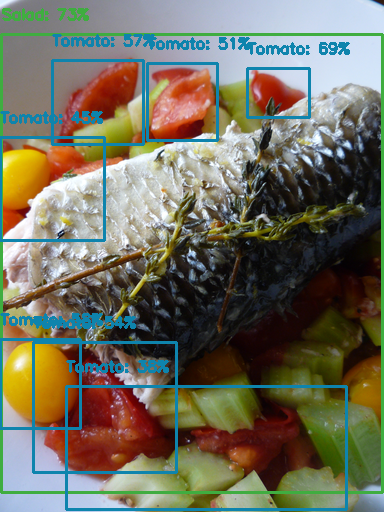

In [ ]:
#@title Run object detection and show the detection results

INPUT_IMAGE_URL = "https://storage.googleapis.com/cloud-ml-data/img/openimage/3/2520/3916261642_0a504acd60_o.jpg" #@param {type:"string"}
DETECTION_THRESHOLD = 0.3 #@param {type:"number"}

TEMP_FILE = '/tmp/image.png'

!wget -q -O $TEMP_FILE $INPUT_IMAGE_URL
im = Image.open(TEMP_FILE)
im.thumbnail((512, 512), Image.ANTIALIAS)
im.save(TEMP_FILE, 'PNG')

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# Run inference and draw detection result on the local copy of the original file
detection_result_image = run_odt_and_draw_results(
    TEMP_FILE,
    interpreter,
    threshold=DETECTION_THRESHOLD
)

# Show the detection result
Image.fromarray(detection_result_image)

## (Optional) Compile For the Edge TPU

Now that you have a quantized EfficientDet Lite model, it is possible to compile and deploy to a [Coral EdgeTPU](https://coral.ai/).

**Step 1. Install the EdgeTPU Compiler**

In [ ]:
! curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -

! echo "deb https://packages.cloud.google.com/apt coral-edgetpu-stable main" | sudo tee /etc/apt/sources.list.d/coral-edgetpu.list

! sudo apt-get update

! sudo apt-get install edgetpu-compiler

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  2537  100  2537    0     0   130k      0 --:--:-- --:--:-- --:--:--  130k


OK


deb https://packages.cloud.google.com/apt coral-edgetpu-stable main



0% [Working]


            
Hit:1 http://us-west1.gce.archive.ubuntu.com/ubuntu bionic InRelease

0% [Connecting to security.ubuntu.com (91.189.91.39)] [Connected to packages.cl
                                                                               
Hit:2 http://us-west1.gce.archive.ubuntu.com/ubuntu bionic-updates InRelease

                                                                               
Hit:3 http://us-west1.gce.archive.ubuntu.com/ubuntu bionic-backports InRelease

0% [Connecting to security.ubuntu.com (91.189.91.39)] [Connected to packages.cl
0% [1 InRelease gpgv 242 kB] [Connecting to security.ubuntu.com (91.189.91.39)]
                                                                               
Hit:4 https://nvidia.github.io/libnvidia-container/stable/ubuntu18.04/amd64  InRelease

0% [1 InRelease gpgv 242 kB] [Connecting to security.ubuntu.com (91.189.91.39)]
                                                                               
Get:5 https://nvidia.github.io


                                                                               
Hit:8 http://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release

0% [1 InRelease gpgv 242 kB] [Connecting to security.ubuntu.com (91.189.91.39)]


0% [Waiting for headers] [Waiting for headers] [Waiting for headers] [Connectin
0% [2 InRelease gpgv 88.7 kB] [Waiting for headers] [Waiting for headers] [Wait
                                                                               
Hit:9 http://security.ubuntu.com/ubuntu bionic-security InRelease

0% [2 InRelease gpgv 88.7 kB] [Waiting for headers] [Waiting for headers] [Conn


                                                                               
Get:10 http://packages.cloud.google.com/apt google-cloud-logging-wheezy InRelease [5483 B]

0% [2 InRelease gpgv 88.7 kB] [Waiting for headers] [10 InRelease 5483 B/5483 B
                                                                               
0% [2 InRelease gpgv 88.7 kB] [Waiting for headers] [Waiting for headers]
                                                                         
0% [Waiting for headers] [Waiting for headers]
0% [3 InRelease gpgv 74.6 kB] [Waiting for headers] [Waiting for headers]


                                                                         
Hit:11 http://archive.canonical.com/ubuntu bionic InRelease

                                                                         
0% [3 InRelease gpgv 74.6 kB] [Waiting for headers]
                                                   
0% [Waiting for headers]
0% [4 InRelease gpgv 1484 B] [Waiting for headers]


                                                  
Get:12 https://packages.cloud.google.com/apt coral-edgetpu-stable InRelease [6722 B]

0% [4 InRelease gpgv 1484 B] [12 InRelease 3553 B/6722 B 53%]
                                                             
0% [4 InRelease gpgv 1484 B]


                            
0% [Waiting for headers]
0% [5 InRelease gpgv 1481 B] [Waiting for headers]


                                                  
0% [Waiting for headers]
0% [6 InRelease gpgv 1474 B] [Waiting for headers]


                                                  
Get:13 https://packages.cloud.google.com/apt eip-cloud-bionic InRelease [5419 B]

0% [6 InRelease gpgv 1474 B] [13 InRelease 4940 B/5419 B 91%]
                                                             
0% [6 InRelease gpgv 1474 B]


                            
0% [Working]
0% [Release.gpg gpgv 564 B]


                           
0% [Working]
0% [9 InRelease gpgv 88.7 kB]


                             
0% [Working]
0% [10 InRelease gpgv 5483 B]


                             
0% [Working]
0% [11 InRelease gpgv 10.2 kB]


                              
0% [Working]
0% [12 InRelease gpgv 6722 B]


                             
0% [Working]
0% [13 InRelease gpgv 5419 B]


                             
Get:15 https://packages.cloud.google.com/apt coral-edgetpu-stable/main amd64 Packages [2327 B]

0% [13 InRelease gpgv 5419 B] [15 Packages 2327 B/2327 B 100%]
                                                              
0% [13 InRelease gpgv 5419 B]
0% [15 Packages store 0 B] [13 InRelease gpgv 5419 B]
                                                     
0% [13 InRelease gpgv 5419 B]


                             
100% [Working]
              
Fetched 21.4 kB in 1s (20.5 kB/s)



Reading package lists... 0%

Reading package lists... 0%




Reading package lists... 3%

Reading package lists... 3%

Reading package lists... 5%

Reading package lists... 5%

Reading package lists... 5%

Reading package lists... 5%

Reading package lists... 5%




Reading package lists... 36%




Reading package lists... 53%




Reading package lists... 53%

Reading package lists... 53%

Reading package lists... 53%




Reading package lists... 61%

Reading package lists... 61%

Reading package lists... 67%




Reading package lists... 69%

Reading package lists... 69%

Reading package lists... 70%




Reading package lists... 76%

Reading package lists... 76%

Reading package lists... 78%

Reading package lists... 78%

Reading package lists... 78%

Reading package lists... 78%

Reading package lists... 78%




Reading package lists... 78%

Reading package lists... 78%

Reading package lists... 78%

Reading package lists... 78%

Reading package lists... 78%

Reading package lists... 78%

Reading package lists... 78%

Reading package lists... 78%

Reading package lists... 85%




Reading package lists... 90%

Reading package lists... 90%

Reading package lists... 92%

Reading package lists... 92%

Reading package lists... 93%

Reading package lists... 93%

Reading package lists... 97%

Reading package lists... 97%

Reading package lists... 99%

Reading package lists... 99%

Reading package lists... 99%

Reading package lists... 99%

Reading package lists... 99%

Reading package lists... 99%

Reading package lists... 99%

Reading package lists... 99%

Reading package lists... 99%

Reading package lists... 99%

Reading package lists... 99%

Reading package lists... 99%

Reading package lists... 99%

Reading package lists... 99%

Reading package lists... 99%

Reading package lists... 99%

Reading package lists... 99%

Reading package lists... 99%

Reading package lists... 99%

Reading package lists... 99%

Reading package lists... 99%




Reading package lists... 99%




Reading package lists... Done




Reading package lists... 100%

Reading package lists... Done


Building dependency tree... 0%




Building dependency tree... 50%




Building dependency tree       


Reading state information... 0%




Reading state information... Done



The following packages were automatically installed and are no longer required:
  linux-gcp-5.4-headers-5.4.0-1040 linux-gcp-5.4-headers-5.4.0-1043
  linux-gcp-5.4-headers-5.4.0-1044 linux-gcp-5.4-headers-5.4.0-1049
  linux-headers-5.4.0-1049-gcp linux-image-5.4.0-1049-gcp
  linux-modules-5.4.0-1044-gcp linux-modules-5.4.0-1049-gcp
  linux-modules-extra-5.4.0-1049-gcp
Use 'sudo apt autoremove' to remove them.


The following NEW packages will be installed:
  edgetpu-compiler
0 upgraded, 1 newly installed, 0 to remove and 113 not upgraded.
Need to get 7913 kB of archives.
After this operation, 31.2 MB of additional disk space will be used.



0% [Working]


0% [Waiting for headers]


                        
Get:1 https://packages.cloud.google.com/apt coral-edgetpu-stable/main amd64 edgetpu-compiler amd64 16.0 [7913 kB]

0% [1 edgetpu-compiler 0 B/7913 kB 0%]


64% [1 edgetpu-compiler 6291 kB/7913 kB 80%]


                                            
100% [Working]
              
Fetched 7913 kB in 1s (7050 kB/s)


Selecting previously unselected package edgetpu-compiler.
(Reading database ... 
(Reading database ... 5%
(Reading database ... 10%
(Reading database ... 15%
(Reading database ... 20%
(Reading database ... 25%
(Reading database ... 30%
(Reading database ... 35%
(Reading database ... 40%
(Reading database ... 45%
(Reading database ... 50%


(Reading database ... 60%
(Reading database ... 65%
(Reading database ... 70%
(Reading database ... 75%
(Reading database ... 80%
(Reading database ... 85%
(Reading database ... 90%


(Reading database ... 100%
(Reading database ... 283192 files and directories currently installed.)
Preparing to unpack .../edgetpu-compiler_16.0_amd64.deb ...
Unpacking edgetpu-compiler (16.0) ...


Setting up edgetpu-compiler (16.0) ...
Processing triggers for libc-bin (2.27-3ubuntu1.2) ...


**Step 2. Select number of Edge TPUs, Compile**

The EdgeTPU has 8MB of SRAM for caching model paramaters ([more info](https://coral.ai/docs/edgetpu/compiler/#parameter-data-caching)). This means that for models that are larger than 8MB, inference time will be increased in order to transfer over model paramaters. One way to avoid this is [Model Pipelining](https://coral.ai/docs/edgetpu/pipeline/) - splitting the model into segments that can have a dedicated EdgeTPU. This can significantly improve latency.

The below table can be used as a reference for the number of Edge TPUs to use - the larger models will not compile for a single TPU as the intermediate tensors can't fit in on-chip memory.

| Model architecture | Minimum TPUs | Recommended TPUs
|--------------------|-------|-------|
| EfficientDet-Lite0 | 1     | 1     |
| EfficientDet-Lite1 | 1     | 1     |
| EfficientDet-Lite2 | 1     | 2     |
| EfficientDet-Lite3 | 2     | 2     |
| EfficientDet-Lite4 | 2     | 3     |

In [ ]:
NUMBER_OF_TPUS =  1#@param {type:"number"}

!edgetpu_compiler model.tflite --num_segments=$NUMBER_OF_TPUS

Edge TPU Compiler version 16.0.384591198


Started a compilation timeout timer of 180 seconds.



Model compiled successfully in 4871 ms.

Input model: model.tflite
Input size: 4.22MiB
Output model: model_edgetpu.tflite
Output size: 5.61MiB
On-chip memory used for caching model parameters: 4.24MiB
On-chip memory remaining for caching model parameters: 3.27MiB
Off-chip memory used for streaming uncached model parameters: 0.00B
Number of Edge TPU subgraphs: 1
Total number of operations: 267
Operation log: model_edgetpu.log

Model successfully compiled but not all operations are supported by the Edge TPU. A percentage of the model will instead run on the CPU, which is slower. If possible, consider updating your model to use only operations supported by the Edge TPU. For details, visit g.co/coral/model-reqs.
Number of operations that will run on Edge TPU: 264
Number of operations that will run on CPU: 3
See the operation log file for individual operation details.


Compilation child process completed within timeout period.
Compilation succeeded! 


**Step 3. Download, Run Model**

With the model(s) compiled, they can now be run on EdgeTPU(s) for object detection. First, download the compiled TensorFlow Lite model file using the left sidebar of Colab. Right-click on the `model_edgetpu.tflite` file and choose `Download` to download it to your local computer.

Now you can run the model in your preferred manner. Examples of detection include:
* [pycoral detection](https://github.com/google-coral/pycoral/blob/master/examples/detect_image.py)
* [Basic TFLite detection](https://github.com/google-coral/tflite/tree/master/python/examples/detection)
* [Example Video Detection](https://github.com/google-coral/examples-camera)
* [libcoral C++ API](https://github.com/google-coral/libcoral)


## Advanced Usage

This section covers advanced usage topics like adjusting the model and the training hyperparameters.

### Load the dataset

#### Load your own data

You can upload your own dataset to work through this tutorial. Upload your dataset by using the left sidebar in Colab.

<img src="https://storage.googleapis.com/download.tensorflow.org/models/tflite/screenshots/model_maker_object_detection.png" alt="Upload File" width="1000" hspace="0">

If you prefer not to upload your dataset to the cloud, you can also locally run the library by following the [guide](https://github.com/tensorflow/examples/tree/master/tensorflow_examples/lite/model_maker).

#### Load your data with a different data format

The Model Maker library also supports the `object_detector.DataLoader.from_pascal_voc` method to load data with [PASCAL VOC](https://towardsdatascience.com/coco-data-format-for-object-detection-a4c5eaf518c5#:~:text=Pascal%20VOC%20is%20an%20XML,for%20training%2C%20testing%20and%20validation) format. [makesense.ai](https://www.makesense.ai/) and [LabelImg](https://github.com/tzutalin/labelImg) are the tools that can annotate the image and save annotations as XML files in PASCAL VOC data format:
```python
object_detector.DataLoader.from_pascal_voc(image_dir, annotations_dir, label_map={1: "person", 2: "notperson"})
```


### Customize the EfficientDet model hyperparameters

The model and training pipline parameters you can adjust are:

* `model_dir`: The location to save the model checkpoint files. If not set, a temporary directory will be used.
* `steps_per_execution`: Number of steps per training execution.
* `moving_average_decay`: Float. The decay to use for maintaining moving averages of the trained parameters.
* `var_freeze_expr`: The regular expression to map the prefix name of variables to be frozen which means remaining the same during training. More specific, use `re.match(var_freeze_expr, variable_name)` in the codebase to map the variables to be frozen.
* `tflite_max_detections`: integer, 25 by default. The max number of output detections in the TFLite model.
* `strategy`:  A string specifying which distribution strategy to use. Accepted values are 'tpu', 'gpus', None. tpu' means to use TPUStrategy. 'gpus' mean to use MirroredStrategy for multi-gpus. If None, use TF default with OneDeviceStrategy.
* `tpu`:  The Cloud TPU to use for training. This should be either the name used when creating the Cloud TPU, or a grpc://ip.address.of.tpu:8470 url.
* `use_xla`: Use XLA even if strategy is not tpu. If strategy is tpu, always use XLA, and this flag has no effect.
* `profile`: Enable profile mode.
* `debug`: Enable debug mode.

Other parameters that can be adjusted is shown in [hparams_config.py](https://github.com/google/automl/blob/df451765d467c5ed78bbdfd632810bc1014b123e/efficientdet/hparams_config.py#L170).


For instance, you can set the `var_freeze_expr='efficientnet'` which freezes the variables with name prefix `efficientnet` (default is `'(efficientnet|fpn_cells|resample_p6)'`). This allows the model to freeze untrainable variables and keep their value the same through training.

```python
spec = model_spec.get('efficientdet_lite0')
spec.config.var_freeze_expr = 'efficientnet'
```

### Change the Model Architecture

You can change the model architecture by changing the `model_spec`. For instance, change the `model_spec` to the EfficientDet-Lite4 model.

```python
spec = model_spec.get('efficientdet_lite4')
```

### Tune the training hyperparameters

The `create` function is the driver function that the Model Maker library uses to create models. The `model_spec` parameter defines the model specification. The `object_detector.EfficientDetSpec` class is currently supported. The `create` function comprises of the following steps:

1. Creates the model for the object detection according to `model_spec`.
2. Trains the model.  The default epochs and the default batch size are set by the `epochs` and `batch_size` variables in the `model_spec` object.
You can also tune the training hyperparameters like `epochs` and `batch_size` that affect the model accuracy. For instance,

*   `epochs`: Integer, 50 by default. More epochs could achieve better accuracy, but may lead to overfitting.
*   `batch_size`: Integer, 64 by default. The number of samples to use in one training step.
*   `train_whole_model`: Boolean, False by default. If true, train the whole model. Otherwise, only train the layers that do not match `var_freeze_expr`.

For example, you can train with less epochs and only the head layer. You can increase the number of epochs for better results.

```python
model = object_detector.create(train_data, model_spec=spec, epochs=10, validation_data=validation_data)
```

### Export to different formats

The export formats can be one or a list of the following:

*   `ExportFormat.TFLITE`
*   `ExportFormat.LABEL`
*   `ExportFormat.SAVED_MODEL`




By default, it exports only the TensorFlow Lite model file containing the model [metadata](https://www.tensorflow.org/lite/convert/metadata) so that you can later use in an on-device ML application. The label file is embedded in metadata.

In many on-device ML application, the model size is an important factor. Therefore, it is recommended that you quantize the model to make it smaller and potentially run faster. As for EfficientDet-Lite models, full integer quantization  is used to quantize the model by default. Please refer to [Post-training quantization](https://www.tensorflow.org/lite/performance/post_training_quantization) for more detail.

```python
model.export(export_dir='.')
```

You can also choose to export other files related to the model for better examination. For instance, exporting both the saved model and the label file as follows:
```python
model.export(export_dir='.', export_format=[ExportFormat.SAVED_MODEL, ExportFormat.LABEL])
```

### Customize Post-training quantization on the TensorFlow Lite model

[Post-training quantization](https://www.tensorflow.org/lite/performance/post_training_quantization) is a conversion technique that can reduce model size and inference latency, while also improving CPU and hardware accelerator inference speed, with a little degradation in model accuracy. Thus, it's widely used to optimize the model.

Model Maker library applies a default post-training quantization techique when exporting the model. If you want to customize post-training quantization, Model Maker supports multiple post-training quantization options using [QuantizationConfig](https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker/config/QuantizationConfig) as well. Let's take float16 quantization as an instance. First, define the quantization config.

```python
config = QuantizationConfig.for_float16()
```


Then we export the TensorFlow Lite model with such configuration.

```python
model.export(export_dir='.', tflite_filename='model_fp16.tflite', quantization_config=config)
```

# Read more

You can read our [object detection](https://www.tensorflow.org/lite/examples/object_detection/overview) example to learn technical details. For more information, please refer to:

*   TensorFlow Lite Model Maker [guide](https://www.tensorflow.org/lite/guide/model_maker) and [API reference](https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker).
*   Task Library: [ObjectDetector](https://www.tensorflow.org/lite/inference_with_metadata/task_library/object_detector) for deployment.
*   The end-to-end reference apps: [Android](https://github.com/tensorflow/examples/tree/master/lite/examples/object_detection/android), [iOS](https://github.com/tensorflow/examples/tree/master/lite/examples/object_detection/ios), and [Raspberry PI](https://github.com/tensorflow/examples/tree/master/lite/examples/object_detection/raspberry_pi).

